In [654]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.utils import from_networkx

In [589]:
G1 = nx.Graph()
G1.add_nodes_from([1, 2, 3])
G1.add_edges_from([(1, 2), (1, 3), (2, 3)])
print(G1)

Graph with 3 nodes and 3 edges


In [590]:
list(G1.edges)

[(1, 2), (1, 3), (2, 3)]

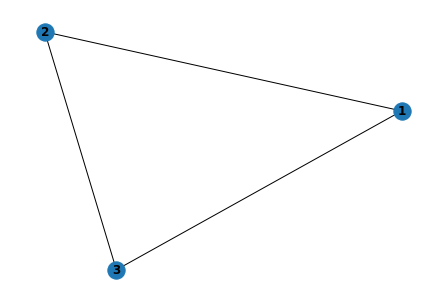

In [591]:
nx.draw(G1, with_labels=True, font_weight='bold')

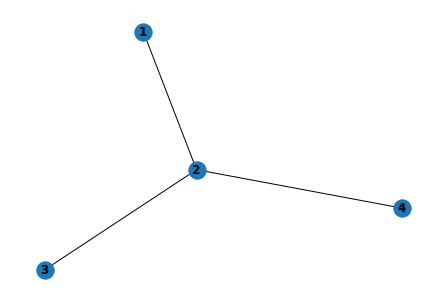

In [6]:
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4])
G2.add_edges_from([(1, 2), (2, 3), (2, 4)])
nx.draw(G2, with_labels=True, font_weight='bold')

In [7]:
g_int = nx.intersection(G1, G2)

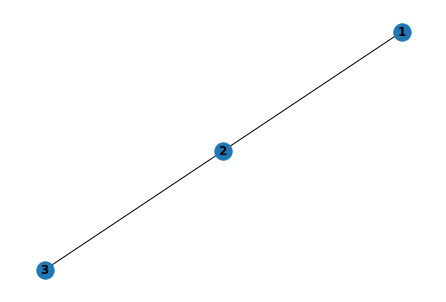

In [8]:
g_int.remove_nodes_from(list(nx.isolates(g_int)))
nx.draw(g_int, with_labels=True, font_weight='bold')


In [9]:
n_tp = g_int.number_of_edges()
n_tp

2

In [10]:
n_fp = len(G1.edges() - g_int.edges())
n_fp

1

In [11]:
n_fn = len(G2.edges() - g_int.edges())
n_fn

1

In [12]:
G2.edges() - g_int.edges()

{(2, 4)}

In [13]:
precision = n_tp / (n_tp + n_fp)
recall = n_tp / (n_tp + n_fn)
f1_score = 2*(precision * recall)/(precision + recall)
f1_score

0.6666666666666666

In [14]:
nx.graph_edit_distance(G1, G2)

3.0

In [521]:
def ba(n, m, role_start=0):
    G = nx.barabasi_albert_graph(n, m)
    labels = [role_start for i in range(n)]
    return G, labels


def house(start, role_start=1):
    """Builds a house-like  graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles


def build_ba_shapes(n_basis, n_shapes, rdm_basis_plugins=True, rdm_shape_plugins=True, pos=3, add_random_edges=0, m=5):
    # where you will plugin the houses
    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        plugins = [int(k * spacing) for k in range(n_shapes)]

    basis, role_id = ba(n_basis, m)
    start = n_basis
    for shape_id in range(n_shapes):
        graph_s, role_graph_s = house(start)
        n_s = nx.number_of_nodes(graph_s)
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        if rdm_shape_plugins is True:
            pos = np.random.choice(range(start, start+n_s))
        basis.add_edges_from([(pos, plugins[shape_id])])
        role_id += role_graph_s
        start += n_s

    if add_random_edges > 0:
        # add random edges between nodes:
        n_rand = int(n_basis*add_random_edges)
        for p in range(n_rand):
            src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
            basis.add_edges_from([(src, dest)])
            
            
    # Add constant node features
    feat_dict = {i:{'feat': np.array([1], dtype=np.float32)} for i in basis.nodes()}
    nx.set_node_attributes(basis, feat_dict)
    
    # Convert graph into undirected graph
    basis = basis.to_undirected()

    return basis, role_id, plugins


In [650]:
n_basis, n_shapes = 1500, 300

G, labels, plugins = build_ba_shapes(n_basis, n_shapes)
#nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=labels, with_labels=True, font_weight='bold')

In [651]:
plugins

array([ 103,   89,  211,  302, 1044, 1305, 1133,  714,   76, 1424,  205,
       1479,  202,  707,  318,  686,  710,  450,  124,  344, 1361,  154,
        824,  298,  261,  629,  795,  150, 1208,  295, 1045,  682,  656,
        609,  972,  177,  702,  837, 1058, 1295,   90, 1149,  643,  815,
        799,  434,  489, 1211, 1277,  519, 1327,  907, 1294,  553, 1423,
       1477,  168,  325,  155, 1315,  373,  990,  737,  692, 1188,  559,
        630, 1172, 1375, 1333,  858,  576,    3,  791,  136,   52, 1035,
       1355,  776,  393,  744,  483,  387,  908,  171,  462, 1379, 1400,
        248,  983, 1457, 1201,  699, 1204,  878,  808,  909,  454,  358,
        713,  583, 1124,  431, 1013, 1143,  571, 1039,  839, 1287, 1097,
        347, 1053, 1246,  664,  224,  891,  935,   36, 1237, 1475, 1301,
        498,   66,  209, 1095,  288,  130,  508,  407, 1129,  235,   91,
        674, 1134,  764, 1016,  885,  254, 1445, 1322, 1145,  651, 1090,
        291, 1030, 1265,  246, 1288,  942, 1218,  5

In [652]:
def preprocess_input_graph(G, labels, normalize_adj=False):
    """ Load an existing graph to be converted for the experiments.
    Args:
        G: Networkx graph to be loaded.
        labels: Associated node labels.
        normalize_adj: Should the method return a normalized adjacency matrix.
    Returns:
        A dictionary containing adjacency, node features and labels
    """
    adj = np.array(nx.to_numpy_matrix(G))
    if normalize_adj:
        sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
        adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)

    existing_node = list(G.nodes)[-1]
    feat_dim = G.nodes[existing_node]["feat"].shape[0]
    f = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for i, u in enumerate(G.nodes()):
        f[i, :] = G.nodes[u]["feat"]

    # add batch dim
    #adj = np.expand_dims(adj, axis=0)
    #f = np.expand_dims(f, axis=0)
    #labels = np.expand_dims(labels, axis=0)
    return {"adj": adj, "feat": f, "labels": labels}

In [655]:
data = from_networkx(G, all)
data.edge_index.shape

torch.Size([2, 19150])

In [656]:
from torch_geometric.utils import is_undirected, to_undirected

data.is_undirected()

True

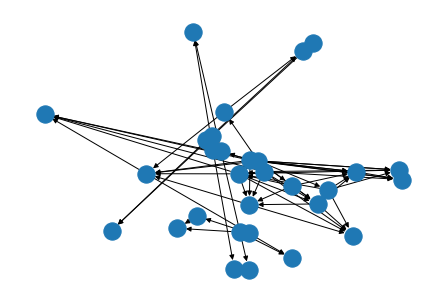

In [614]:
g = torch_geometric.utils.to_networkx(data, to_undirected=False)
nx.draw(g)

In [657]:
data.num_node_features
data.num_classes = len(np.unique(labels))
data.y = torch.LongTensor(labels)

In [658]:
n = data.num_nodes
data.train_mask, data.val_mask, data.test_mask = torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8), torch.zeros(n, dtype=torch.uint8)

In [659]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(range(n), test_size=0.2, random_state=42, shuffle=True)
train_ids, val_ids = train_test_split(train_ids, test_size=0.15, random_state=42, shuffle=True)

data.train_mask[train_ids] = 1
data.val_mask[val_ids] = 1
data.test_mask[test_ids] = 1

In [673]:
len(data.y[data.val_mask])

/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_44091/2781205052.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  len(data.y[data.val_mask])


360

In [704]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_layers = 2
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [675]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR

n_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = ExponentialLR(optimizer, gamma=0.99)
scheduler = StepLR(optimizer, step_size=100, gamma=0.99)

val_err = []
train_err = []
        

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    
    if epoch%10==0:
        val_err.append(val_loss.item())
        train_err.append(loss.item())
        
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    #scheduler.step(val_loss)

/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_44091/2399002929.py:24: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_44091/2399002929.py:25: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])


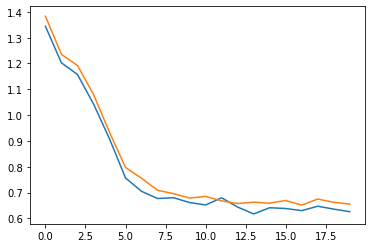

In [676]:
plt.plot(range(n_epochs//10), val_err)
plt.plot(range(n_epochs//10), train_err)

In [677]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6883


/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_44091/1796556738.py:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()


In [678]:
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6828


/var/folders/2h/f06x9_xj7170hdxzgdbhs_7c0000gn/T/ipykernel_44091/3035444030.py:2: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
  correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()


In [679]:
edge_mask[indices] = torch.FloatTensor([1]*num_top_edges)
explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y = data.y, threshold=0.99)

TypeError: 'int' object is not callable

In [680]:
def get_explanation(data, edge_mask, num_top_edges):
    #values,indices = edge_mask.topk(num_top_edges)
    indices = (-edge_mask).argsort()[:num_top_edges]
    explanation = data.edge_index[:,indices]
    
    G_expl = nx.Graph()
    G_expl.add_nodes_from(np.unique(explanation))

    for i, (u, v) in enumerate(explanation.t().tolist()):
        G_expl.add_edge(u, v)
        
    return(G_expl)

In [681]:
def get_ground_truth_ba_shapes(node):
    base = [0, 1, 2, 3, 4]
    ground_truth = []
    offset = node % 5
    ground_truth = [node - offset + val for val in base]
    start = ground_truth[0]
    graph, role = house(start, role_start=1)
    return graph, role

In [682]:
def scores(G1, G2):
    g_int = nx.intersection(G1, G2)
    g_int.remove_nodes_from(list(nx.isolates(g_int)))

    n_tp = g_int.number_of_edges()
    n_fp = len(G1.edges() - g_int.edges())
    n_fn = len(G2.edges() - g_int.edges())

    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    if n_tp == 0:
        f1_score = 0
    else: 
        f1_score = 2 * (precision * recall) / (precision + recall)

    ged = nx.graph_edit_distance(G1, G2)

    return recall, precision, f1_score, ged

In [683]:
def evaluate(node_idx, data, edge_mask, num_top_edges):
    G_true, role = get_ground_truth_ba_shapes(node_idx)
    # nx.draw(G_true, cmap=plt.get_cmap('viridis'), node_color=role, with_labels=True, font_weight='bold')
    G_expl = get_explanation(data, edge_mask, num_top_edges)
    plt.figure()
    nx.draw(G_expl,  with_labels=True, font_weight='bold')
    plt.show()
    plt.clf()
    return scores(G_expl, G_true)


Explain node 1500: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1307.65it/s]


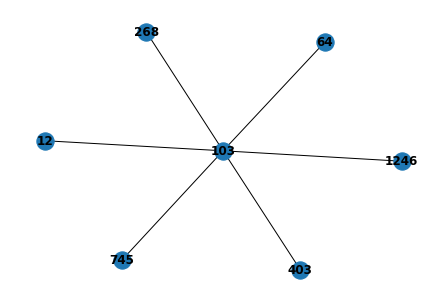

f1_score, ged 0 8.0



Explain node 1501: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1502.81it/s]


<Figure size 432x288 with 0 Axes>

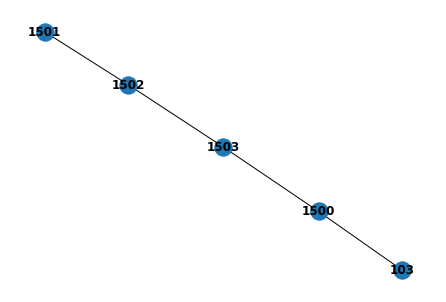

f1_score, ged 0.6 2.0



Explain node 1502: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1458.64it/s]


<Figure size 432x288 with 0 Axes>

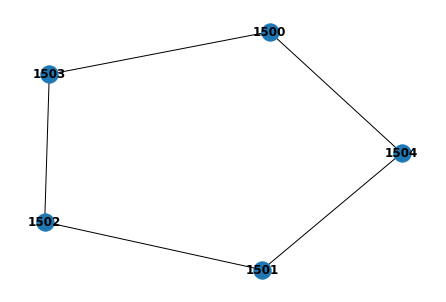

f1_score, ged 0.9090909090909091 1.0



Explain node 1503: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1499.95it/s]


<Figure size 432x288 with 0 Axes>

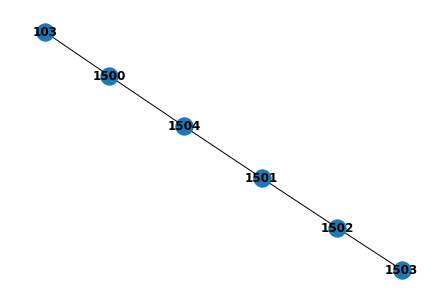

f1_score, ged 0.7272727272727272 4.0



Explain node 1504: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1481.65it/s]


<Figure size 432x288 with 0 Axes>

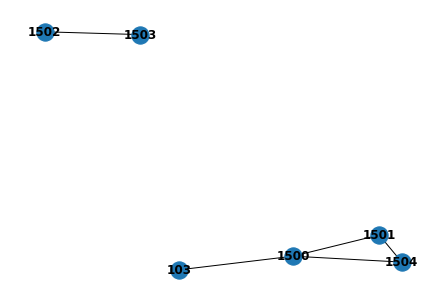

f1_score, ged 0.7272727272727272 4.0



Explain node 1505: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1507.66it/s]


<Figure size 432x288 with 0 Axes>

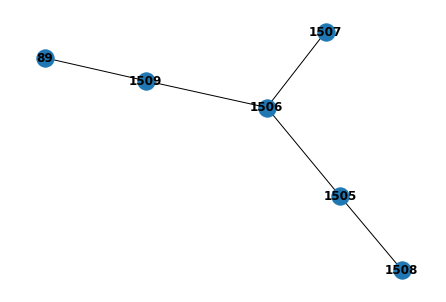

f1_score, ged 0.7272727272727272 4.0



Explain node 1506: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1468.06it/s]


<Figure size 432x288 with 0 Axes>

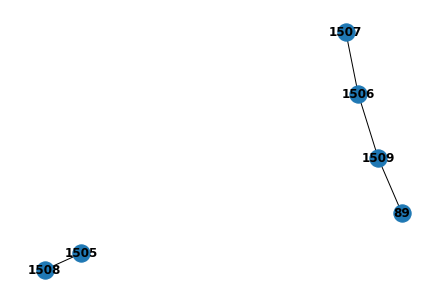

f1_score, ged 0.6 5.0



Explain node 1507: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1501.23it/s]


<Figure size 432x288 with 0 Axes>

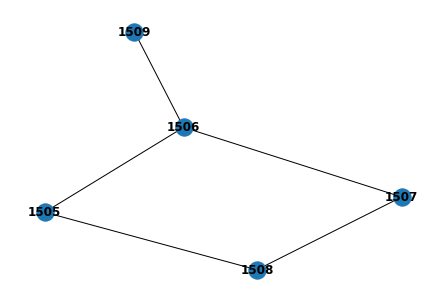

f1_score, ged 0.9090909090909091 1.0



Explain node 1508: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1420.11it/s]


<Figure size 432x288 with 0 Axes>

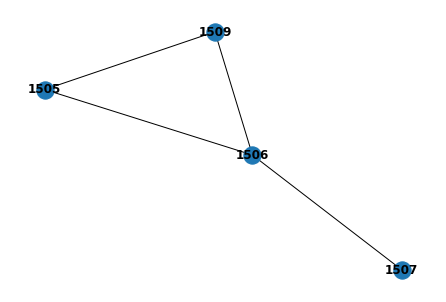

f1_score, ged 0.8 3.0



Explain node 1509: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1495.75it/s]


<Figure size 432x288 with 0 Axes>

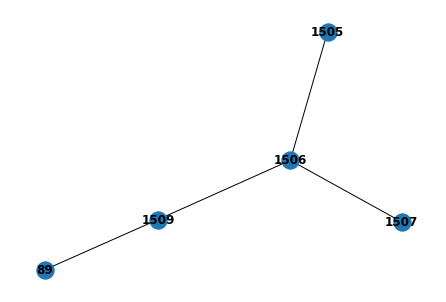

f1_score, ged 0.6 2.0



Explain node 1510: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1581.03it/s]


<Figure size 432x288 with 0 Axes>

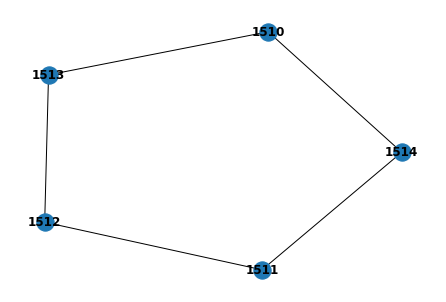

f1_score, ged 0.9090909090909091 1.0



Explain node 1920:  57%|████████████████████████████████████████████████▍                                    | 57/100 [07:01<05:17,  7.39s/it]


<Figure size 432x288 with 0 Axes>

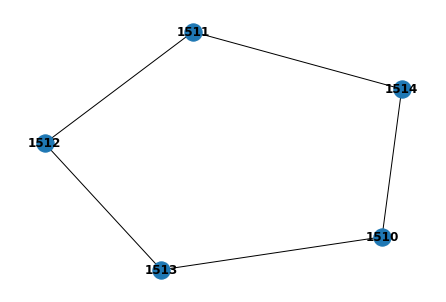

f1_score, ged 0.9090909090909091 1.0


Explain node 1512: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1602.97it/s]


<Figure size 432x288 with 0 Axes>

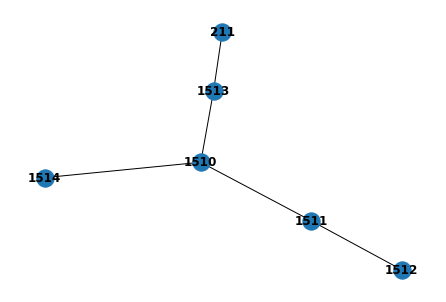

f1_score, ged 0.7272727272727272 4.0


Explain node 1513: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1613.81it/s]


<Figure size 432x288 with 0 Axes>

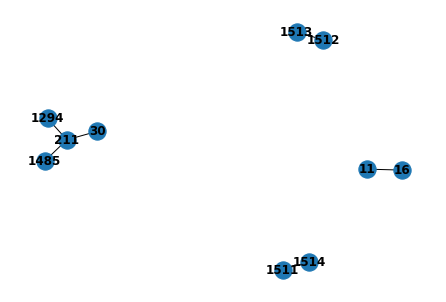

f1_score, ged 0.3333333333333333 11.0


Explain node 1514: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1752.82it/s]


<Figure size 432x288 with 0 Axes>

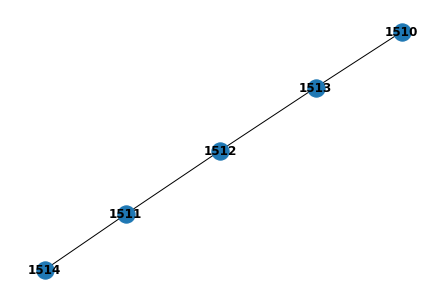

f1_score, ged 0.8 2.0


Explain node 1515: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1544.83it/s]


<Figure size 432x288 with 0 Axes>

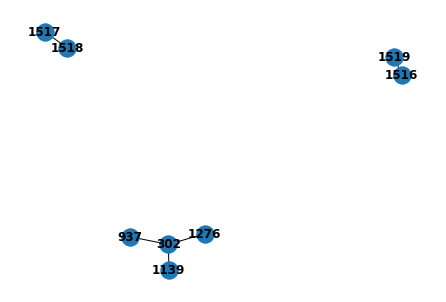

f1_score, ged 0.3636363636363636 8.0


Explain node 1516: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1653.83it/s]


<Figure size 432x288 with 0 Axes>

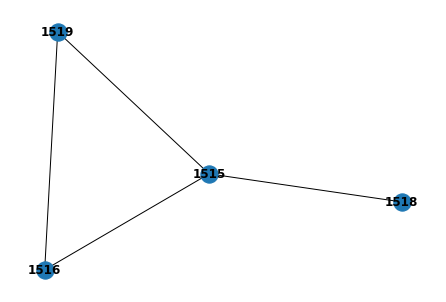

f1_score, ged 0.8 3.0


Explain node 1517: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1611.39it/s]


<Figure size 432x288 with 0 Axes>

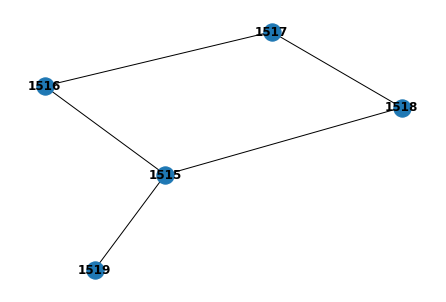

f1_score, ged 0.9090909090909091 1.0


Explain node 1518: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1473.99it/s]


<Figure size 432x288 with 0 Axes>

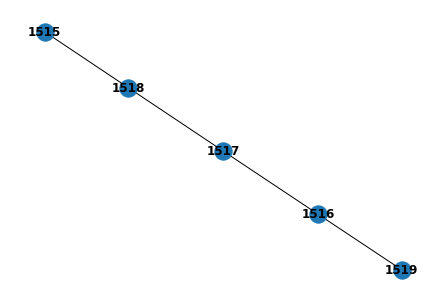

f1_score, ged 0.8 2.0


Explain node 1519: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1627.05it/s]


<Figure size 432x288 with 0 Axes>

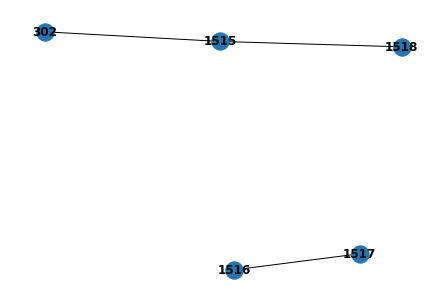

f1_score, ged 0.4444444444444444 3.0


Explain node 1520: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1546.34it/s]


<Figure size 432x288 with 0 Axes>

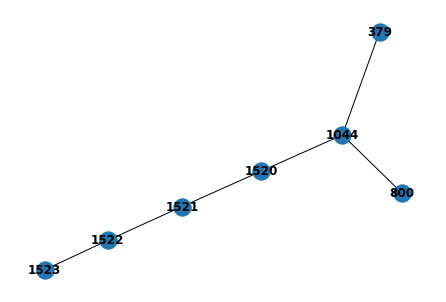

f1_score, ged 0.5 6.0


Explain node 1521: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1566.24it/s]


<Figure size 432x288 with 0 Axes>

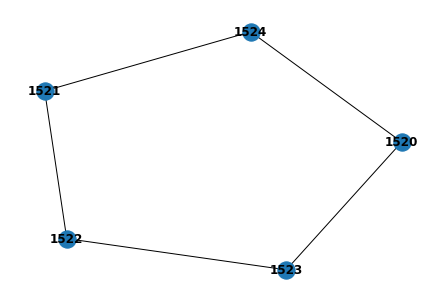

f1_score, ged 0.9090909090909091 1.0


Explain node 1522: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1564.72it/s]


<Figure size 432x288 with 0 Axes>

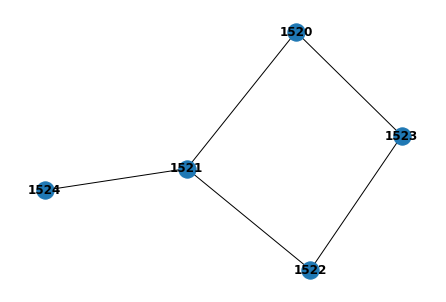

f1_score, ged 0.9090909090909091 1.0


Explain node 1523: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1595.99it/s]


<Figure size 432x288 with 0 Axes>

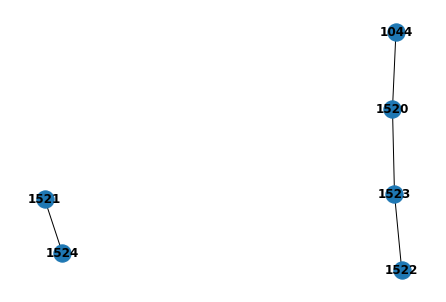

f1_score, ged 0.6 5.0


Explain node 1524: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1603.59it/s]


<Figure size 432x288 with 0 Axes>

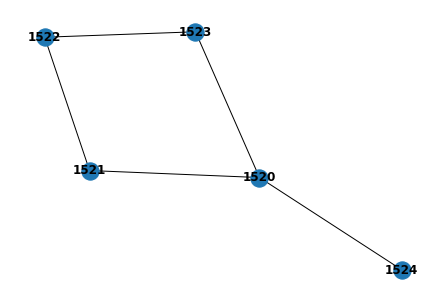

f1_score, ged 0.9090909090909091 1.0


Explain node 1525: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1568.02it/s]


<Figure size 432x288 with 0 Axes>

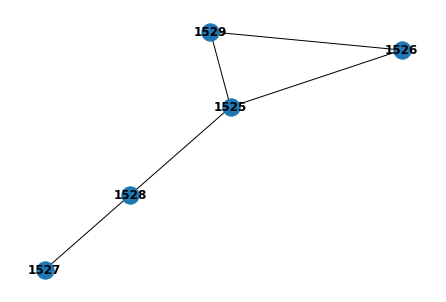

f1_score, ged 0.9090909090909091 1.0


Explain node 1526: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1600.46it/s]


<Figure size 432x288 with 0 Axes>

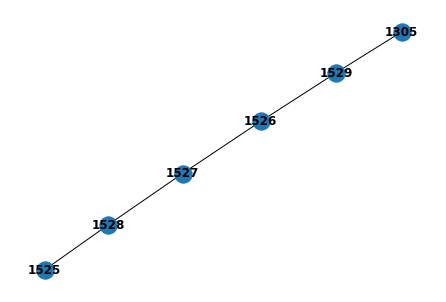

f1_score, ged 0.7272727272727272 4.0


Explain node 1527: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1572.62it/s]


<Figure size 432x288 with 0 Axes>

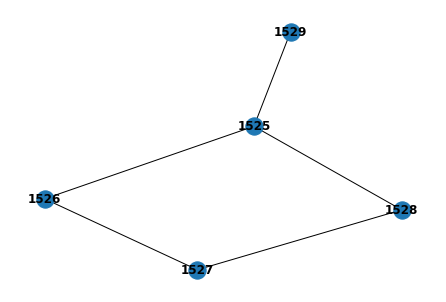

f1_score, ged 0.9090909090909091 1.0


Explain node 1528: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1568.87it/s]


<Figure size 432x288 with 0 Axes>

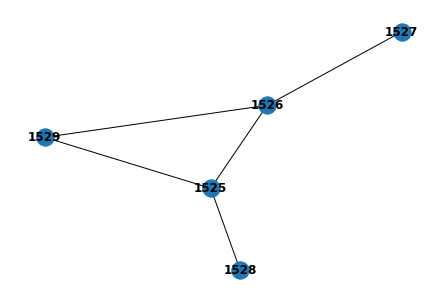

f1_score, ged 0.9090909090909091 1.0


Explain node 1529: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1504.59it/s]


<Figure size 432x288 with 0 Axes>

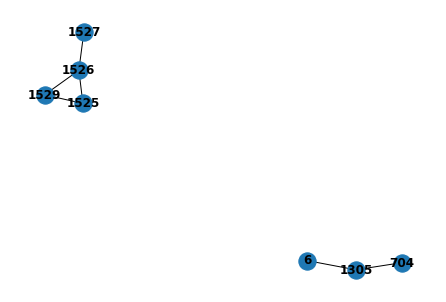

f1_score, ged 0.6666666666666666 6.0


Explain node 1530: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1560.19it/s]


<Figure size 432x288 with 0 Axes>

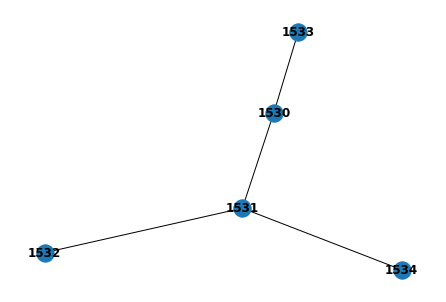

f1_score, ged 0.8 2.0


Explain node 1531: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1570.05it/s]


<Figure size 432x288 with 0 Axes>

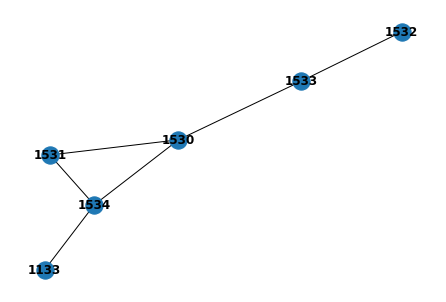

f1_score, ged 0.8333333333333334 3.0


Explain node 1532: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1553.88it/s]


<Figure size 432x288 with 0 Axes>

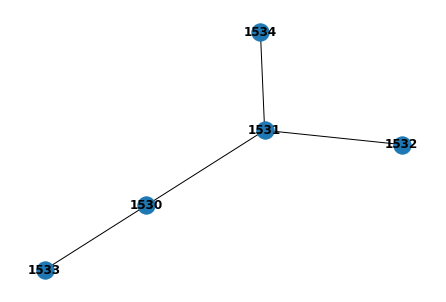

f1_score, ged 0.8 2.0


Explain node 1533: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1617.52it/s]


<Figure size 432x288 with 0 Axes>

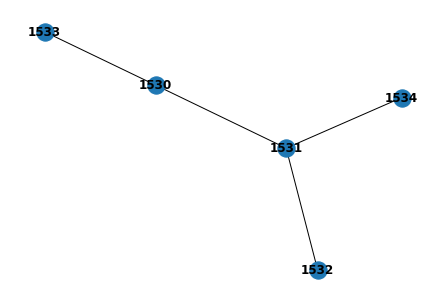

f1_score, ged 0.8 2.0


Explain node 1534: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1537.37it/s]


<Figure size 432x288 with 0 Axes>

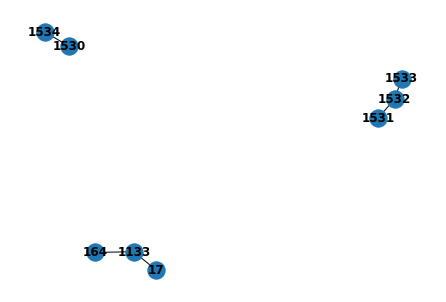

f1_score, ged 0.5454545454545454 8.0


Explain node 1535: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1606.22it/s]


<Figure size 432x288 with 0 Axes>

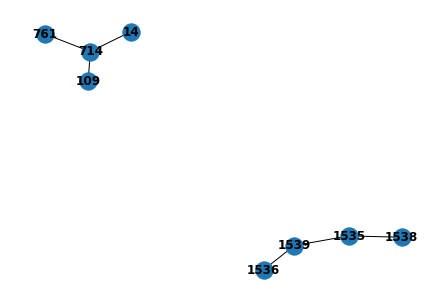

f1_score, ged 0.5 9.0


Explain node 1536: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1757.28it/s]


<Figure size 432x288 with 0 Axes>

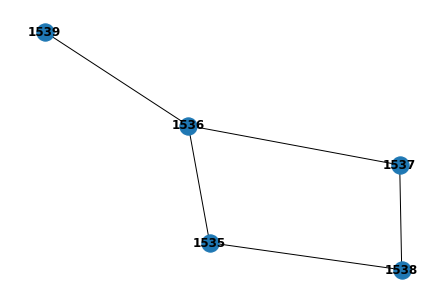

f1_score, ged 0.9090909090909091 1.0


Explain node 1537: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1650.71it/s]


<Figure size 432x288 with 0 Axes>

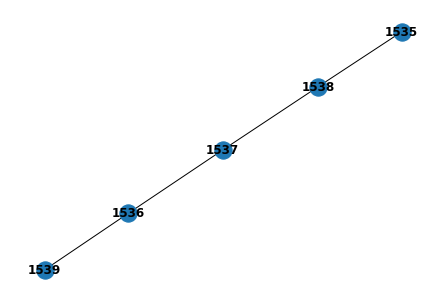

f1_score, ged 0.8 2.0


Explain node 1538: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1637.36it/s]


<Figure size 432x288 with 0 Axes>

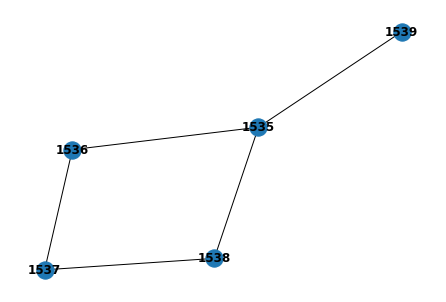

f1_score, ged 0.9090909090909091 1.0


Explain node 1539: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1648.02it/s]


<Figure size 432x288 with 0 Axes>

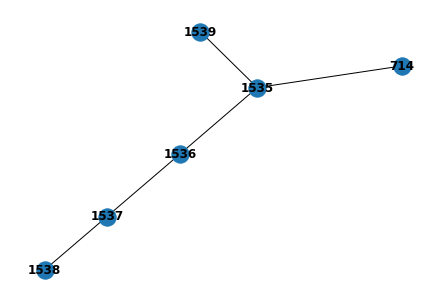

f1_score, ged 0.7272727272727272 4.0


Explain node 1540: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1441.92it/s]


<Figure size 432x288 with 0 Axes>

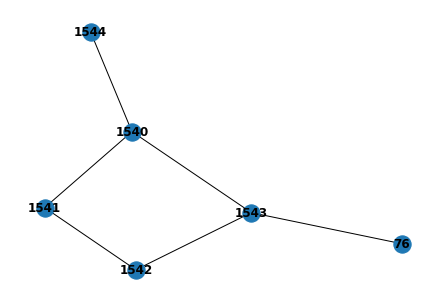

f1_score, ged 0.8333333333333334 3.0


Explain node 1541: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1667.86it/s]


<Figure size 432x288 with 0 Axes>

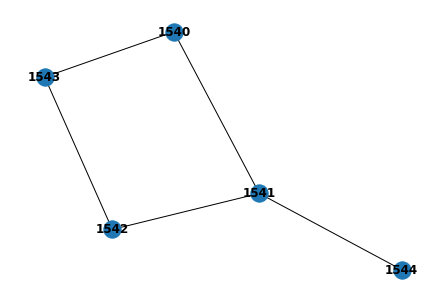

f1_score, ged 0.9090909090909091 1.0


Explain node 1542: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1606.48it/s]


<Figure size 432x288 with 0 Axes>

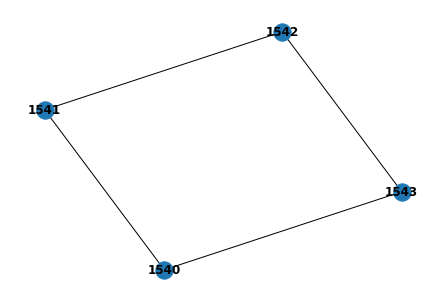

f1_score, ged 0.8 3.0


Explain node 1543: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1563.92it/s]


<Figure size 432x288 with 0 Axes>

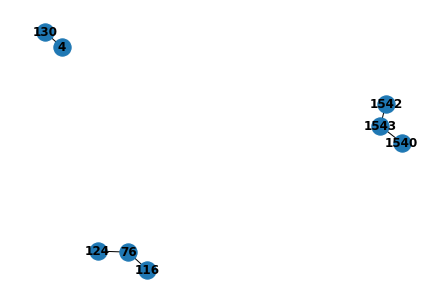

f1_score, ged 0.3636363636363636 8.0


Explain node 1544: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1651.12it/s]


<Figure size 432x288 with 0 Axes>

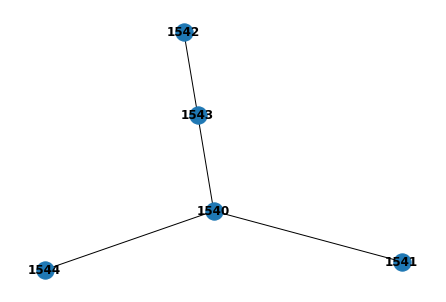

f1_score, ged 0.8 2.0


Explain node 1545: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1610.61it/s]


<Figure size 432x288 with 0 Axes>

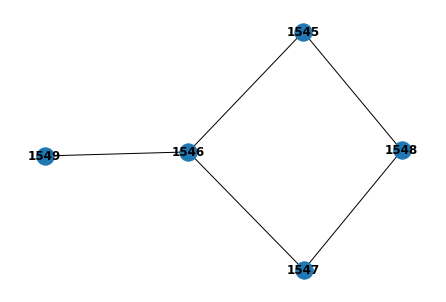

f1_score, ged 0.9090909090909091 1.0


Explain node 1546: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1610.90it/s]


<Figure size 432x288 with 0 Axes>

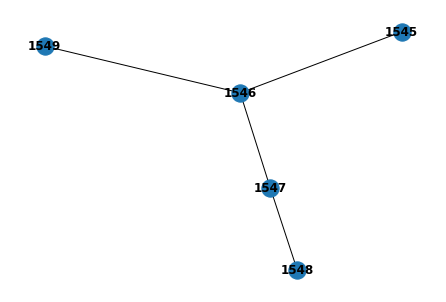

f1_score, ged 0.8 2.0


Explain node 1547: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1544.80it/s]


<Figure size 432x288 with 0 Axes>

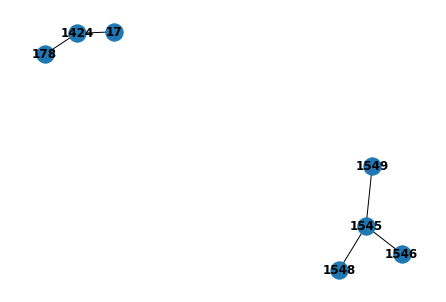

f1_score, ged 0.5454545454545454 7.0


Explain node 1548: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1598.60it/s]


<Figure size 432x288 with 0 Axes>

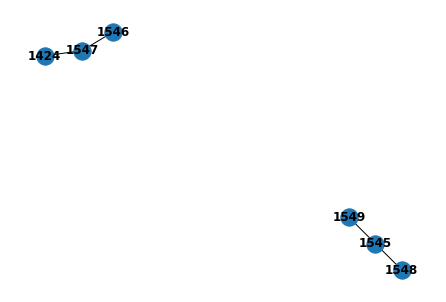

f1_score, ged 0.6 5.0


Explain node 1549: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1585.66it/s]


<Figure size 432x288 with 0 Axes>

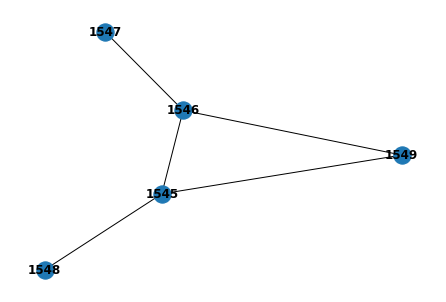

f1_score, ged 0.9090909090909091 1.0


Explain node 1550: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1626.17it/s]


<Figure size 432x288 with 0 Axes>

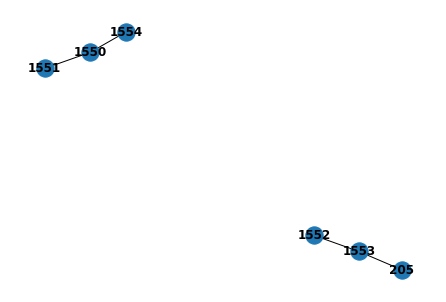

f1_score, ged 0.6 5.0


Explain node 1551: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1597.29it/s]


<Figure size 432x288 with 0 Axes>

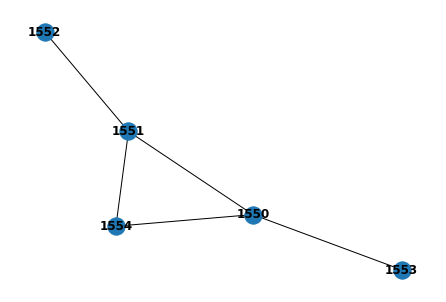

f1_score, ged 0.9090909090909091 1.0


Explain node 1552: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1623.67it/s]


<Figure size 432x288 with 0 Axes>

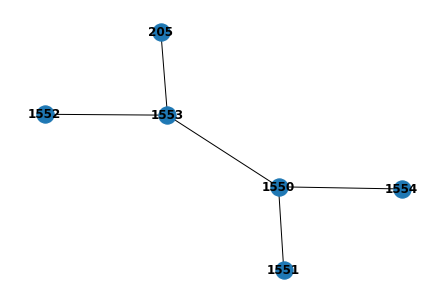

f1_score, ged 0.7272727272727272 4.0


Explain node 1553: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1621.01it/s]


<Figure size 432x288 with 0 Axes>

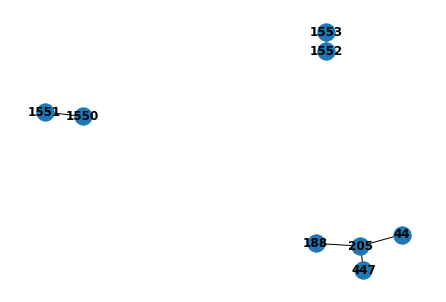

f1_score, ged 0.3636363636363636 8.0


Explain node 1554: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1485.02it/s]


<Figure size 432x288 with 0 Axes>

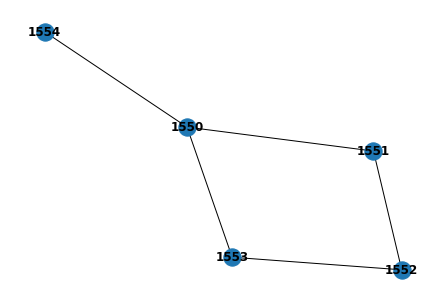

f1_score, ged 0.9090909090909091 1.0


Explain node 1555: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1666.75it/s]


<Figure size 432x288 with 0 Axes>

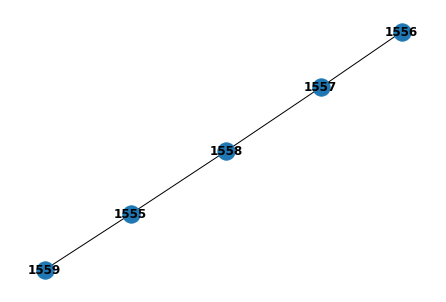

f1_score, ged 0.8 2.0


Explain node 1556: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1632.49it/s]


<Figure size 432x288 with 0 Axes>

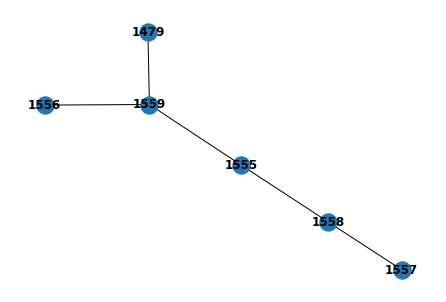

f1_score, ged 0.7272727272727272 4.0


Explain node 1557: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1635.86it/s]


<Figure size 432x288 with 0 Axes>

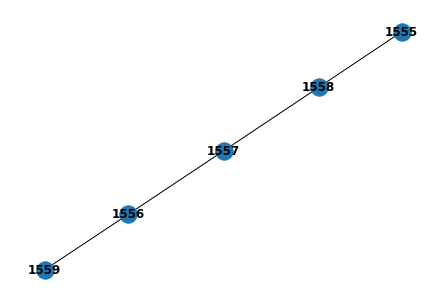

f1_score, ged 0.8 2.0


Explain node 1558: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1503.33it/s]


<Figure size 432x288 with 0 Axes>

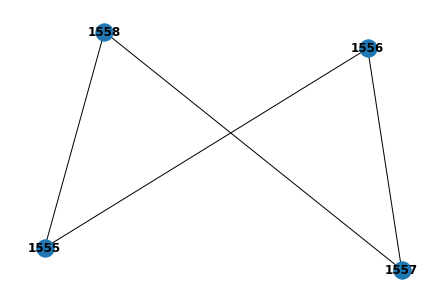

f1_score, ged 0.8 3.0


Explain node 1559: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1625.80it/s]


<Figure size 432x288 with 0 Axes>

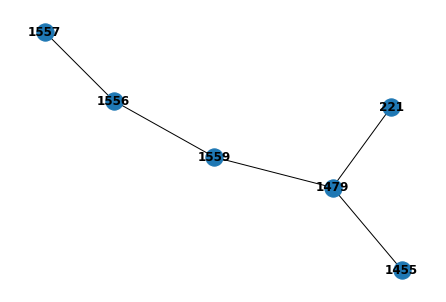

f1_score, ged 0.3636363636363636 4.0


Explain node 1560: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1588.31it/s]


<Figure size 432x288 with 0 Axes>

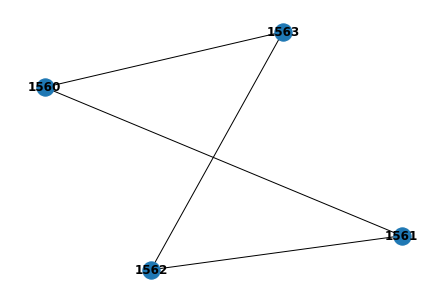

f1_score, ged 0.8 3.0


Explain node 1561: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1563.60it/s]


<Figure size 432x288 with 0 Axes>

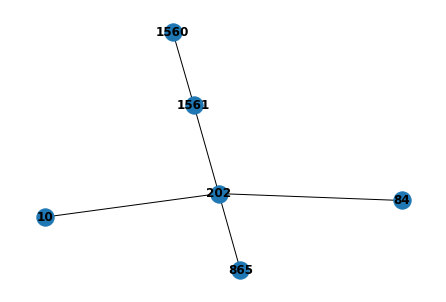

f1_score, ged 0.1818181818181818 4.0


Explain node 1562: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1629.14it/s]


<Figure size 432x288 with 0 Axes>

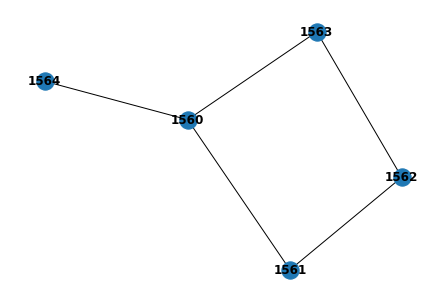

f1_score, ged 0.9090909090909091 1.0


Explain node 1563: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1667.39it/s]


<Figure size 432x288 with 0 Axes>

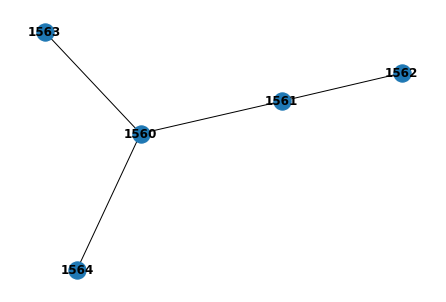

f1_score, ged 0.8 2.0


Explain node 1564: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1664.58it/s]


<Figure size 432x288 with 0 Axes>

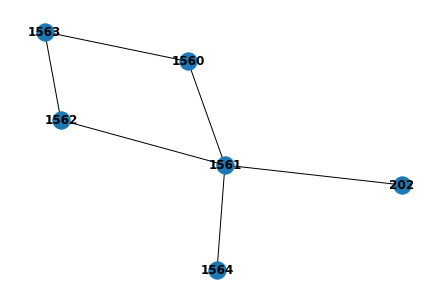

f1_score, ged 0.8333333333333334 3.0


Explain node 1565: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1580.93it/s]


<Figure size 432x288 with 0 Axes>

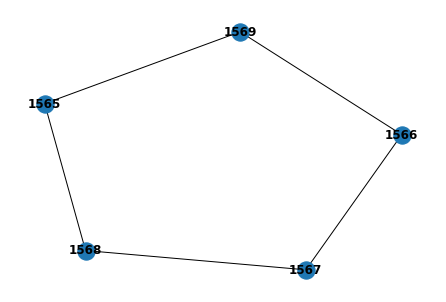

f1_score, ged 0.9090909090909091 1.0


Explain node 1566: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1536.83it/s]


<Figure size 432x288 with 0 Axes>

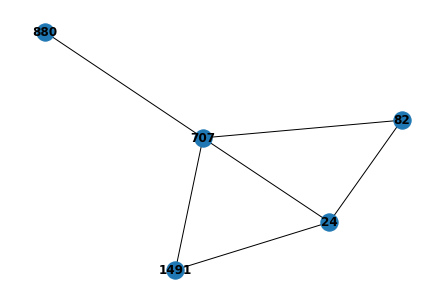

f1_score, ged 0 2.0


Explain node 1567: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1583.46it/s]


<Figure size 432x288 with 0 Axes>

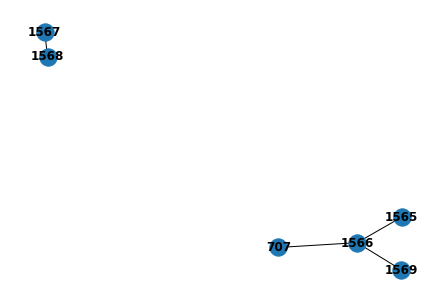

f1_score, ged 0.6 5.0


Explain node 1568: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1620.22it/s]


<Figure size 432x288 with 0 Axes>

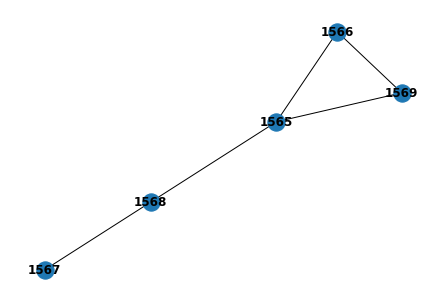

f1_score, ged 0.9090909090909091 1.0


Explain node 1569: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1574.41it/s]


<Figure size 432x288 with 0 Axes>

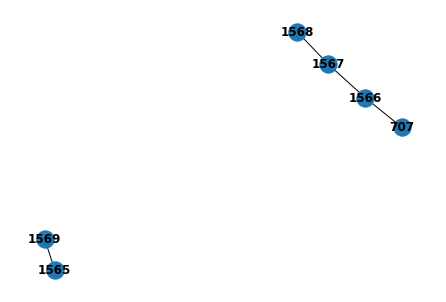

f1_score, ged 0.6 5.0


Explain node 1570: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1620.77it/s]


<Figure size 432x288 with 0 Axes>

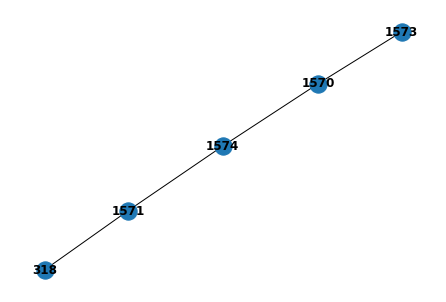

f1_score, ged 0.6 2.0


Explain node 1571: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1530.86it/s]


<Figure size 432x288 with 0 Axes>

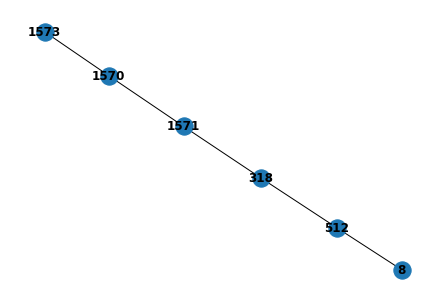

f1_score, ged 0.3636363636363636 4.0


Explain node 1572: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1604.11it/s]


<Figure size 432x288 with 0 Axes>

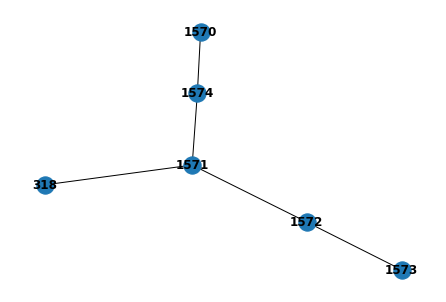

f1_score, ged 0.7272727272727272 4.0


Explain node 1573: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1646.28it/s]


<Figure size 432x288 with 0 Axes>

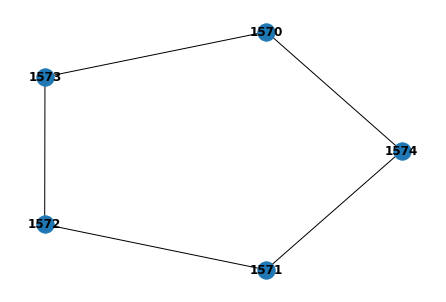

f1_score, ged 0.9090909090909091 1.0


Explain node 1574: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1622.29it/s]


<Figure size 432x288 with 0 Axes>

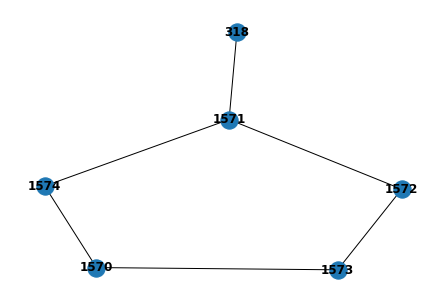

f1_score, ged 0.8333333333333334 3.0


Explain node 1575: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1538.86it/s]


<Figure size 432x288 with 0 Axes>

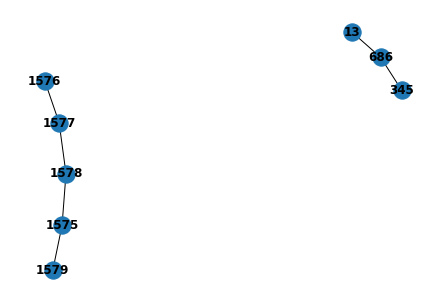

f1_score, ged 0.6666666666666666 7.0


Explain node 1576: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1564.55it/s]


<Figure size 432x288 with 0 Axes>

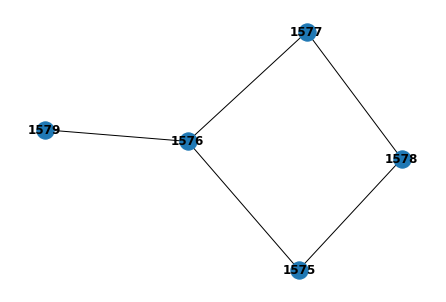

f1_score, ged 0.9090909090909091 1.0


Explain node 1577: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1671.43it/s]


<Figure size 432x288 with 0 Axes>

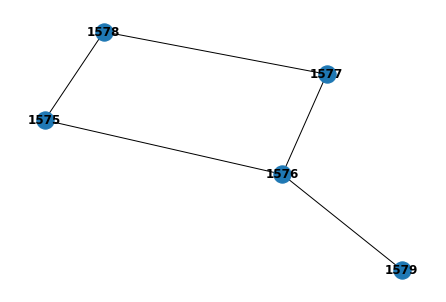

f1_score, ged 0.9090909090909091 1.0


Explain node 1578: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1598.83it/s]


<Figure size 432x288 with 0 Axes>

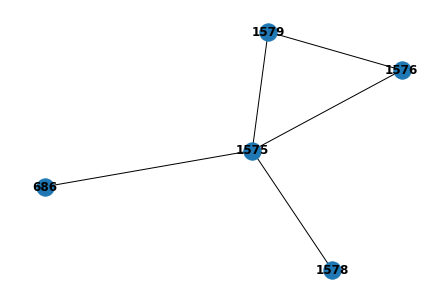

f1_score, ged 0.7272727272727272 3.0


Explain node 1579: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1652.60it/s]


<Figure size 432x288 with 0 Axes>

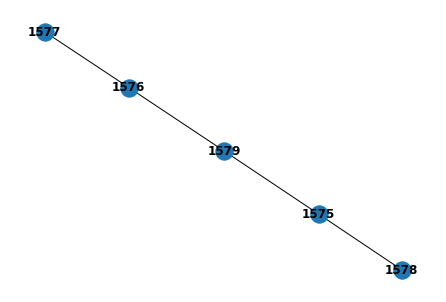

f1_score, ged 0.8 2.0


Explain node 1580: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1435.79it/s]


<Figure size 432x288 with 0 Axes>

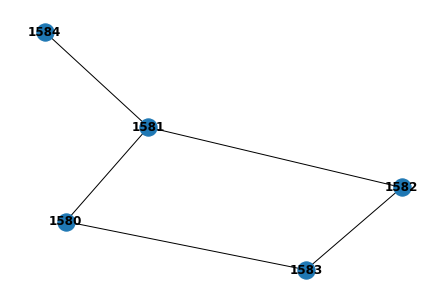

f1_score, ged 0.9090909090909091 1.0


Explain node 1581: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1543.64it/s]


<Figure size 432x288 with 0 Axes>

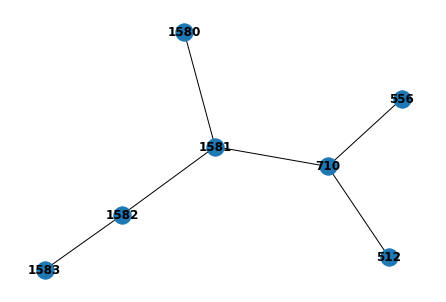

f1_score, ged 0.5 6.0


Explain node 1582: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1588.84it/s]


<Figure size 432x288 with 0 Axes>

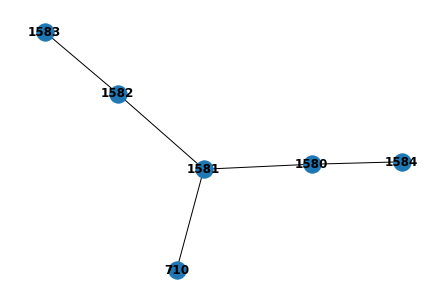

f1_score, ged 0.7272727272727272 4.0


Explain node 1583: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1614.89it/s]


<Figure size 432x288 with 0 Axes>

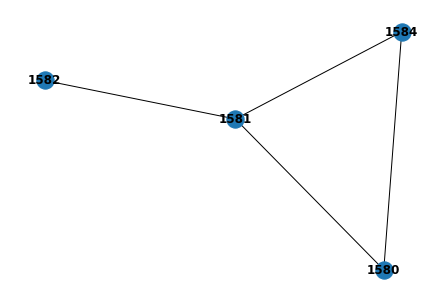

f1_score, ged 0.8 3.0


Explain node 1584: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1411.87it/s]


<Figure size 432x288 with 0 Axes>

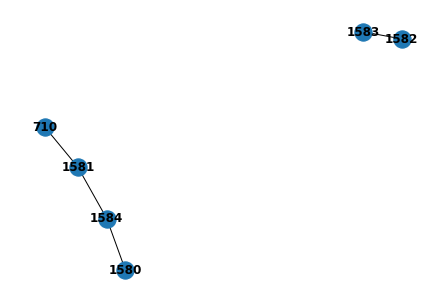

f1_score, ged 0.6 5.0


Explain node 1585: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1522.72it/s]


<Figure size 432x288 with 0 Axes>

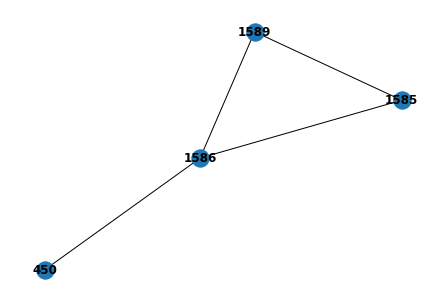

f1_score, ged 0.6 3.0


Explain node 1586: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1553.66it/s]


<Figure size 432x288 with 0 Axes>

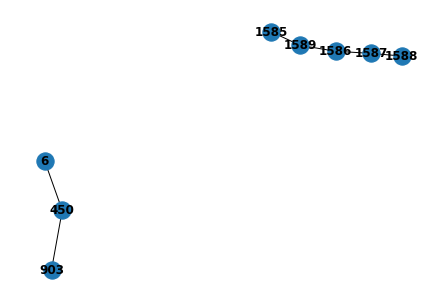

f1_score, ged 0.6666666666666666 7.0


Explain node 1587: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1452.07it/s]


<Figure size 432x288 with 0 Axes>

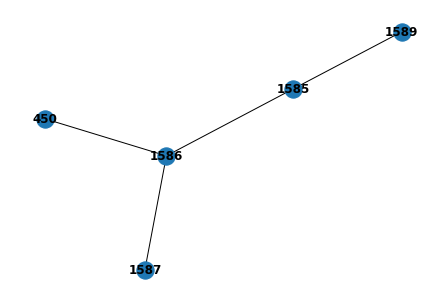

f1_score, ged 0.6 2.0


Explain node 1588: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1572.53it/s]


<Figure size 432x288 with 0 Axes>

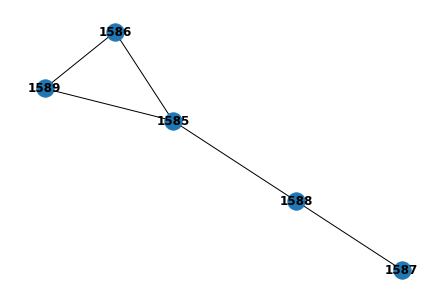

f1_score, ged 0.9090909090909091 1.0


Explain node 1589: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1558.18it/s]


<Figure size 432x288 with 0 Axes>

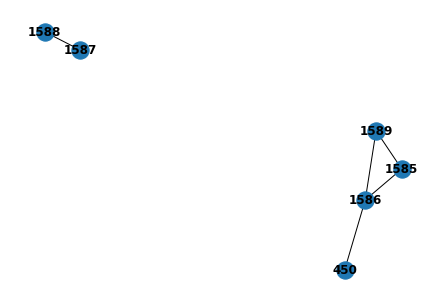

f1_score, ged 0.7272727272727272 4.0


Explain node 1590: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1569.77it/s]


<Figure size 432x288 with 0 Axes>

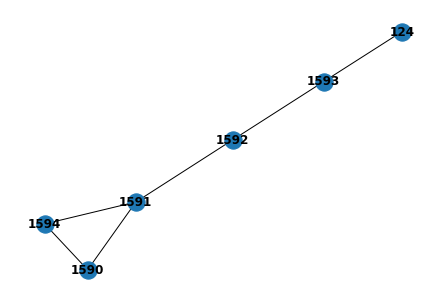

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [684]:
from torch_geometric.nn import GNNExplainer

list_node_idx = range(n_basis,n_basis+5*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

explainer = GNNExplainer(model)
for node_idx in list_node_idx:
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, x = data.x, edge_index = data.edge_index)
    node_feat_mask, edge_mask = node_feat_mask.detach().numpy(), edge_mask.detach().numpy()
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [662]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.7002188552188553

In [666]:
from captum._utils.common import (
    _format_additional_forward_args,
    _format_input,
    _format_output,
)
from captum._utils.gradient import (
    apply_gradient_requirements,
    compute_layer_gradients_and_eval,
    undo_gradient_requirements,
)
from captum._utils.typing import TargetType
from captum.attr import Saliency, IntegratedGradients, LayerGradCam

In [690]:
def mask_to_directed(edge_mask, edge_index):
    directed_edge_mask = edge_mask.copy()
    for i, (u, v) in enumerate(edge_index.t().tolist()):
        if u > v:
            directed_edge_mask[i]=0
    return directed_edge_mask

In [685]:
def model_forward(edge_mask, model, node_idx, x, edge_index):
    out = model(x, edge_index, edge_mask)
    return out[[node_idx]]

def model_forward_node(x, model, edge_index, node_idx):
    out = model(x, edge_index)
    return out[[node_idx]]

def node_attr_to_edge(edge_index, node_mask):
    edge_mask = np.zeros(edge_index.shape[1])
    edge_mask += node_mask[edge_index[0].cpu().numpy()]
    edge_mask += node_mask[edge_index[1].cpu().numpy()]
    return edge_mask

In [686]:
def explain_sa(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward)
    input_mask = torch.ones(edge_index.shape[1]).requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target,
                                       additional_forward_args=(model, node_idx, x, edge_index), abs=False)

    edge_mask = saliency_mask.cpu().numpy()
    return edge_mask

def explain_sa_node(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                                       abs=False)

    node_attr = saliency_mask.cpu().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

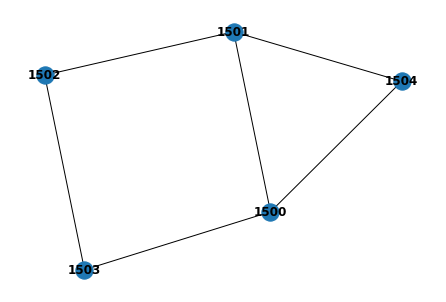

tensor([[1501, 1500, 1500, 1501, 1500, 1502],
        [1504, 1504, 1501, 1502, 1503, 1503]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

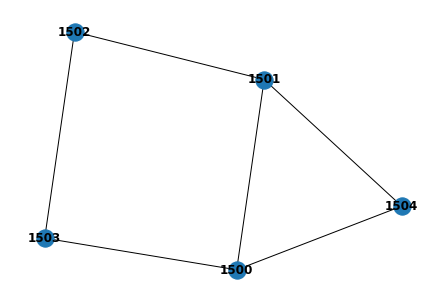

tensor([[1501, 1500, 1501, 1500, 1500, 1502],
        [1504, 1501, 1502, 1504, 1503, 1503]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

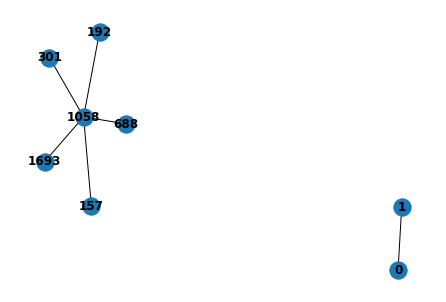

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

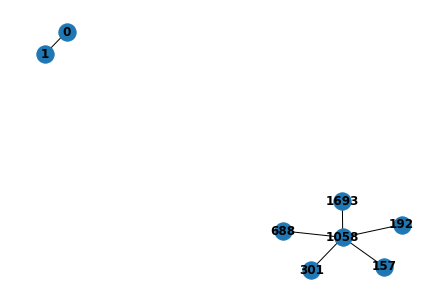

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

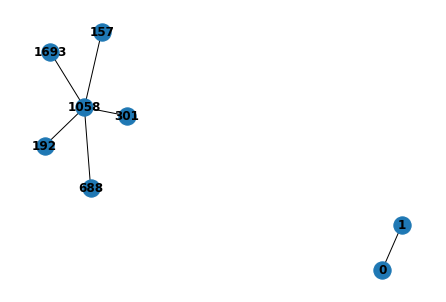

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

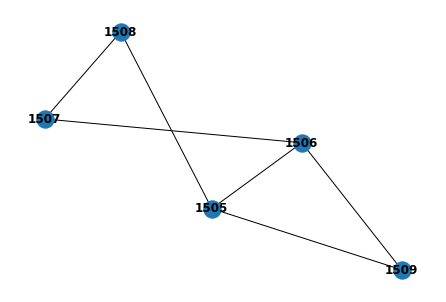

tensor([[1505, 1505, 1505, 1506, 1506, 1507],
        [1506, 1509, 1508, 1509, 1507, 1508]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

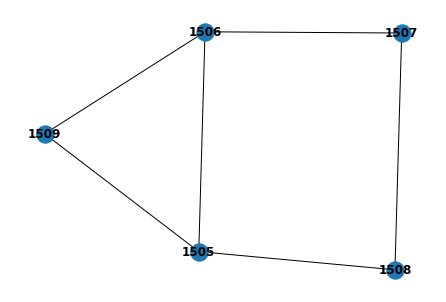

tensor([[1505, 1506, 1506, 1505, 1505, 1507],
        [1506, 1509, 1507, 1509, 1508, 1508]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

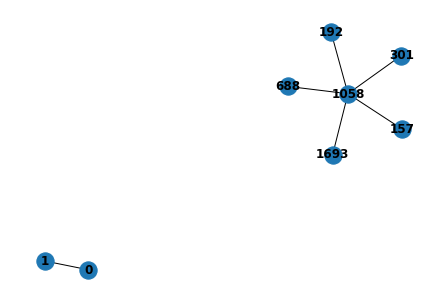

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

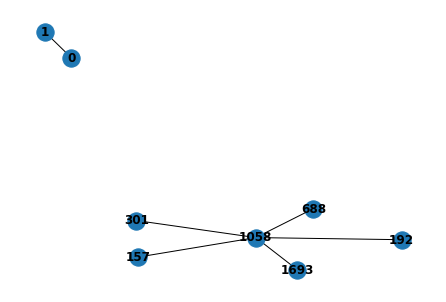

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

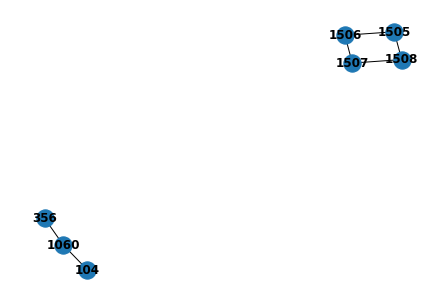

tensor([[1505, 1505, 1506, 1507, 1060, 1060],
        [1506, 1508, 1507, 1508,  356,  104]])
f1_score, ged 0.6666666666666666 6.0


<Figure size 432x288 with 0 Axes>

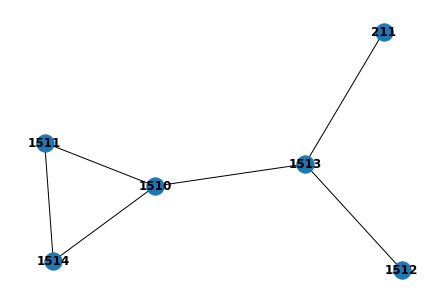

tensor([[1510,  211, 1510, 1510, 1511, 1512],
        [1513, 1513, 1514, 1511, 1514, 1513]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

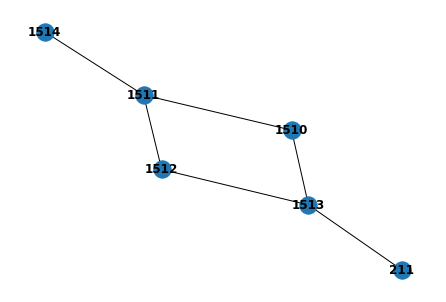

tensor([[1510, 1511, 1510,  211, 1512, 1511],
        [1513, 1514, 1511, 1513, 1513, 1512]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

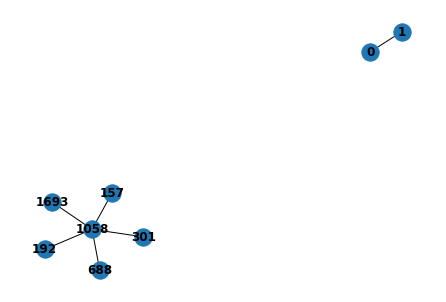

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

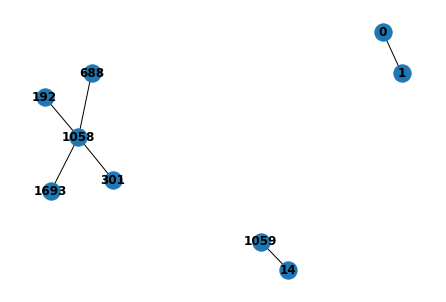

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

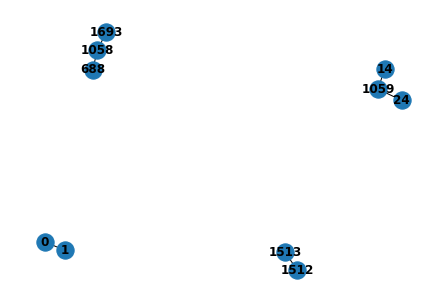

tensor([[1512,    0, 1059, 1059, 1058, 1058],
        [1513,    1,   24,   14, 1693,  688]])
f1_score, ged 0.16666666666666666 11.0


<Figure size 432x288 with 0 Axes>

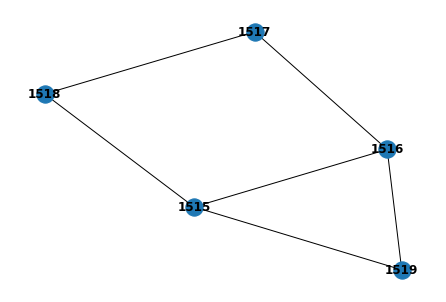

tensor([[1515, 1515, 1516, 1515, 1516, 1517],
        [1519, 1516, 1517, 1518, 1519, 1518]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

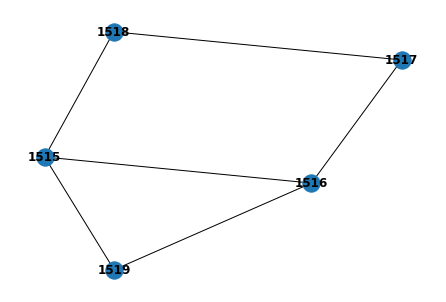

tensor([[1516, 1516, 1515, 1515, 1517, 1515],
        [1517, 1519, 1516, 1519, 1518, 1518]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

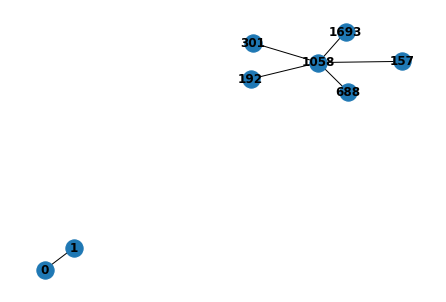

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

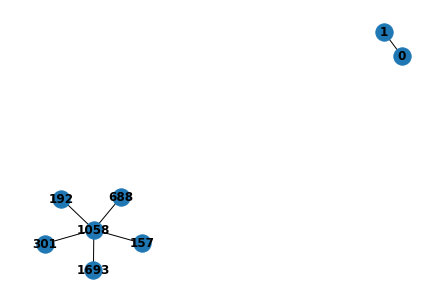

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

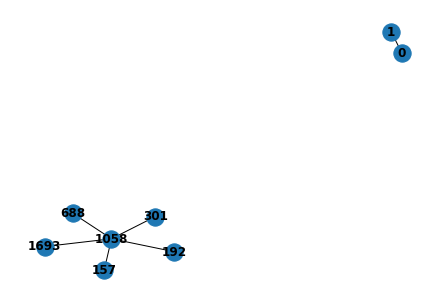

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

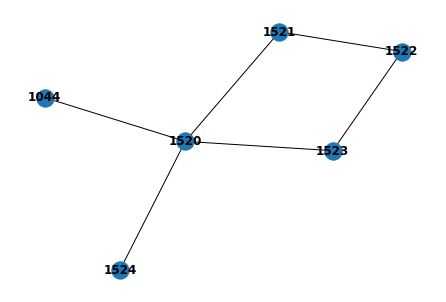

tensor([[1521, 1520, 1520, 1522, 1520, 1044],
        [1522, 1524, 1521, 1523, 1523, 1520]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

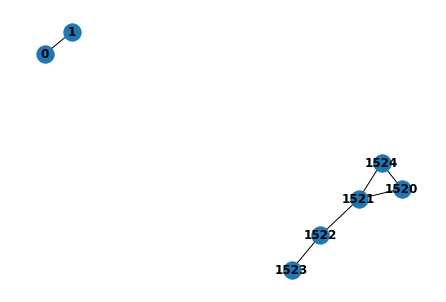

tensor([[1521, 1521, 1522, 1520, 1520,    0],
        [1522, 1524, 1523, 1521, 1524,    1]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

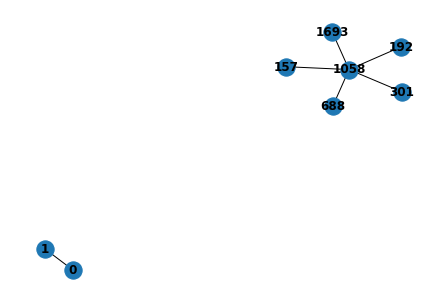

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

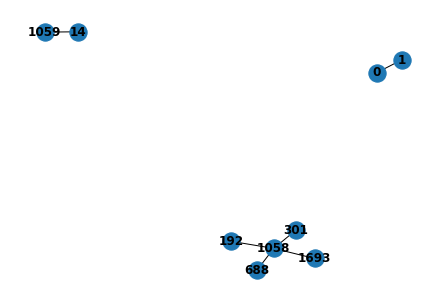

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

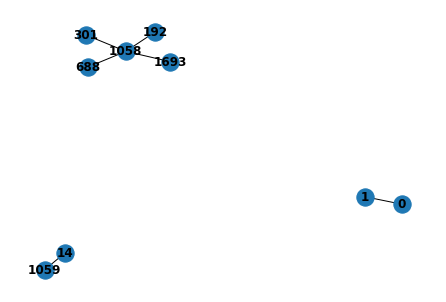

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

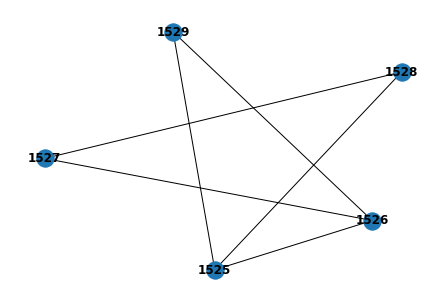

tensor([[1525, 1525, 1525, 1526, 1526, 1527],
        [1529, 1526, 1528, 1529, 1527, 1528]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

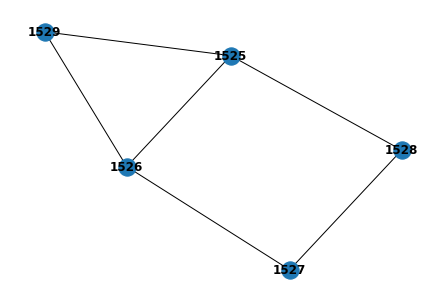

tensor([[1525, 1526, 1526, 1525, 1525, 1527],
        [1526, 1529, 1527, 1529, 1528, 1528]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

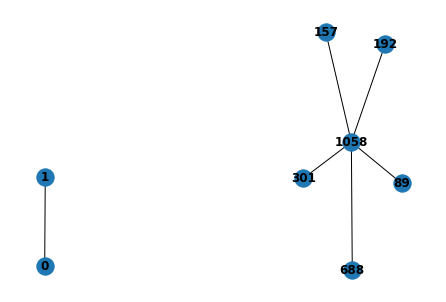

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

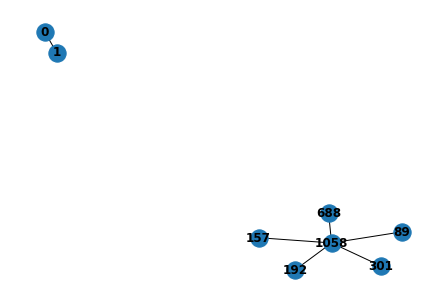

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

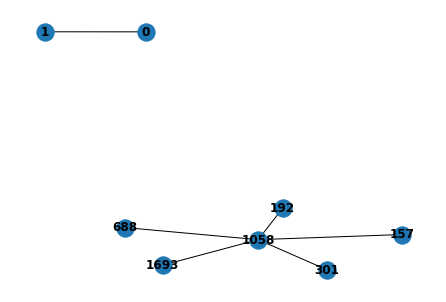

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

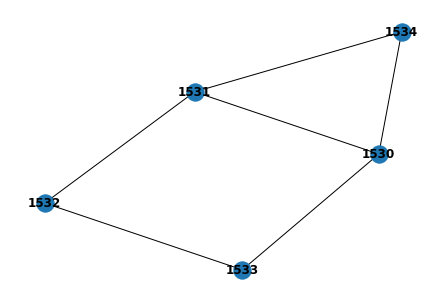

tensor([[1530, 1530, 1530, 1531, 1531, 1532],
        [1534, 1531, 1533, 1534, 1532, 1533]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

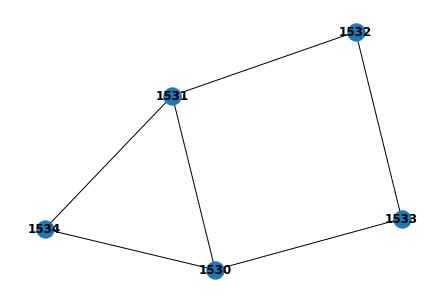

tensor([[1531, 1530, 1531, 1530, 1530, 1532],
        [1534, 1531, 1532, 1534, 1533, 1533]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

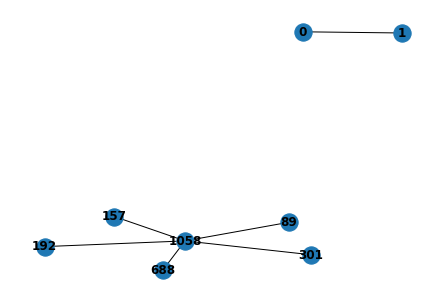

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

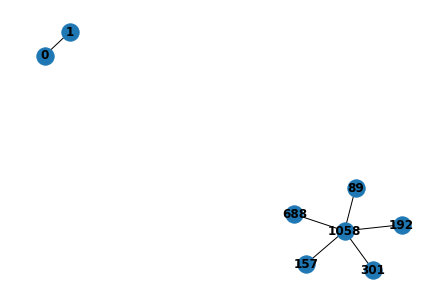

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

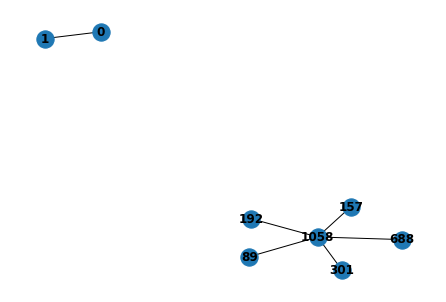

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

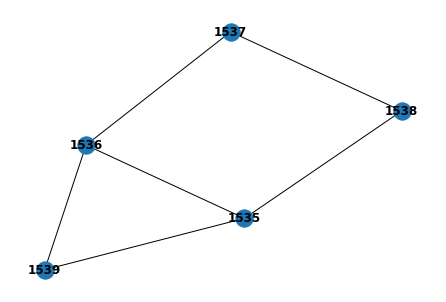

tensor([[1536, 1535, 1535, 1537, 1535, 1536],
        [1537, 1539, 1536, 1538, 1538, 1539]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

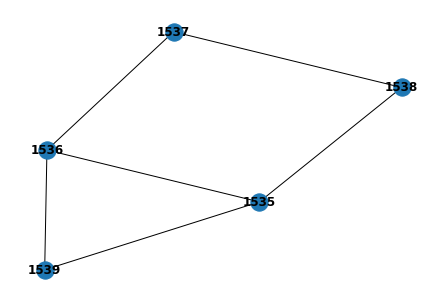

tensor([[1536, 1536, 1535, 1537, 1535, 1535],
        [1537, 1539, 1536, 1538, 1539, 1538]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

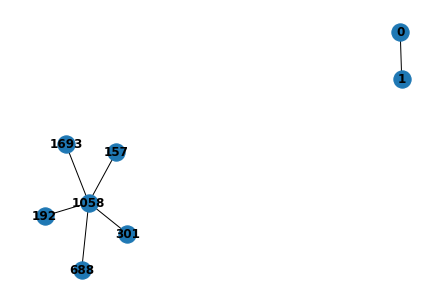

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

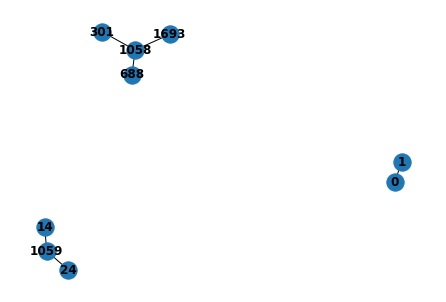

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

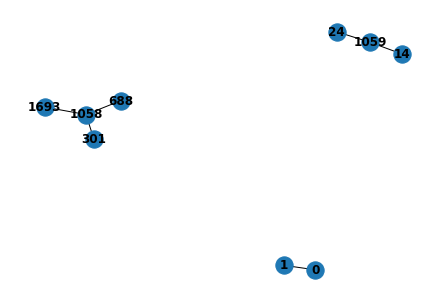

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

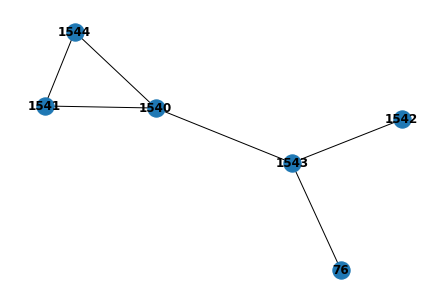

tensor([[1540, 1540,   76, 1540, 1541, 1542],
        [1543, 1544, 1543, 1541, 1544, 1543]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

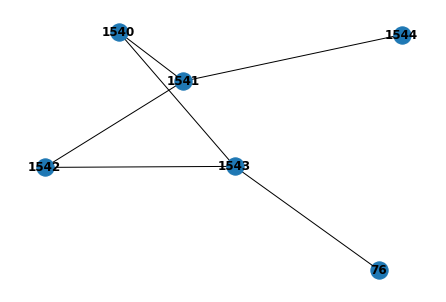

tensor([[1540, 1541, 1540,   76, 1542, 1541],
        [1543, 1544, 1541, 1543, 1543, 1542]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

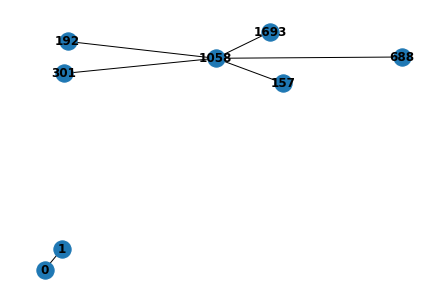

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

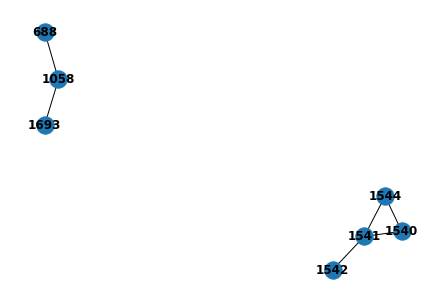

tensor([[1541, 1540, 1541, 1540, 1058, 1058],
        [1542, 1541, 1544, 1544,  688, 1693]])
f1_score, ged 0.6666666666666666 6.0


<Figure size 432x288 with 0 Axes>

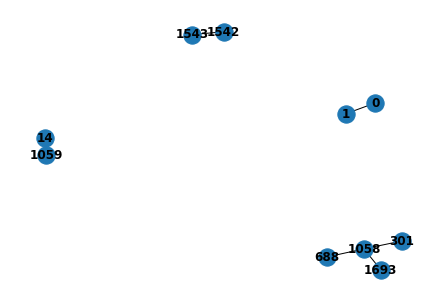

tensor([[1542,    0, 1059, 1058, 1058, 1058],
        [1543,    1,   14, 1693,  688,  301]])
f1_score, ged 0.16666666666666666 11.0


<Figure size 432x288 with 0 Axes>

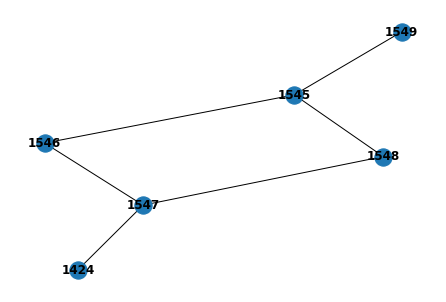

tensor([[1546, 1545, 1545, 1424, 1547, 1545],
        [1547, 1549, 1546, 1547, 1548, 1548]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

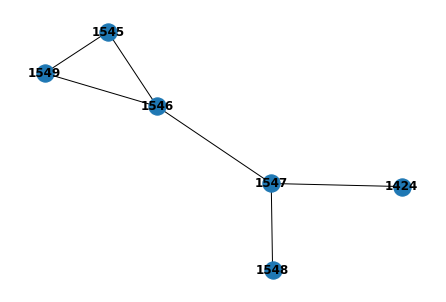

tensor([[1546, 1424, 1546, 1545, 1545, 1547],
        [1547, 1547, 1549, 1546, 1549, 1548]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

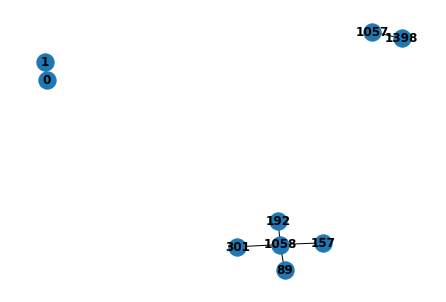

tensor([[   0, 1058, 1058, 1058, 1058, 1057],
        [   1,  301,  192,  157,   89, 1398]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

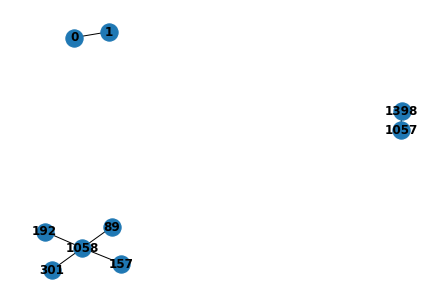

tensor([[   0, 1058, 1058, 1058, 1058, 1057],
        [   1,  301,  192,  157,   89, 1398]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

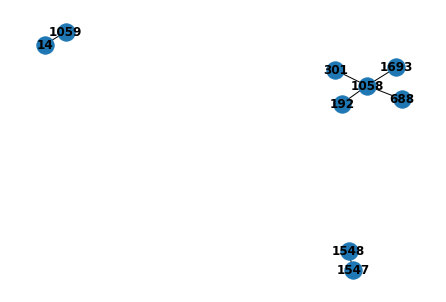

tensor([[1547, 1059, 1058, 1058, 1058, 1058],
        [1548,   14, 1693,  688,  301,  192]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

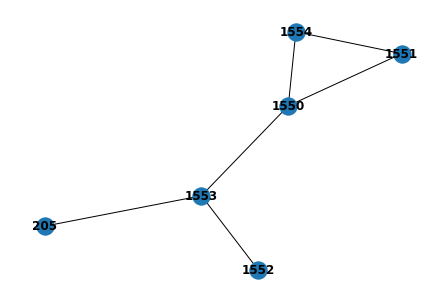

tensor([[1550,  205, 1550, 1550, 1551, 1552],
        [1553, 1553, 1554, 1551, 1554, 1553]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

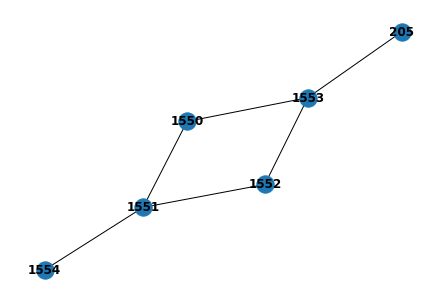

tensor([[1550, 1551, 1550,  205, 1552, 1551],
        [1553, 1554, 1551, 1553, 1553, 1552]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

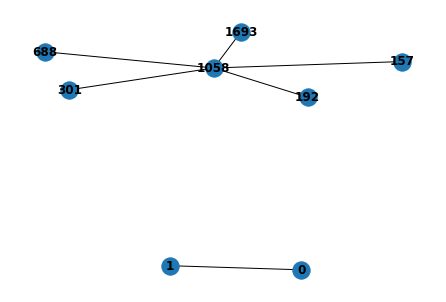

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

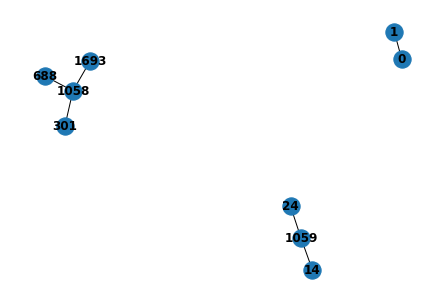

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

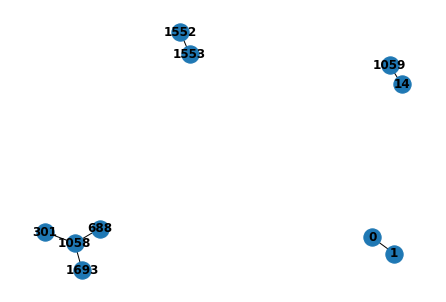

tensor([[1552,    0, 1059, 1058, 1058, 1058],
        [1553,    1,   14, 1693,  688,  301]])
f1_score, ged 0.16666666666666666 11.0


<Figure size 432x288 with 0 Axes>

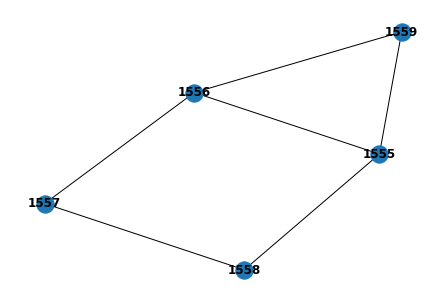

tensor([[1555, 1555, 1555, 1556, 1556, 1557],
        [1556, 1559, 1558, 1559, 1557, 1558]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

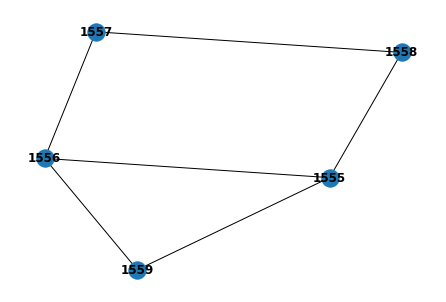

tensor([[1555, 1556, 1556, 1555, 1555, 1557],
        [1556, 1559, 1557, 1559, 1558, 1558]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

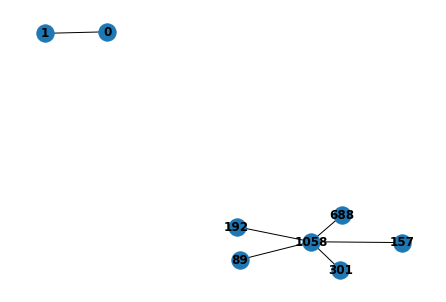

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

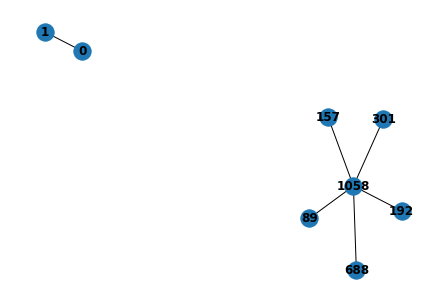

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

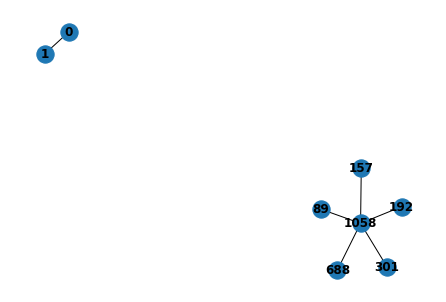

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

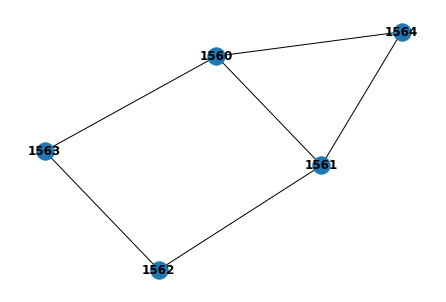

tensor([[1560, 1560, 1560, 1562, 1561, 1561],
        [1563, 1564, 1561, 1563, 1564, 1562]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

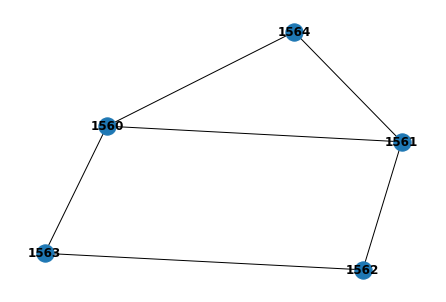

tensor([[1561, 1560, 1560, 1561, 1562, 1560],
        [1564, 1561, 1563, 1562, 1563, 1564]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

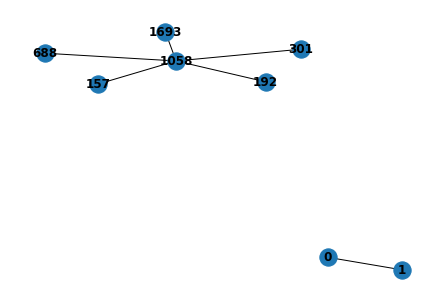

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

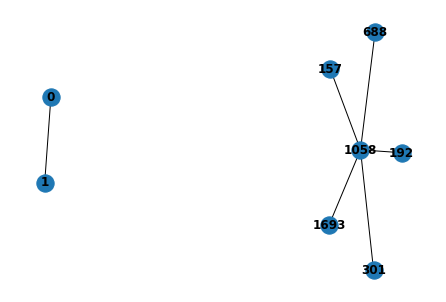

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

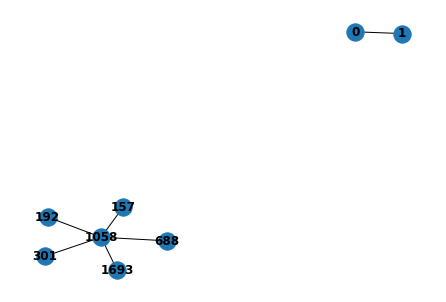

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

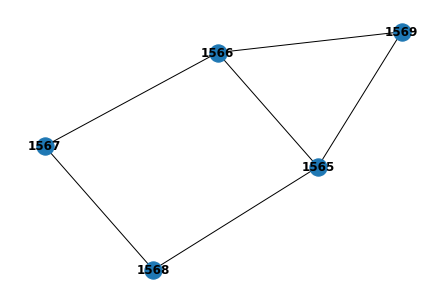

tensor([[1565, 1565, 1565, 1567, 1566, 1566],
        [1568, 1569, 1566, 1568, 1569, 1567]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

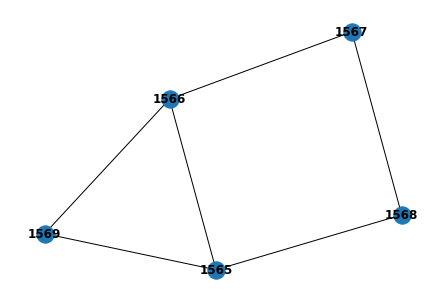

tensor([[1566, 1565, 1565, 1566, 1565, 1567],
        [1569, 1566, 1568, 1567, 1569, 1568]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

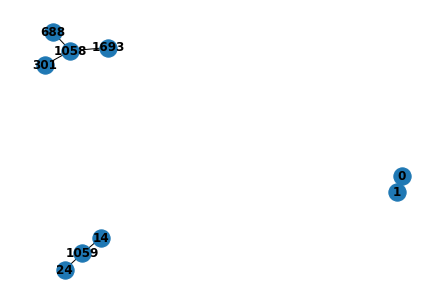

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

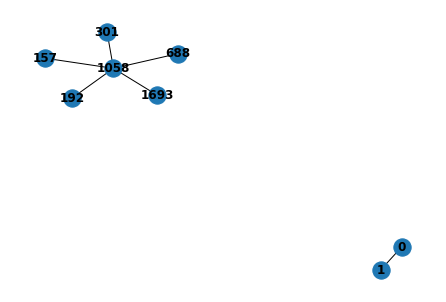

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

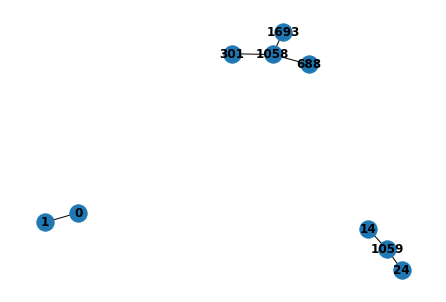

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

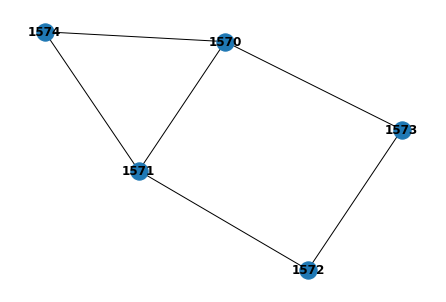

tensor([[1570, 1570, 1570, 1571, 1572, 1571],
        [1574, 1573, 1571, 1574, 1573, 1572]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

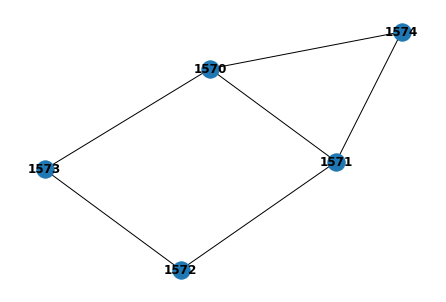

tensor([[1571, 1570, 1571, 1570, 1570, 1572],
        [1574, 1571, 1572, 1574, 1573, 1573]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

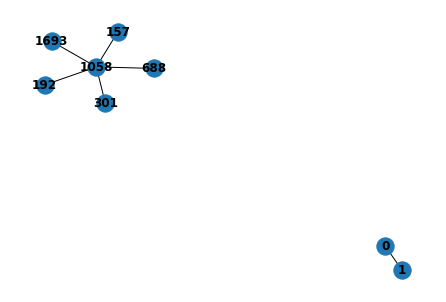

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

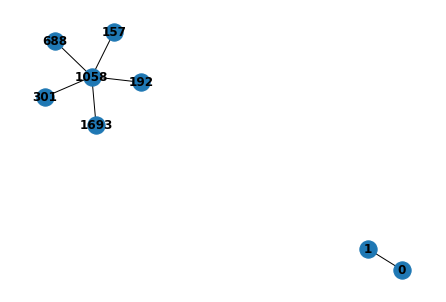

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

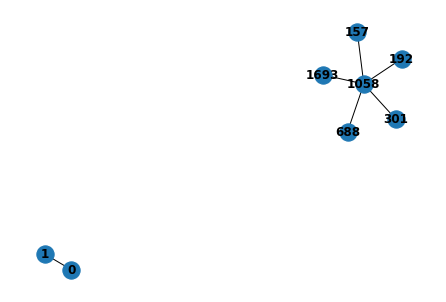

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

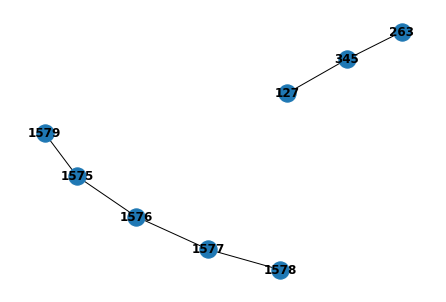

tensor([[1576, 1575, 1575, 1577,  127,  263],
        [1577, 1576, 1579, 1578,  345,  345]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

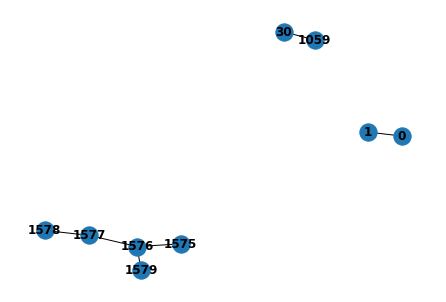

tensor([[1576, 1577, 1575, 1576,    0, 1059],
        [1577, 1578, 1576, 1579,    1,   30]])
f1_score, ged 0.6666666666666666 8.0


<Figure size 432x288 with 0 Axes>

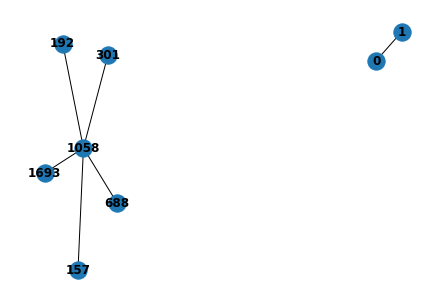

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

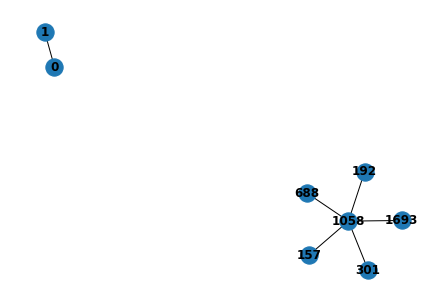

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

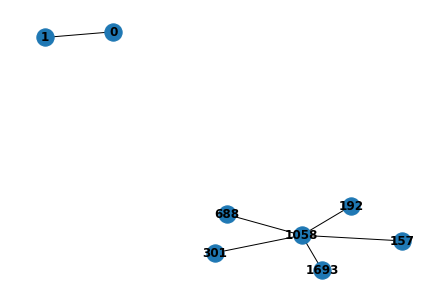

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

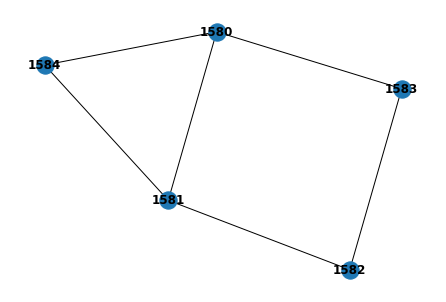

tensor([[1580, 1580, 1580, 1582, 1581, 1581],
        [1583, 1584, 1581, 1583, 1584, 1582]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

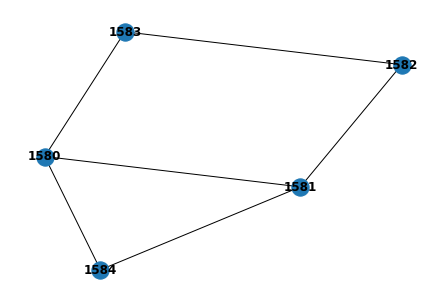

tensor([[1580, 1581, 1580, 1582, 1581, 1580],
        [1583, 1584, 1581, 1583, 1582, 1584]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

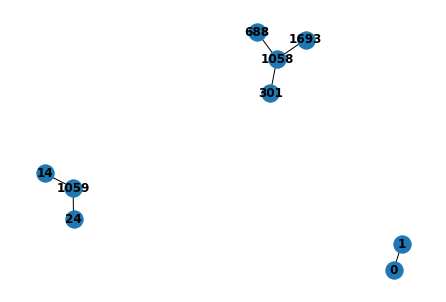

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

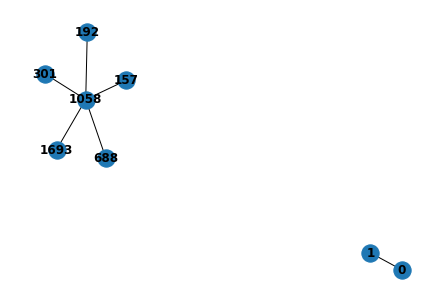

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

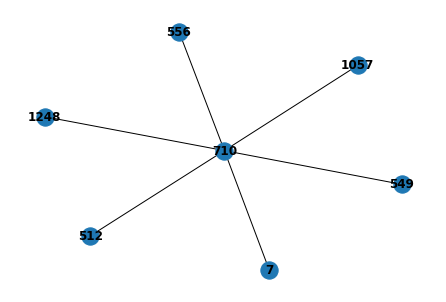

tensor([[ 549,  512,  556,  710,  710,    7],
        [ 710,  710,  710, 1248, 1057,  710]])
f1_score, ged 0 8.0


<Figure size 432x288 with 0 Axes>

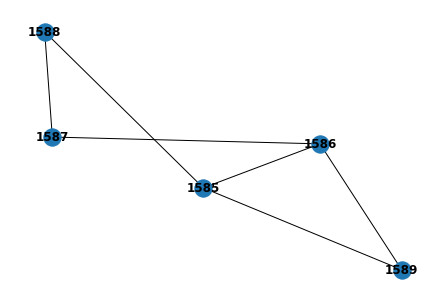

tensor([[1585, 1585, 1585, 1587, 1586, 1586],
        [1588, 1589, 1586, 1588, 1589, 1587]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

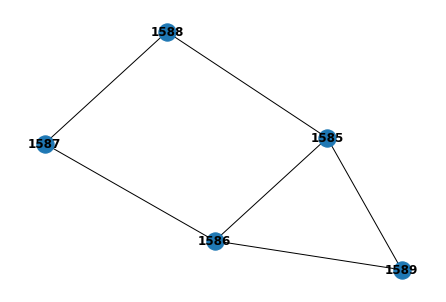

tensor([[1585, 1586, 1585, 1587, 1586, 1585],
        [1588, 1589, 1586, 1588, 1587, 1589]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

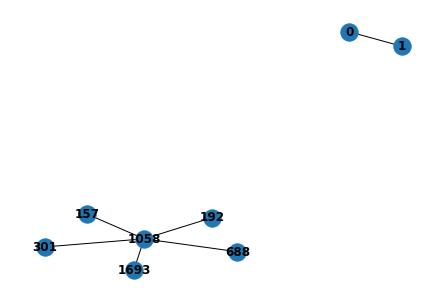

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

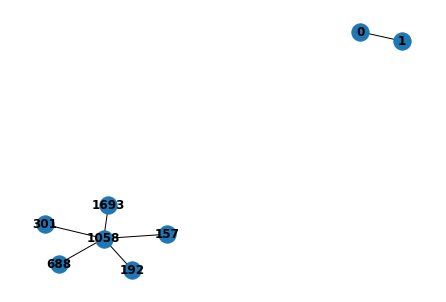

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

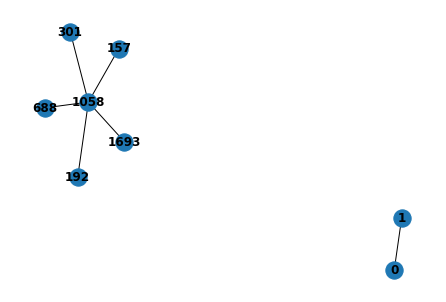

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

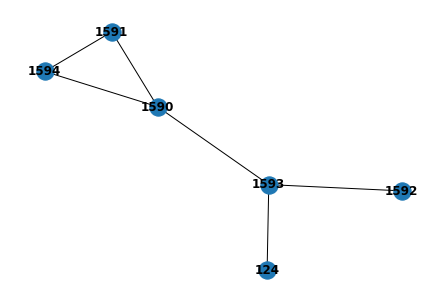

tensor([[1590,  124, 1590, 1590, 1591, 1592],
        [1593, 1593, 1594, 1591, 1594, 1593]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

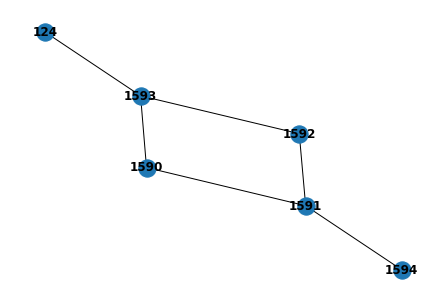

tensor([[1590, 1591, 1590,  124, 1592, 1591],
        [1593, 1594, 1591, 1593, 1593, 1592]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

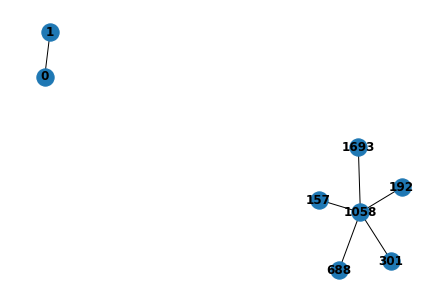

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

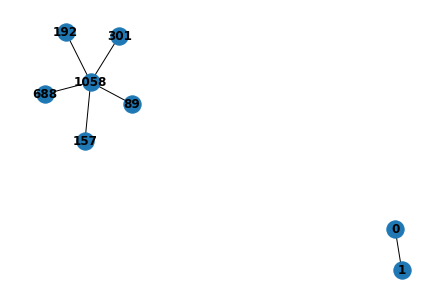

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

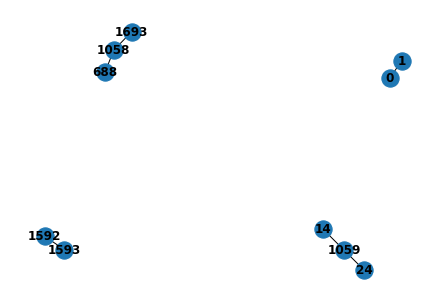

tensor([[1592,    0, 1059, 1059, 1058, 1058],
        [1593,    1,   24,   14, 1693,  688]])
f1_score, ged 0.16666666666666666 11.0


<Figure size 432x288 with 0 Axes>

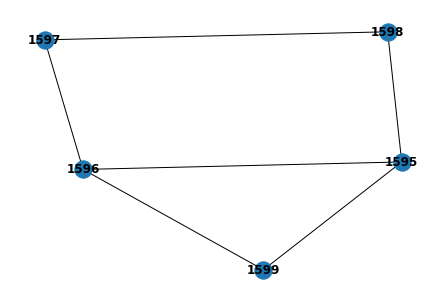

tensor([[1595, 1595, 1595, 1596, 1596, 1597],
        [1596, 1599, 1598, 1599, 1597, 1598]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

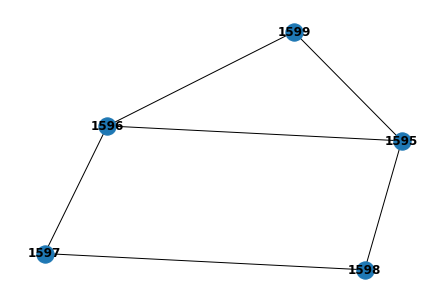

tensor([[1595, 1596, 1596, 1595, 1595, 1597],
        [1596, 1599, 1597, 1599, 1598, 1598]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

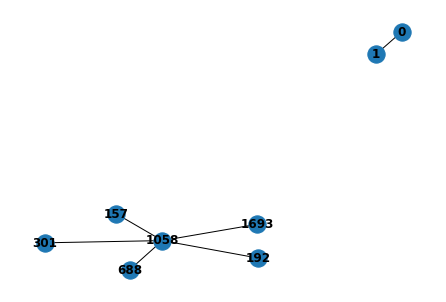

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

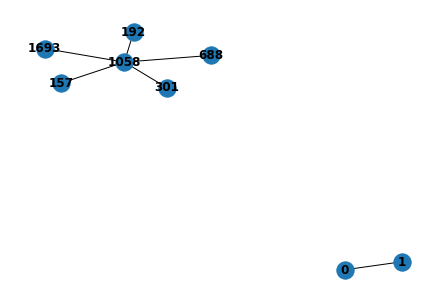

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

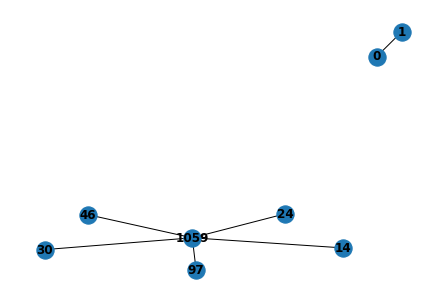

tensor([[   0, 1059, 1059, 1059, 1059, 1059],
        [   1,   97,   46,   30,   24,   14]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

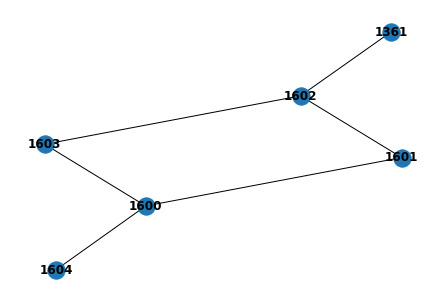

tensor([[1601, 1600, 1600, 1361, 1602, 1600],
        [1602, 1604, 1601, 1602, 1603, 1603]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

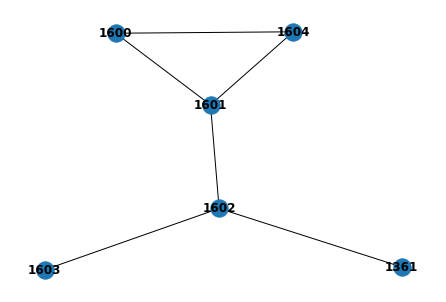

tensor([[1601, 1361, 1601, 1600, 1600, 1602],
        [1602, 1602, 1604, 1601, 1604, 1603]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

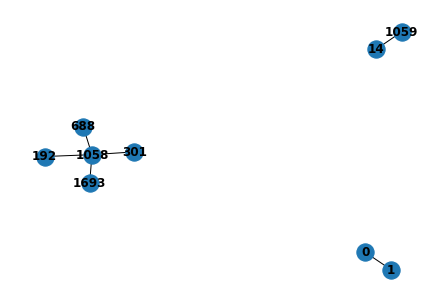

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

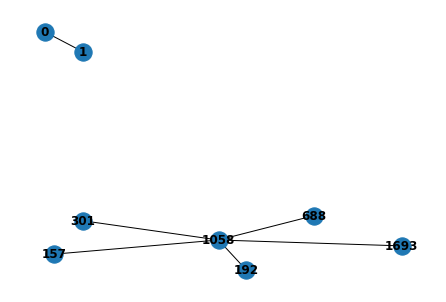

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

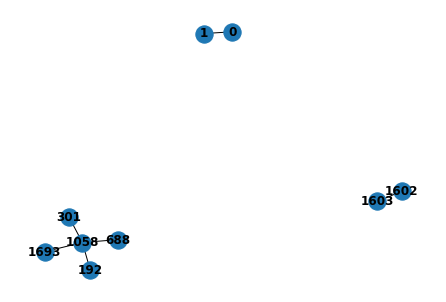

tensor([[1602,    0, 1058, 1058, 1058, 1058],
        [1603,    1, 1693,  688,  301,  192]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

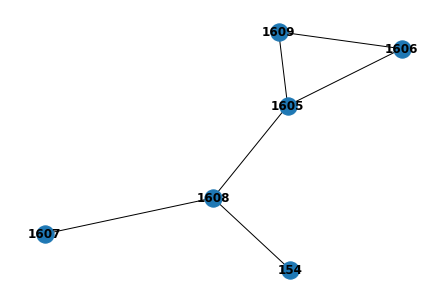

tensor([[1605, 1605,  154, 1605, 1606, 1607],
        [1608, 1609, 1608, 1606, 1609, 1608]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

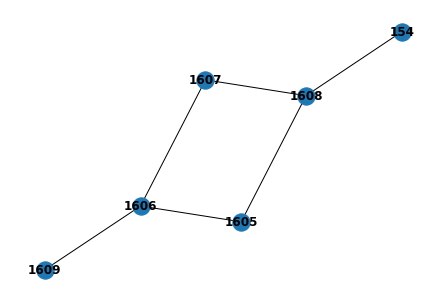

tensor([[1605, 1606, 1605,  154, 1607, 1606],
        [1608, 1609, 1606, 1608, 1608, 1607]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

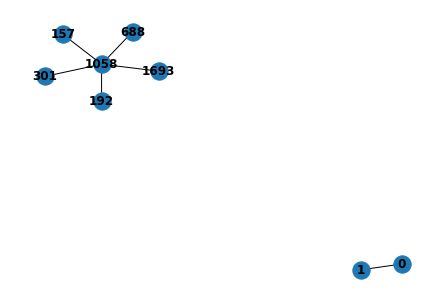

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

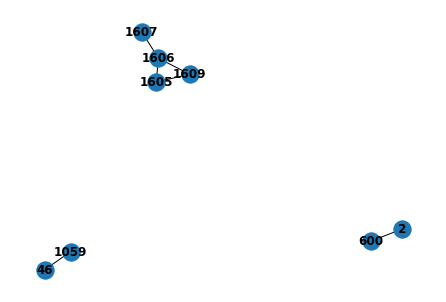

tensor([[1606, 1605, 1606, 1605,  600, 1059],
        [1607, 1606, 1609, 1609,    2,   46]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

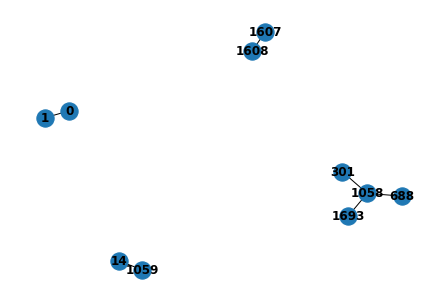

tensor([[1607,    0, 1059, 1058, 1058, 1058],
        [1608,    1,   14, 1693,  688,  301]])
f1_score, ged 0.16666666666666666 11.0


<Figure size 432x288 with 0 Axes>

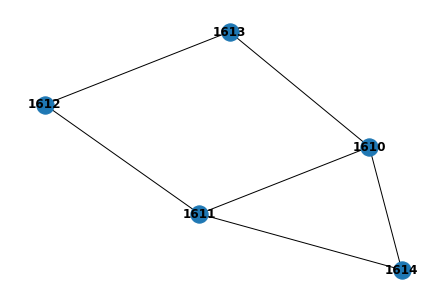

tensor([[1610, 1610, 1610, 1611, 1611, 1612],
        [1611, 1614, 1613, 1614, 1612, 1613]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

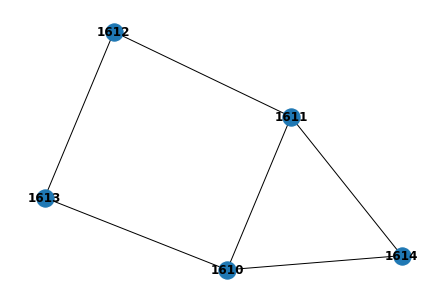

tensor([[1610, 1611, 1611, 1610, 1610, 1612],
        [1611, 1614, 1612, 1614, 1613, 1613]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

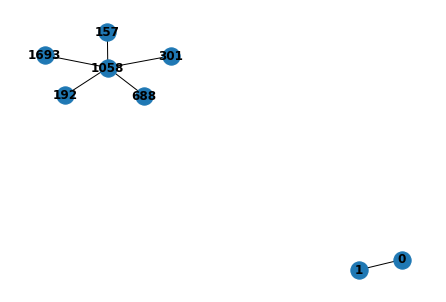

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

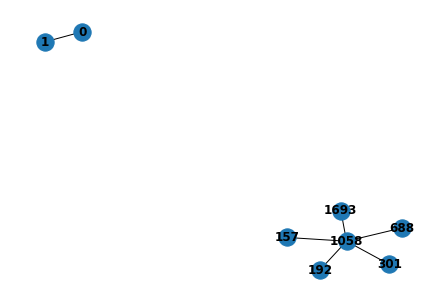

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

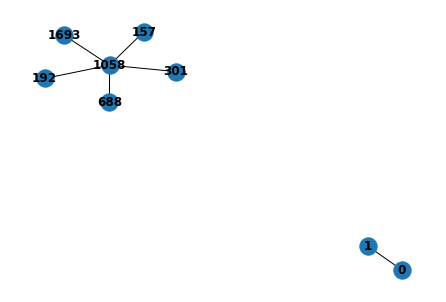

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

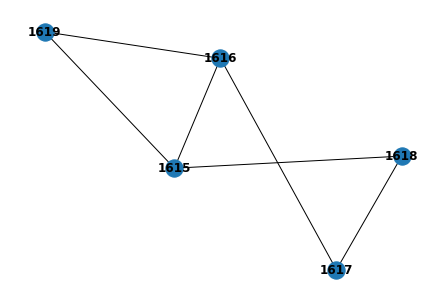

tensor([[1615, 1615, 1615, 1616, 1616, 1617],
        [1619, 1616, 1618, 1619, 1617, 1618]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

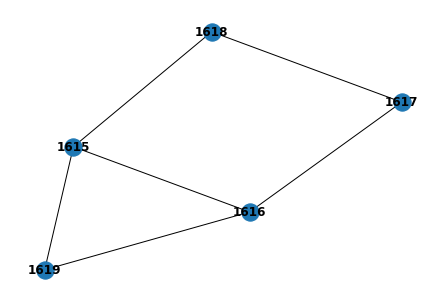

tensor([[1616, 1615, 1616, 1615, 1615, 1617],
        [1619, 1616, 1617, 1619, 1618, 1618]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

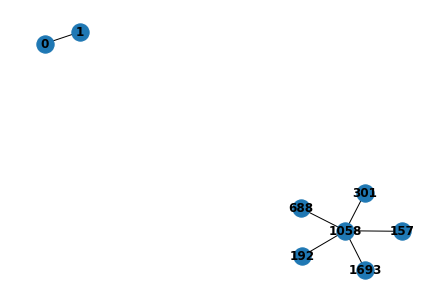

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

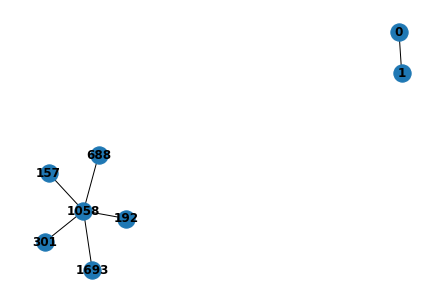

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

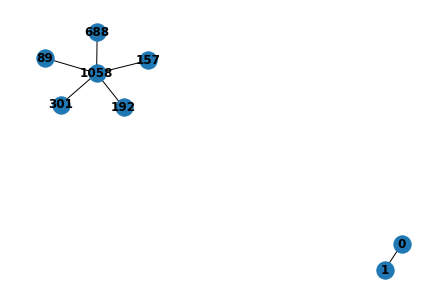

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

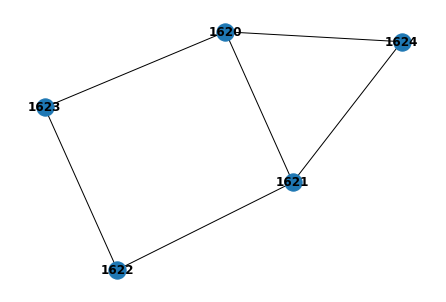

tensor([[1620, 1620, 1620, 1621, 1621, 1622],
        [1621, 1624, 1623, 1624, 1622, 1623]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

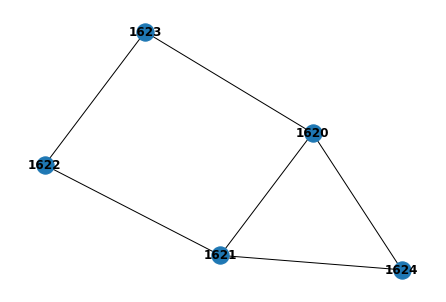

tensor([[1620, 1621, 1621, 1620, 1620, 1622],
        [1621, 1624, 1622, 1624, 1623, 1623]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

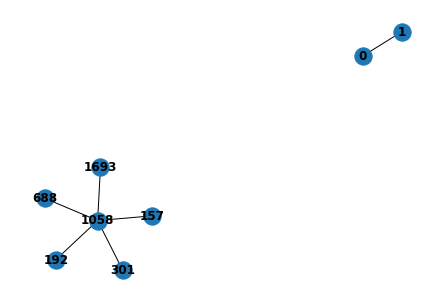

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

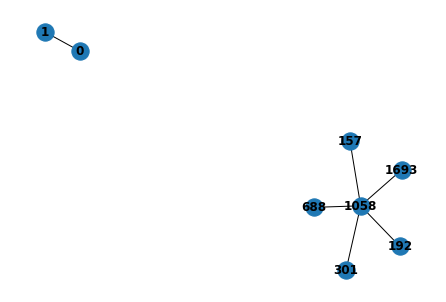

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

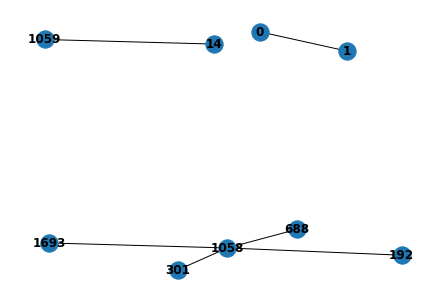

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

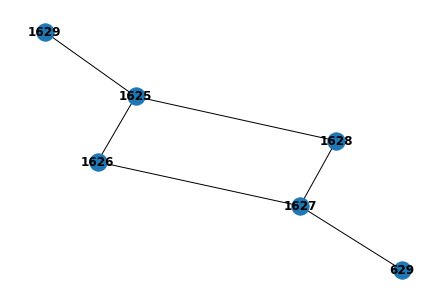

tensor([[1626, 1625, 1625,  629, 1627, 1625],
        [1627, 1629, 1626, 1627, 1628, 1628]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

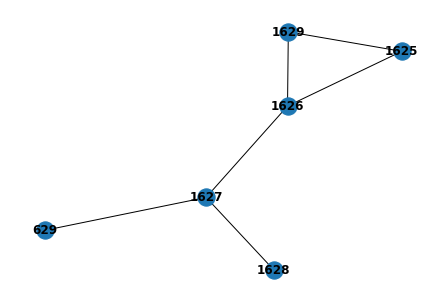

tensor([[1626,  629, 1626, 1625, 1625, 1627],
        [1627, 1627, 1629, 1626, 1629, 1628]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

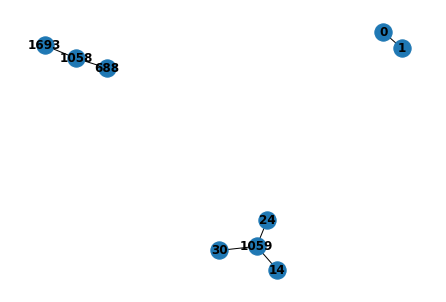

tensor([[   0, 1059, 1059, 1059, 1058, 1058],
        [   1,   30,   24,   14, 1693,  688]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

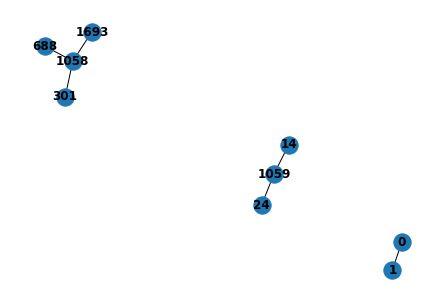

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

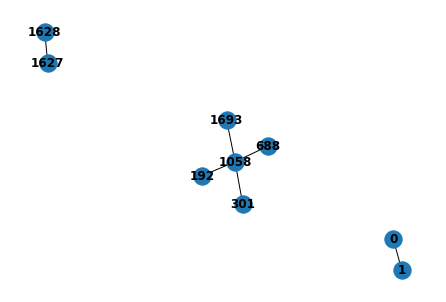

tensor([[1627,    0, 1058, 1058, 1058, 1058],
        [1628,    1, 1693,  688,  301,  192]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

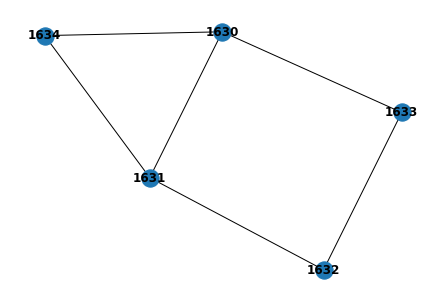

tensor([[1631, 1630, 1630, 1632, 1630, 1631],
        [1632, 1634, 1631, 1633, 1633, 1634]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

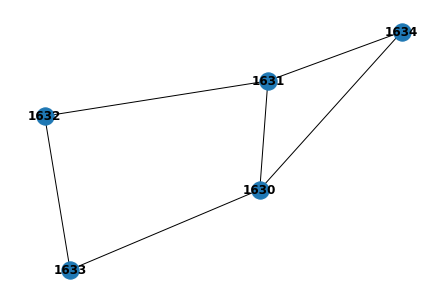

tensor([[1631, 1631, 1630, 1632, 1630, 1630],
        [1632, 1634, 1631, 1633, 1634, 1633]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

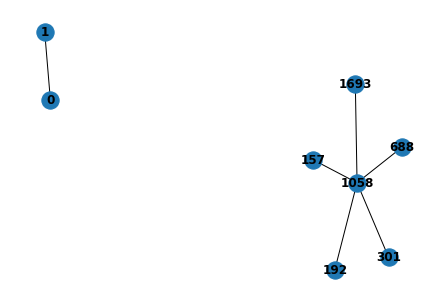

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

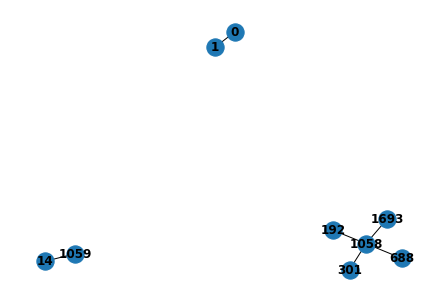

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

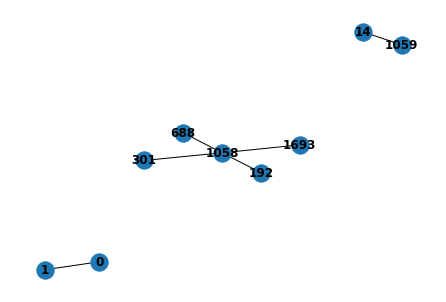

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

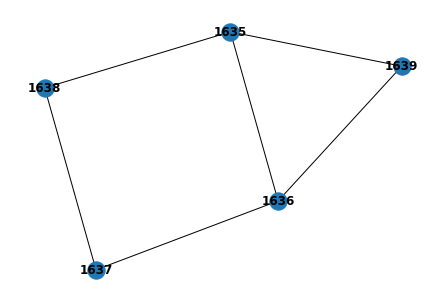

tensor([[1635, 1635, 1635, 1636, 1636, 1637],
        [1639, 1636, 1638, 1639, 1637, 1638]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

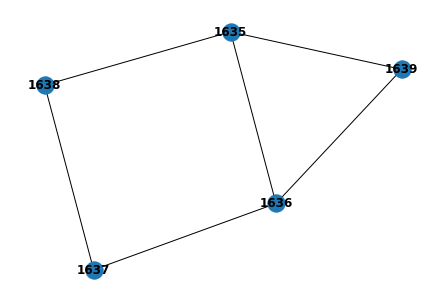

tensor([[1636, 1635, 1635, 1635, 1636, 1637],
        [1639, 1639, 1636, 1638, 1637, 1638]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

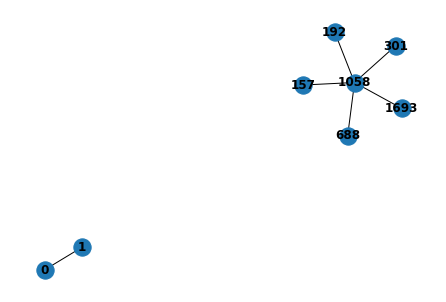

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

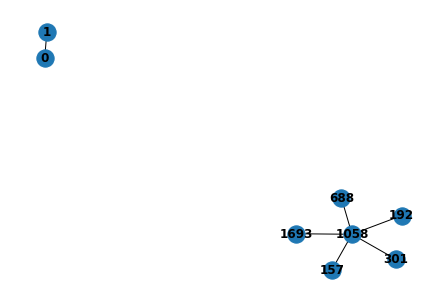

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

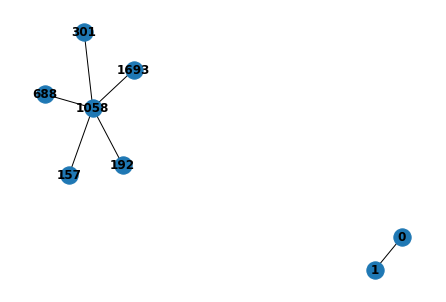

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

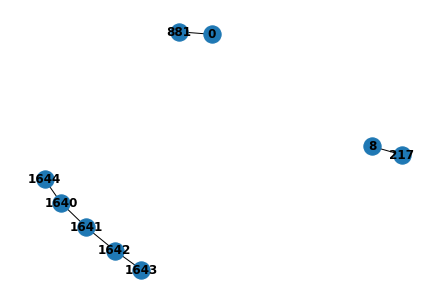

tensor([[1641, 1640, 1640, 1642,    8,    0],
        [1642, 1641, 1644, 1643,  217,  881]])
f1_score, ged 0.6666666666666666 8.0


<Figure size 432x288 with 0 Axes>

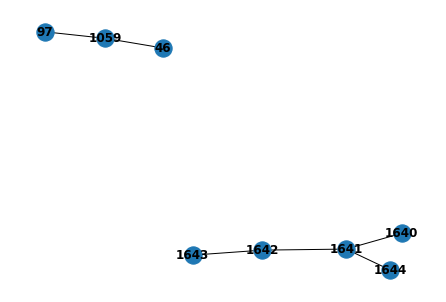

tensor([[1641, 1642, 1640, 1641, 1059, 1059],
        [1642, 1643, 1641, 1644,   97,   46]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

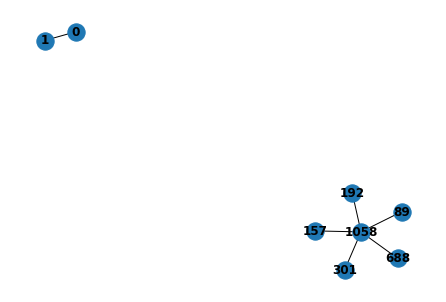

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

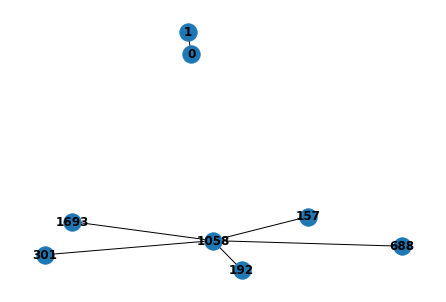

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

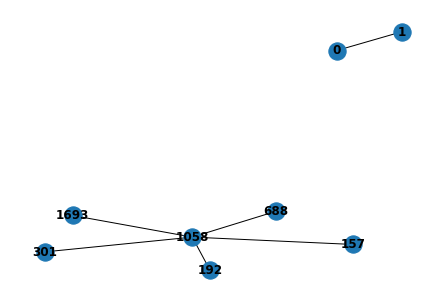

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

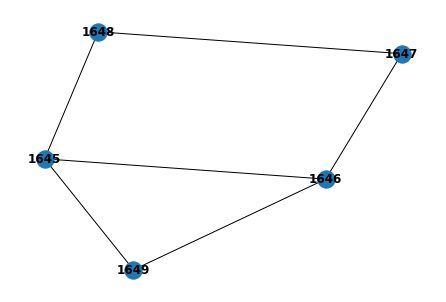

tensor([[1645, 1645, 1646, 1645, 1646, 1647],
        [1649, 1646, 1647, 1648, 1649, 1648]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

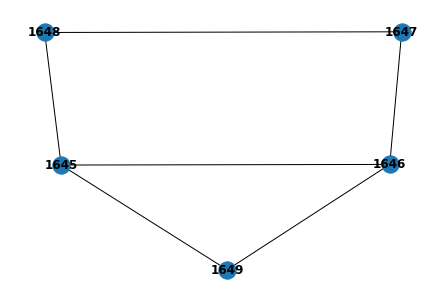

tensor([[1646, 1646, 1645, 1647, 1645, 1645],
        [1647, 1649, 1646, 1648, 1649, 1648]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

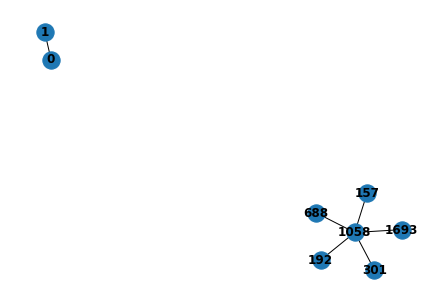

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

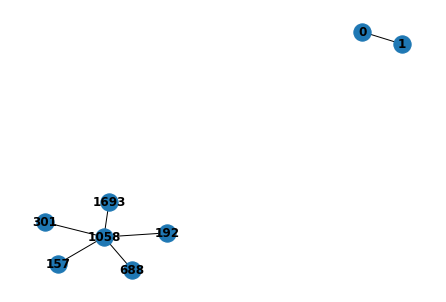

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

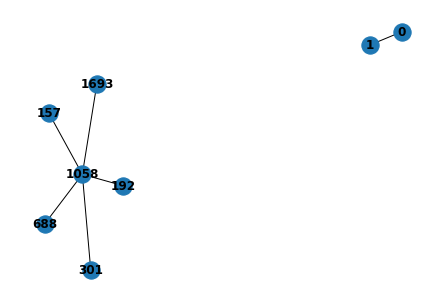

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

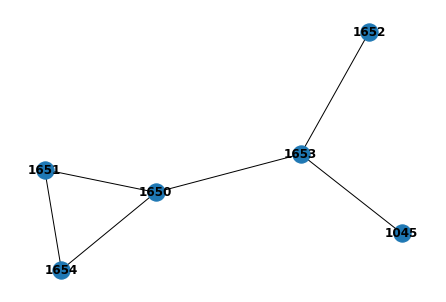

tensor([[1650, 1045, 1650, 1650, 1651, 1652],
        [1653, 1653, 1654, 1651, 1654, 1653]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

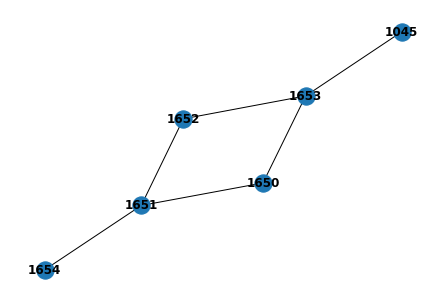

tensor([[1650, 1651, 1650, 1045, 1652, 1651],
        [1653, 1654, 1651, 1653, 1653, 1652]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

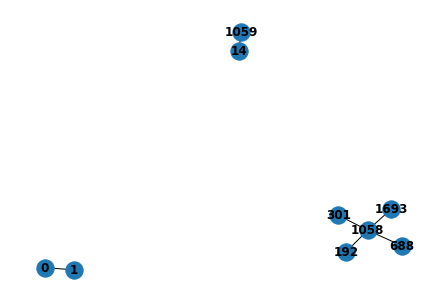

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

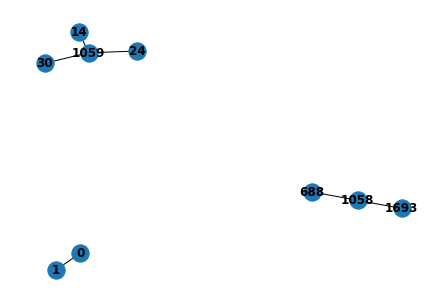

tensor([[   0, 1059, 1059, 1059, 1058, 1058],
        [   1,   30,   24,   14, 1693,  688]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

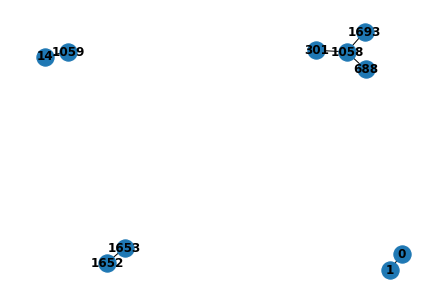

tensor([[1652,    0, 1059, 1058, 1058, 1058],
        [1653,    1,   14, 1693,  688,  301]])
f1_score, ged 0.16666666666666666 11.0


<Figure size 432x288 with 0 Axes>

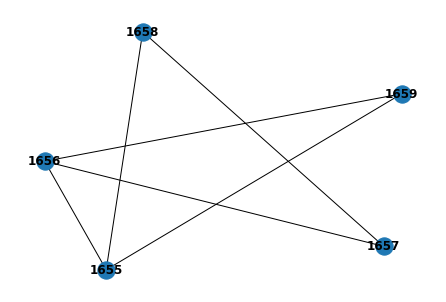

tensor([[1655, 1655, 1655, 1657, 1656, 1656],
        [1658, 1659, 1656, 1658, 1659, 1657]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

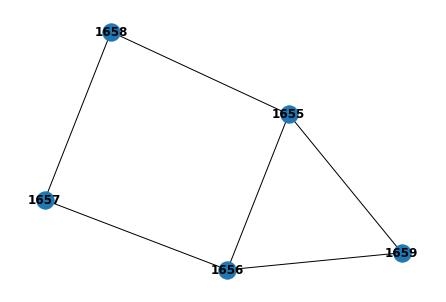

tensor([[1655, 1656, 1655, 1657, 1656, 1655],
        [1658, 1659, 1656, 1658, 1657, 1659]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

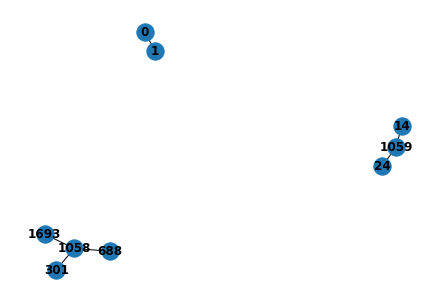

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

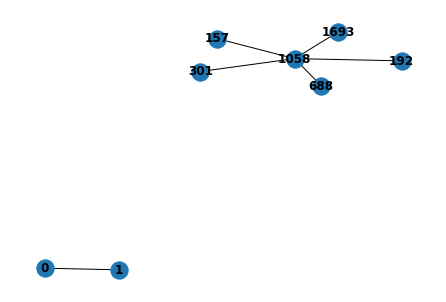

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

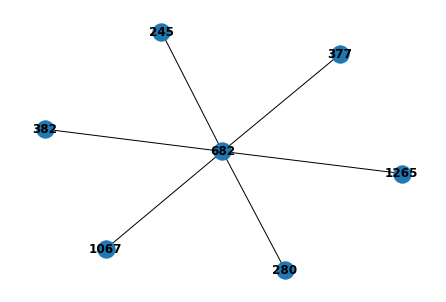

tensor([[ 682,  245,  377,  382,  682,  280],
        [1067,  682,  682,  682, 1265,  682]])
f1_score, ged 0 8.0


<Figure size 432x288 with 0 Axes>

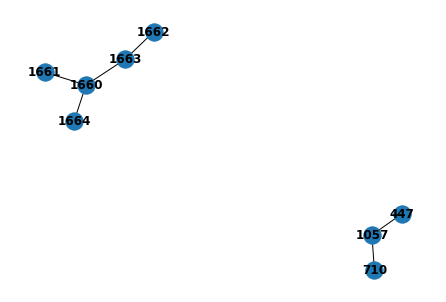

tensor([[1660, 1662, 1660, 1660, 1057, 1057],
        [1663, 1663, 1661, 1664,  447,  710]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

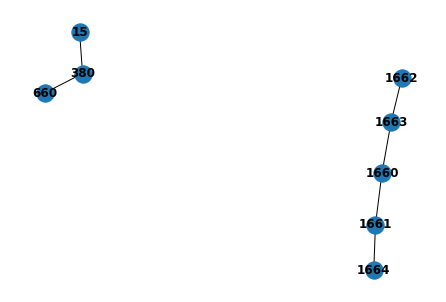

tensor([[1660, 1660, 1661, 1662,   15,  380],
        [1663, 1661, 1664, 1663,  380,  660]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

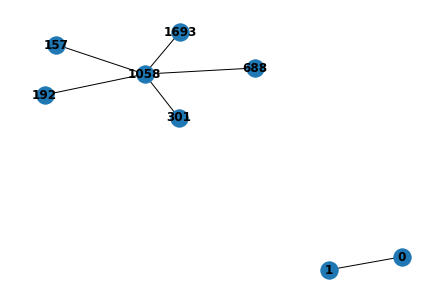

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

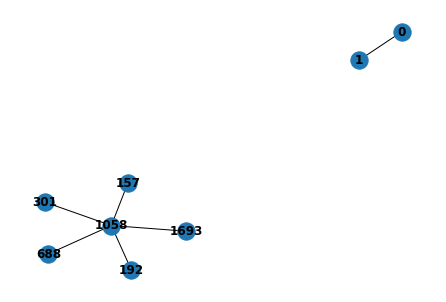

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

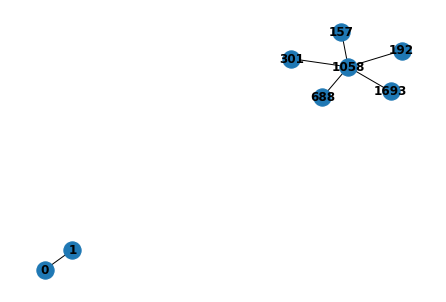

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

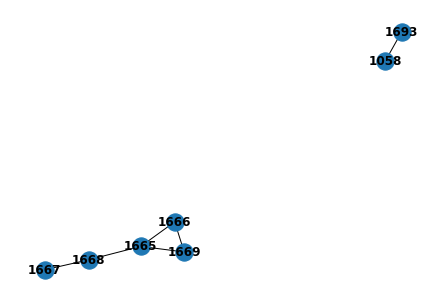

tensor([[1665, 1665, 1667, 1665, 1666, 1058],
        [1668, 1669, 1668, 1666, 1669, 1693]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

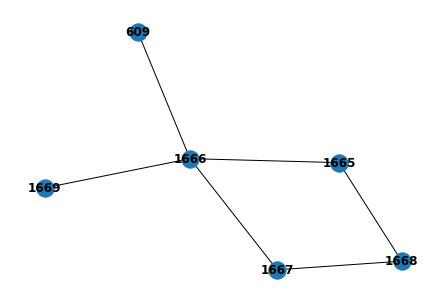

tensor([[1665, 1666, 1665, 1667, 1666,  609],
        [1668, 1669, 1666, 1668, 1667, 1666]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

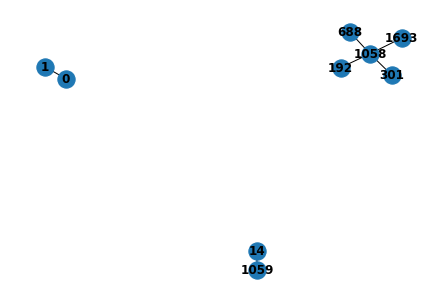

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

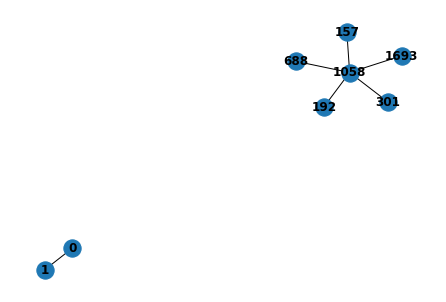

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

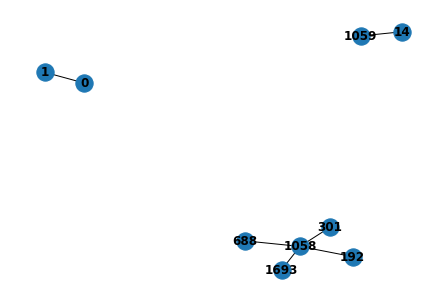

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

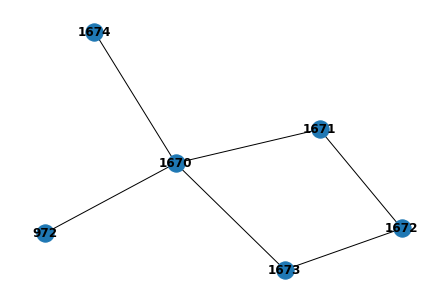

tensor([[1671, 1670, 1670, 1672, 1670,  972],
        [1672, 1674, 1671, 1673, 1673, 1670]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

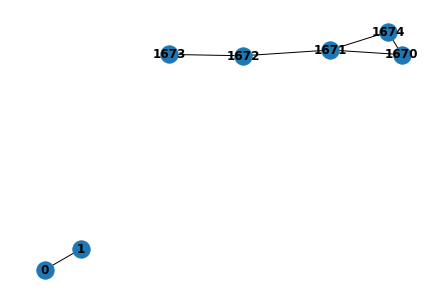

tensor([[1671, 1671, 1672, 1670, 1670,    0],
        [1672, 1674, 1673, 1671, 1674,    1]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

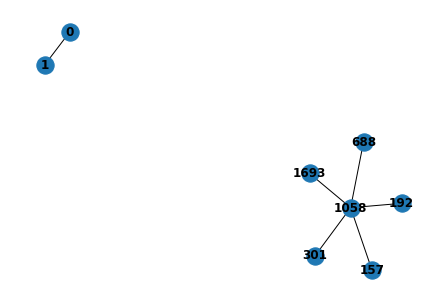

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

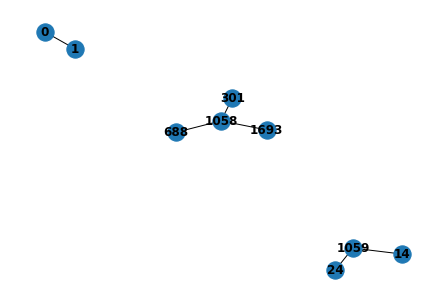

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

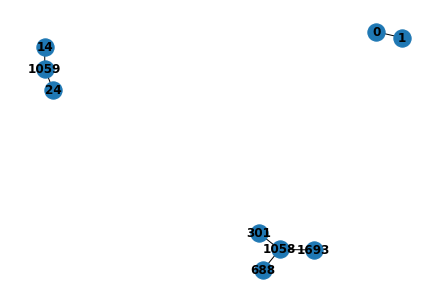

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

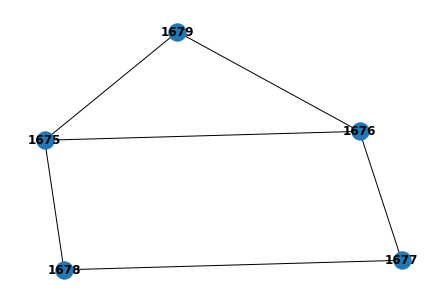

tensor([[1676, 1675, 1676, 1675, 1677, 1675],
        [1679, 1679, 1677, 1676, 1678, 1678]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

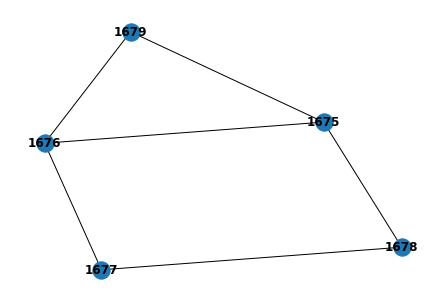

tensor([[1676, 1675, 1676, 1675, 1675, 1677],
        [1679, 1676, 1677, 1679, 1678, 1678]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

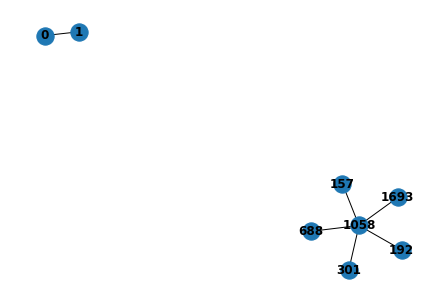

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

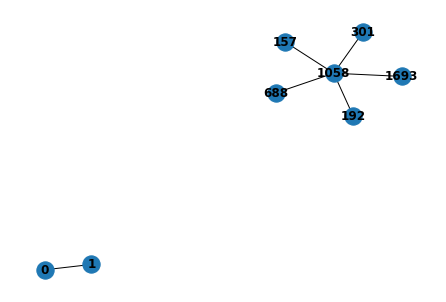

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

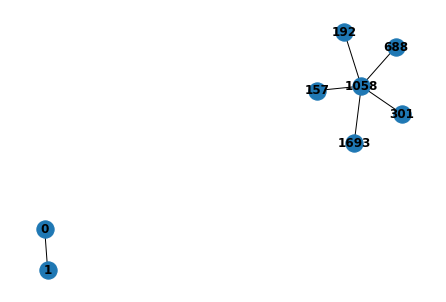

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

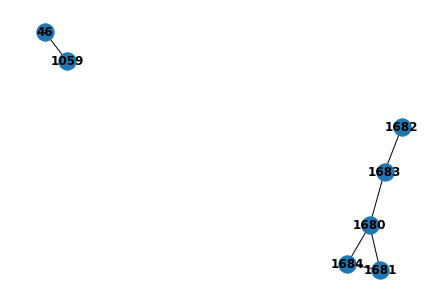

tensor([[1680, 1680, 1682, 1680, 1681, 1059],
        [1683, 1684, 1683, 1681, 1684,   46]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

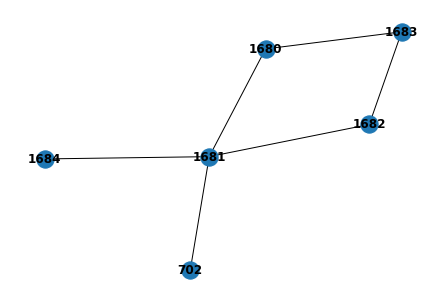

tensor([[1680, 1681, 1680, 1682, 1681,  702],
        [1683, 1684, 1681, 1683, 1682, 1681]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

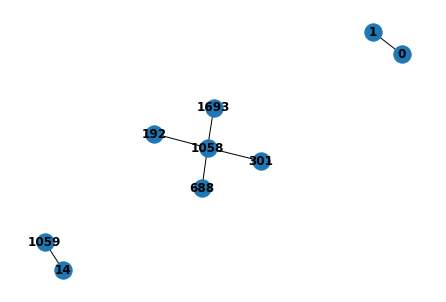

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

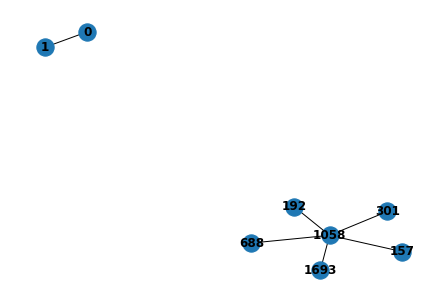

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

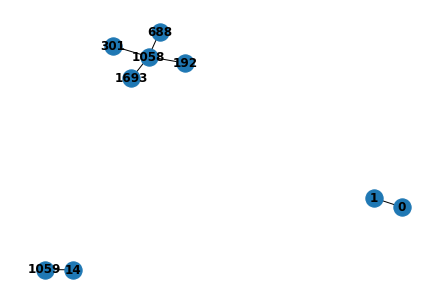

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

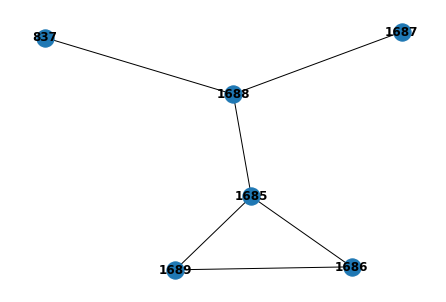

tensor([[1685,  837, 1685, 1685, 1686, 1687],
        [1688, 1688, 1689, 1686, 1689, 1688]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

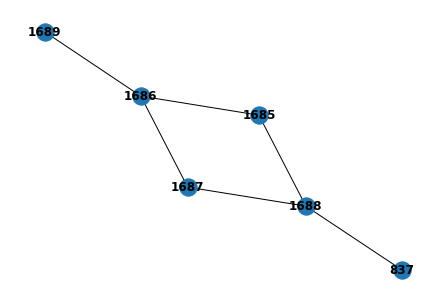

tensor([[1685, 1686, 1685,  837, 1687, 1686],
        [1688, 1689, 1686, 1688, 1688, 1687]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

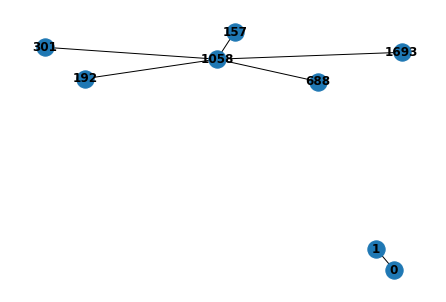

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

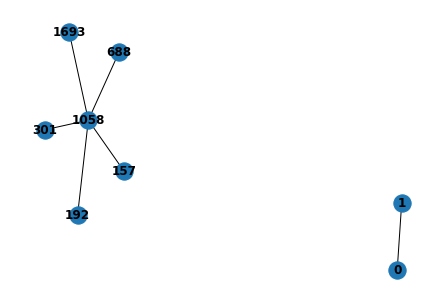

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

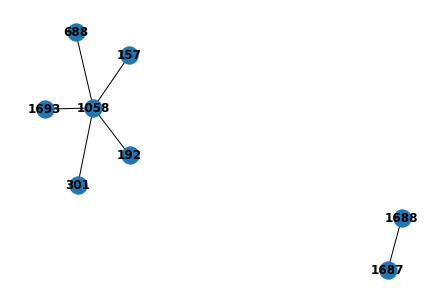

tensor([[1687, 1058, 1058, 1058, 1058, 1058],
        [1688, 1693,  688,  301,  192,  157]])
f1_score, ged 0.16666666666666666 9.0


<Figure size 432x288 with 0 Axes>

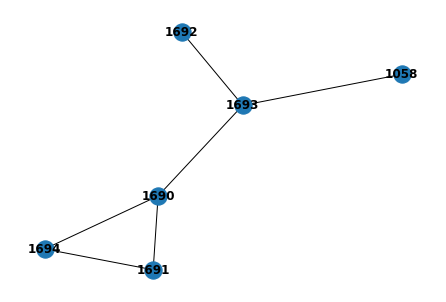

tensor([[1690, 1058, 1690, 1690, 1691, 1692],
        [1693, 1693, 1694, 1691, 1694, 1693]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

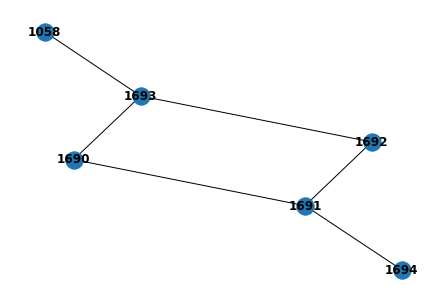

tensor([[1690, 1691, 1690, 1058, 1692, 1691],
        [1693, 1694, 1691, 1693, 1693, 1692]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

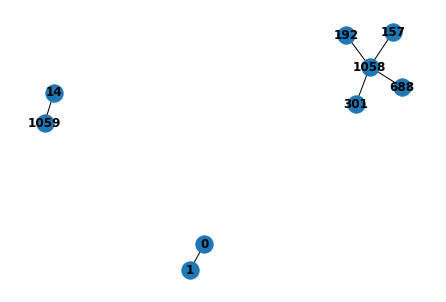

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14,  688,  301,  192,  157]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

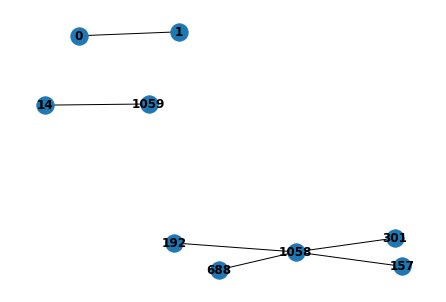

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14,  688,  301,  192,  157]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

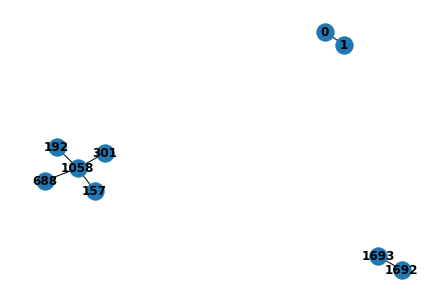

tensor([[1692,    0, 1058, 1058, 1058, 1058],
        [1693,    1,  688,  301,  192,  157]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

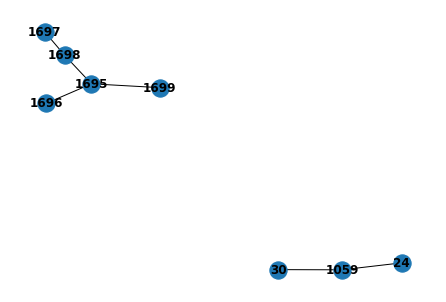

tensor([[1695, 1697, 1695, 1695, 1059, 1059],
        [1698, 1698, 1696, 1699,   30,   24]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

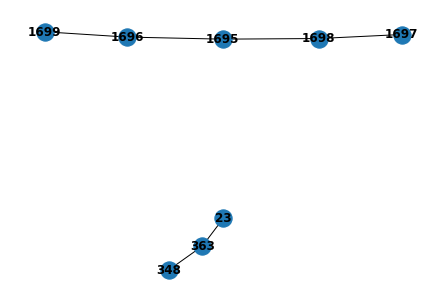

tensor([[1695, 1695, 1696, 1697,   23,  348],
        [1698, 1696, 1699, 1698,  363,  363]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

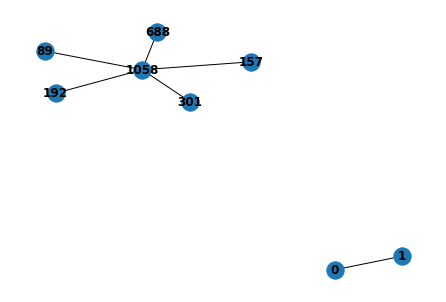

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

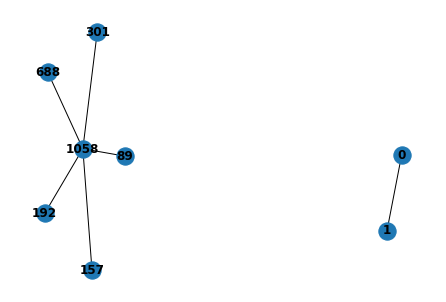

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

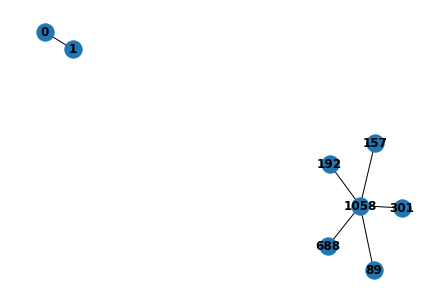

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

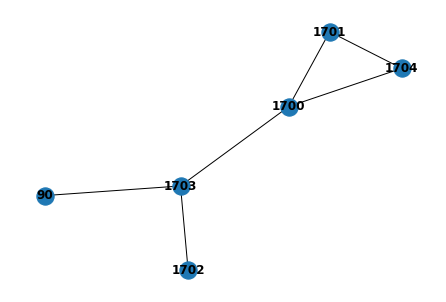

tensor([[1700, 1700,   90, 1700, 1701, 1702],
        [1703, 1704, 1703, 1701, 1704, 1703]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

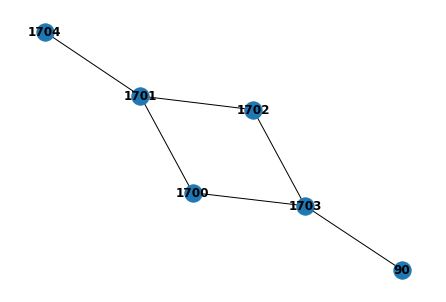

tensor([[1700, 1701, 1700,   90, 1702, 1701],
        [1703, 1704, 1701, 1703, 1703, 1702]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

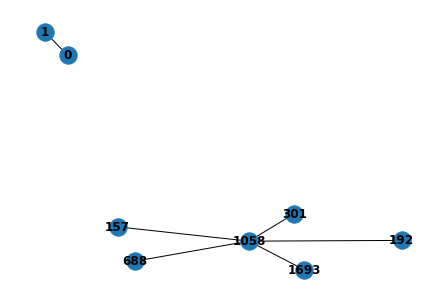

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

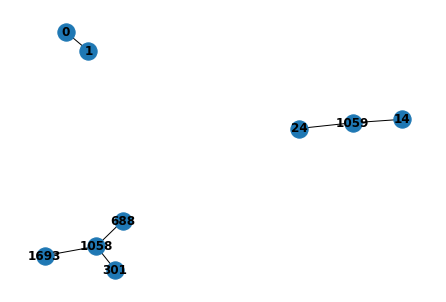

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

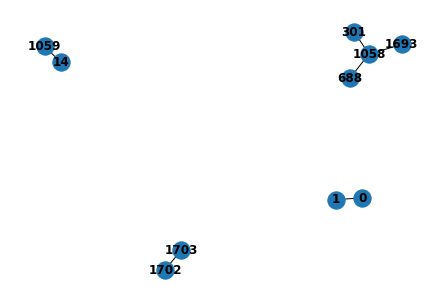

tensor([[1702,    0, 1059, 1058, 1058, 1058],
        [1703,    1,   14, 1693,  688,  301]])
f1_score, ged 0.16666666666666666 11.0


<Figure size 432x288 with 0 Axes>

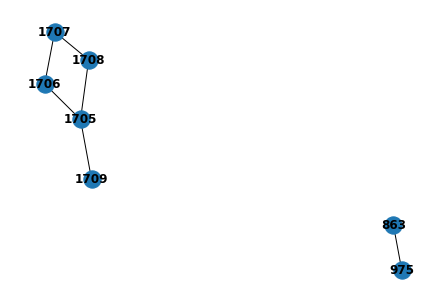

tensor([[1706, 1705, 1705, 1707, 1705,  863],
        [1707, 1706, 1709, 1708, 1708,  975]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

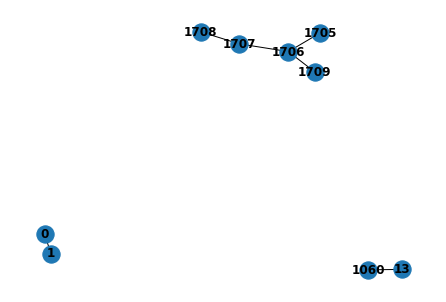

tensor([[1706, 1707, 1705, 1706,    0, 1060],
        [1707, 1708, 1706, 1709,    1,   13]])
f1_score, ged 0.6666666666666666 8.0


<Figure size 432x288 with 0 Axes>

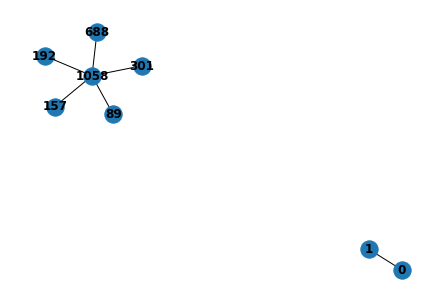

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

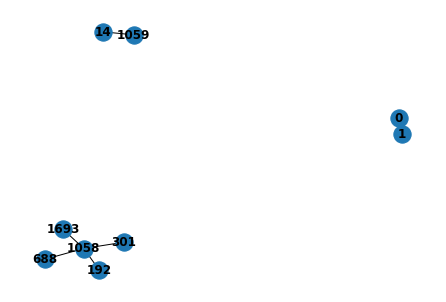

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

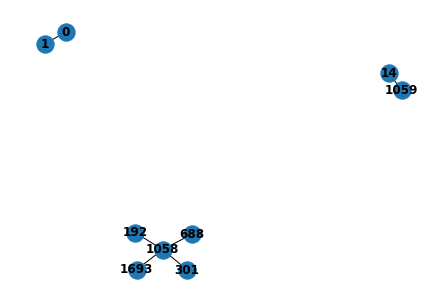

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

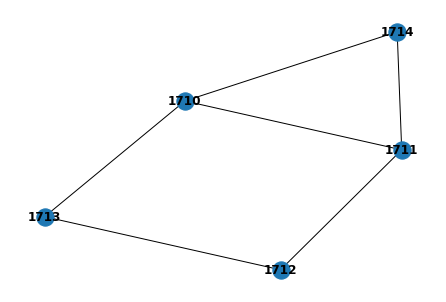

tensor([[1711, 1710, 1710, 1712, 1710, 1711],
        [1712, 1714, 1711, 1713, 1713, 1714]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

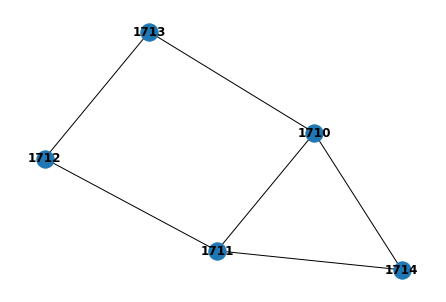

tensor([[1711, 1711, 1710, 1712, 1710, 1710],
        [1712, 1714, 1711, 1713, 1714, 1713]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

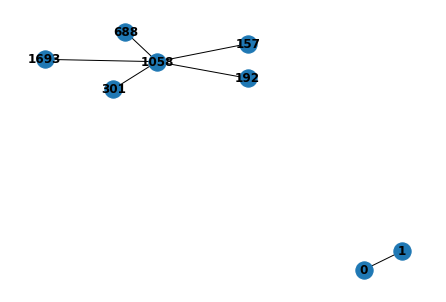

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

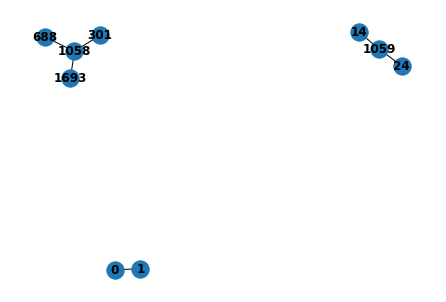

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

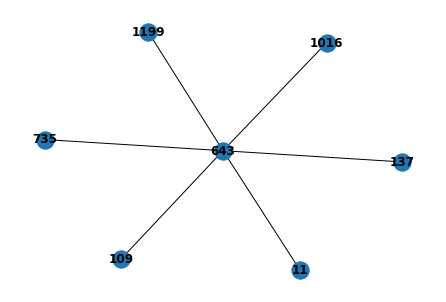

tensor([[  11,  643,  643,  643,  137,  109],
        [ 643,  735, 1016, 1199,  643,  643]])
f1_score, ged 0 8.0


<Figure size 432x288 with 0 Axes>

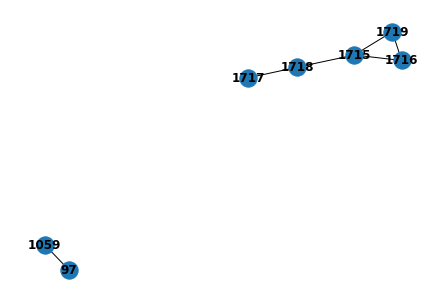

tensor([[1715, 1715, 1717, 1715, 1716, 1059],
        [1718, 1719, 1718, 1716, 1719,   97]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

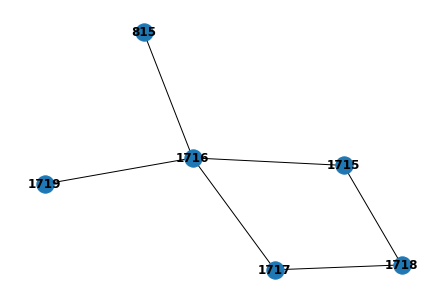

tensor([[1715, 1716, 1715, 1717, 1716,  815],
        [1718, 1719, 1716, 1718, 1717, 1716]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

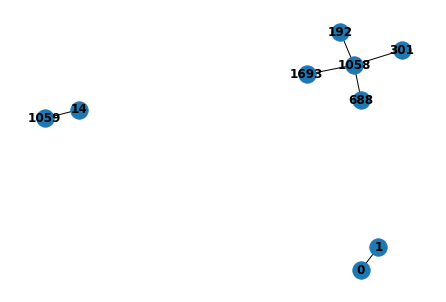

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

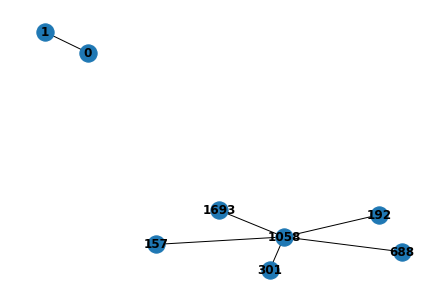

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

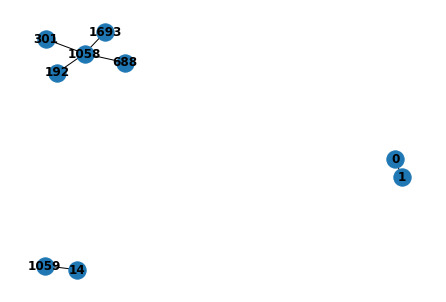

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

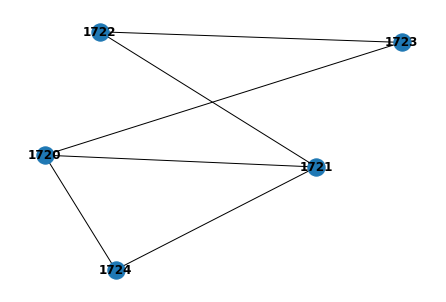

tensor([[1720, 1720, 1720, 1721, 1721, 1722],
        [1721, 1724, 1723, 1724, 1722, 1723]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

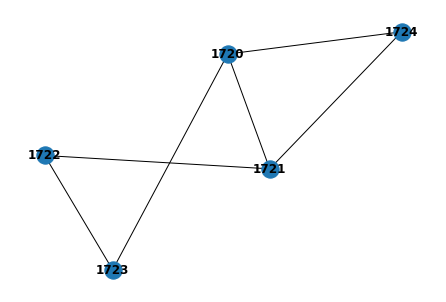

tensor([[1720, 1721, 1721, 1720, 1720, 1722],
        [1721, 1724, 1722, 1724, 1723, 1723]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

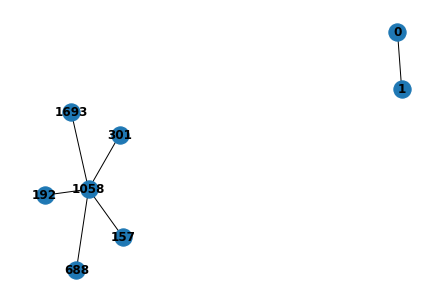

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

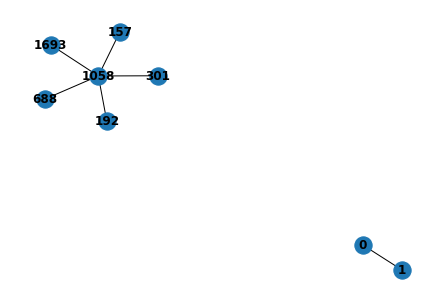

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

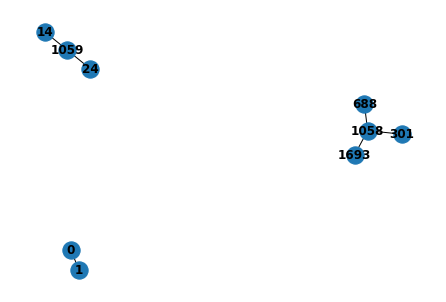

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

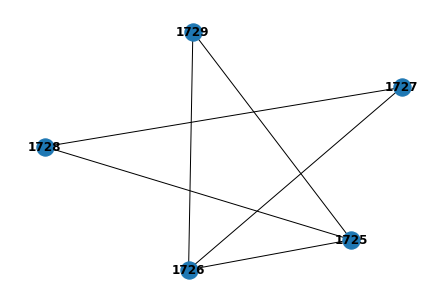

tensor([[1726, 1726, 1725, 1727, 1725, 1725],
        [1729, 1727, 1729, 1728, 1726, 1728]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

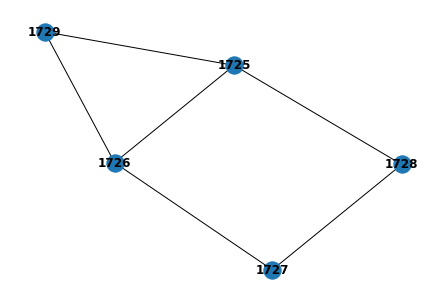

tensor([[1726, 1725, 1726, 1725, 1725, 1727],
        [1729, 1726, 1727, 1729, 1728, 1728]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

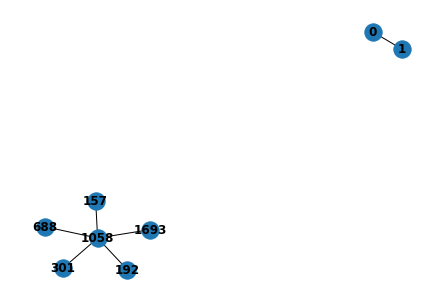

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

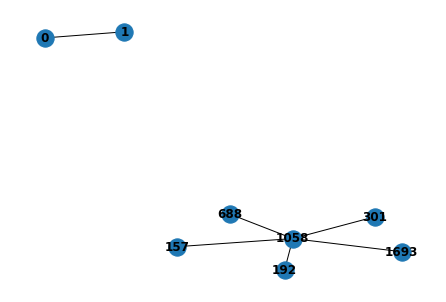

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

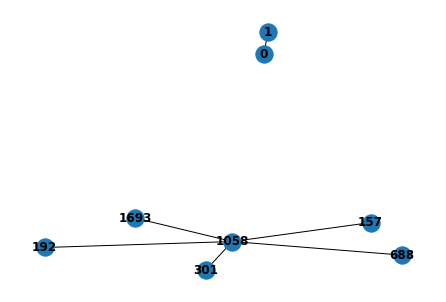

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

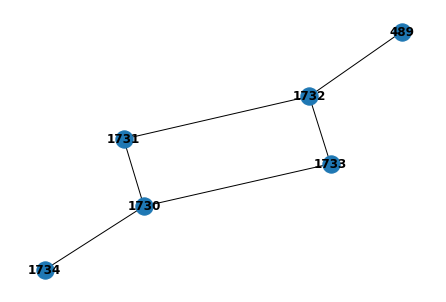

tensor([[1731, 1730, 1730,  489, 1732, 1730],
        [1732, 1734, 1731, 1732, 1733, 1733]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

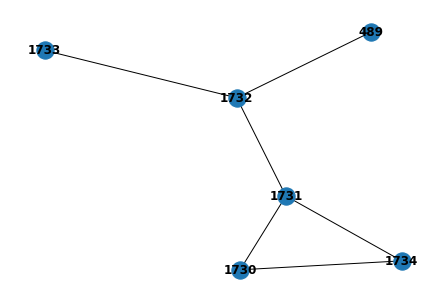

tensor([[1731,  489, 1731, 1730, 1730, 1732],
        [1732, 1732, 1734, 1731, 1734, 1733]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

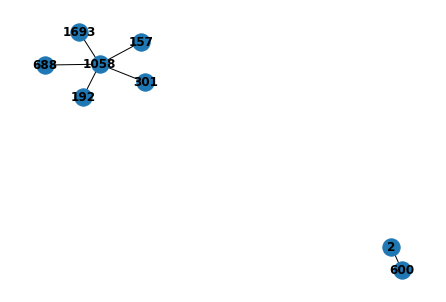

tensor([[ 600, 1058, 1058, 1058, 1058, 1058],
        [   2, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

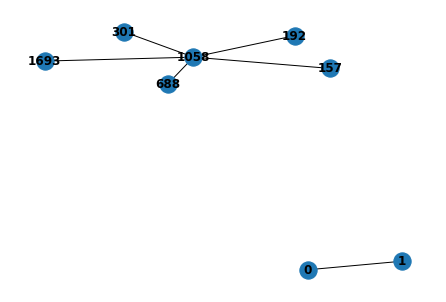

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

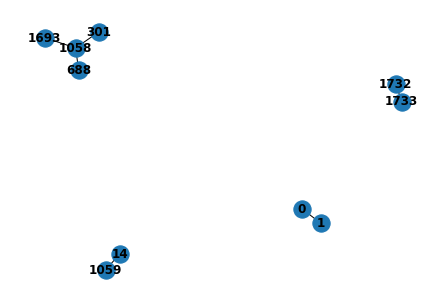

tensor([[1732,    0, 1059, 1058, 1058, 1058],
        [1733,    1,   14, 1693,  688,  301]])
f1_score, ged 0.16666666666666666 11.0


<Figure size 432x288 with 0 Axes>

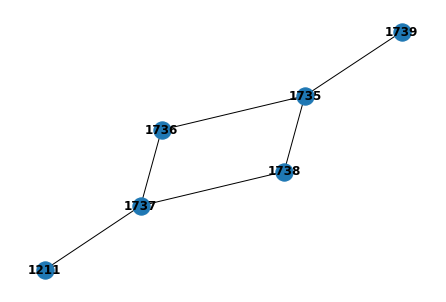

tensor([[1736, 1735, 1735, 1211, 1737, 1735],
        [1737, 1739, 1736, 1737, 1738, 1738]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

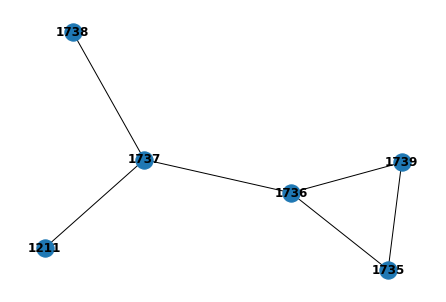

tensor([[1736, 1211, 1736, 1735, 1735, 1737],
        [1737, 1737, 1739, 1736, 1739, 1738]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

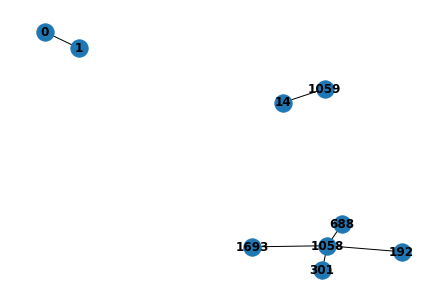

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

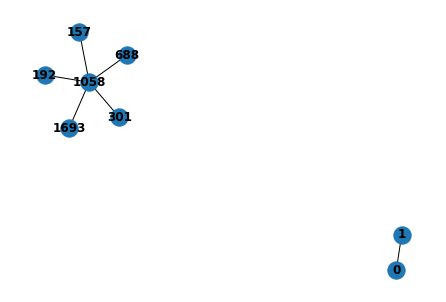

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

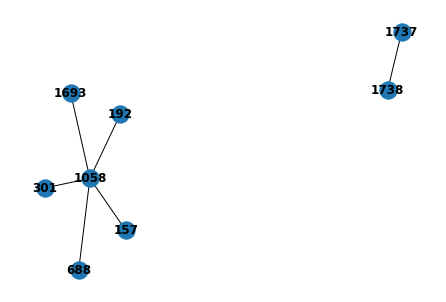

tensor([[1737, 1058, 1058, 1058, 1058, 1058],
        [1738, 1693,  688,  301,  192,  157]])
f1_score, ged 0.16666666666666666 9.0


<Figure size 432x288 with 0 Axes>

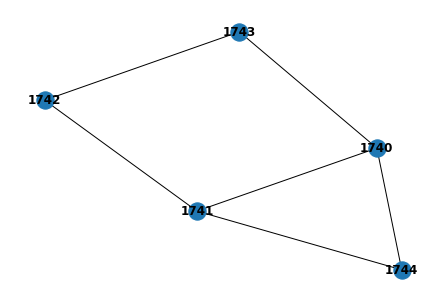

tensor([[1740, 1740, 1740, 1741, 1741, 1742],
        [1744, 1741, 1743, 1744, 1742, 1743]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

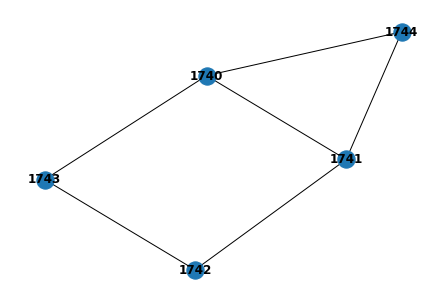

tensor([[1741, 1740, 1741, 1740, 1740, 1742],
        [1744, 1741, 1742, 1744, 1743, 1743]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

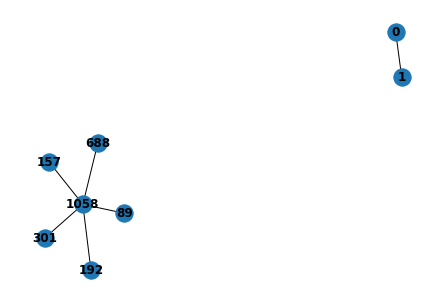

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

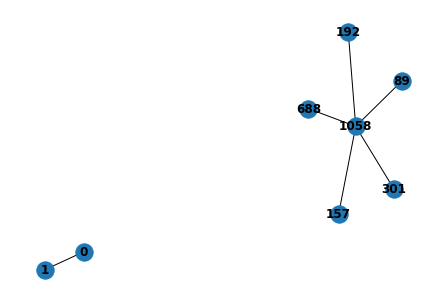

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

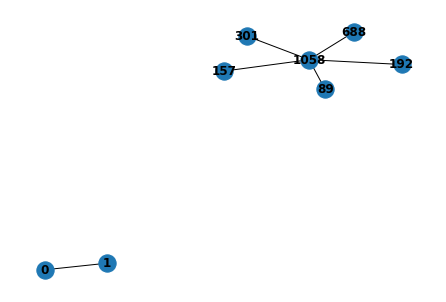

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

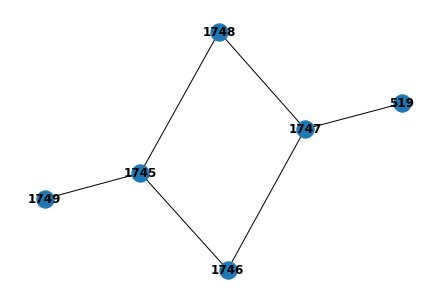

tensor([[1746, 1745, 1745,  519, 1747, 1745],
        [1747, 1749, 1746, 1747, 1748, 1748]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

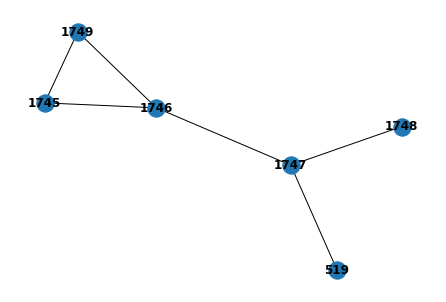

tensor([[1746,  519, 1746, 1745, 1745, 1747],
        [1747, 1747, 1749, 1746, 1749, 1748]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

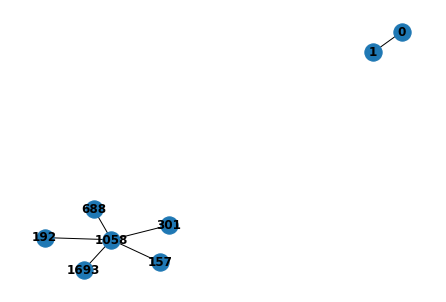

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

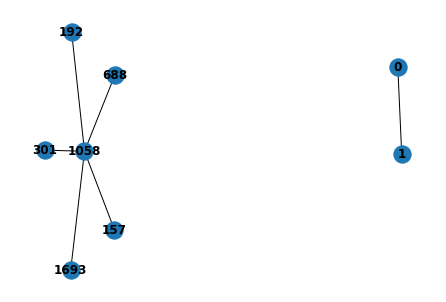

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

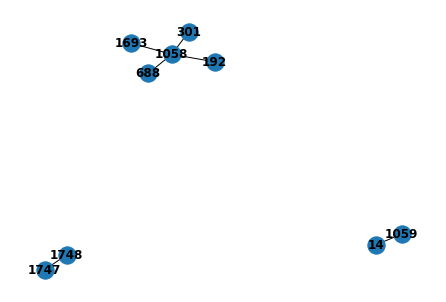

tensor([[1747, 1059, 1058, 1058, 1058, 1058],
        [1748,   14, 1693,  688,  301,  192]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

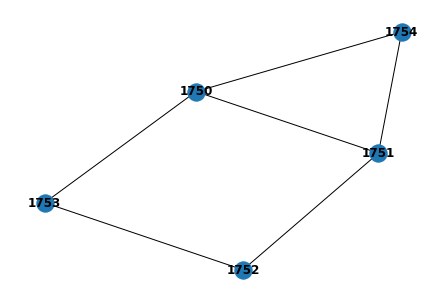

tensor([[1750, 1750, 1750, 1751, 1751, 1752],
        [1751, 1754, 1753, 1754, 1752, 1753]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

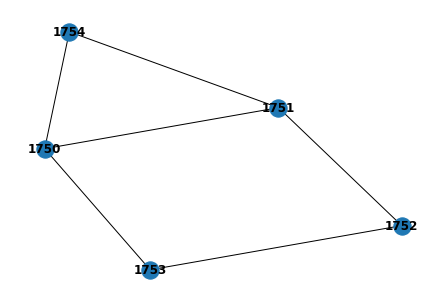

tensor([[1750, 1751, 1751, 1750, 1750, 1752],
        [1751, 1754, 1752, 1754, 1753, 1753]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

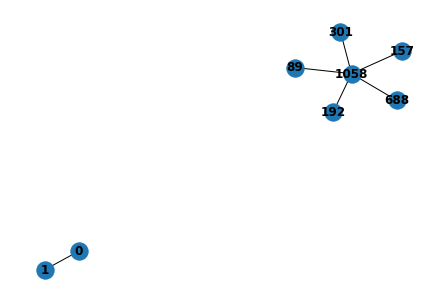

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

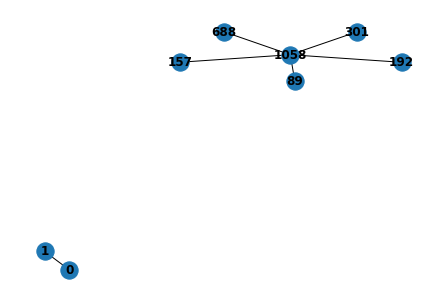

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

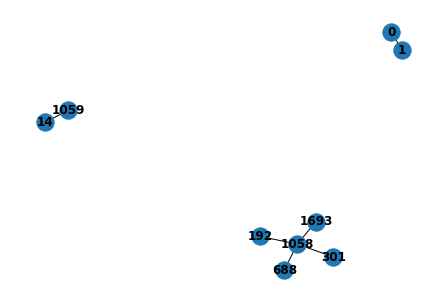

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

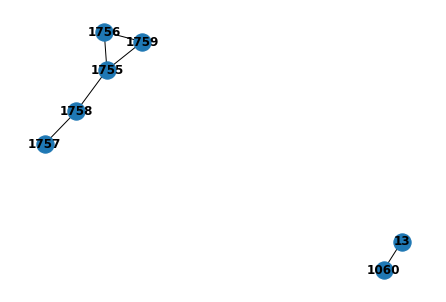

tensor([[1755, 1755, 1757, 1755, 1756, 1060],
        [1758, 1759, 1758, 1756, 1759,   13]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

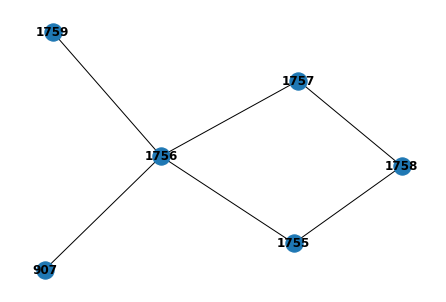

tensor([[1755, 1756, 1755, 1757, 1756,  907],
        [1758, 1759, 1756, 1758, 1757, 1756]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

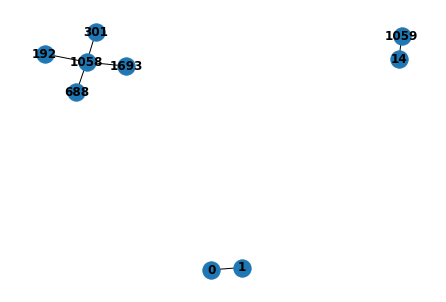

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

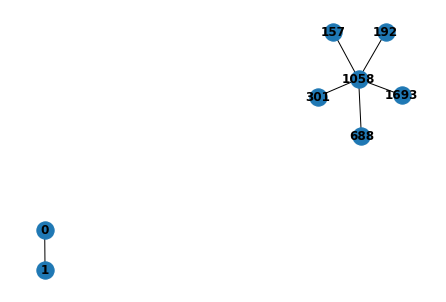

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

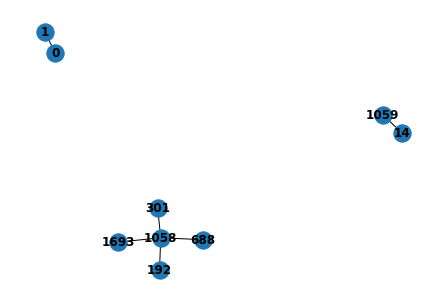

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

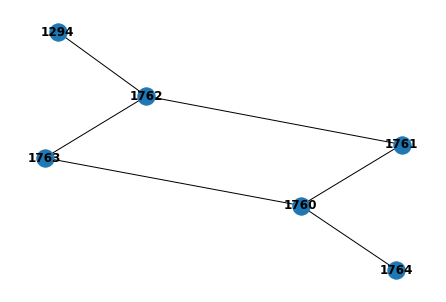

tensor([[1761, 1760, 1760, 1294, 1762, 1760],
        [1762, 1764, 1761, 1762, 1763, 1763]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

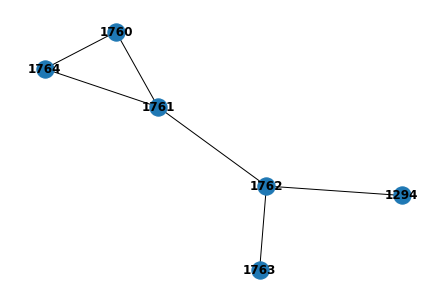

tensor([[1761, 1294, 1761, 1760, 1760, 1762],
        [1762, 1762, 1764, 1761, 1764, 1763]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

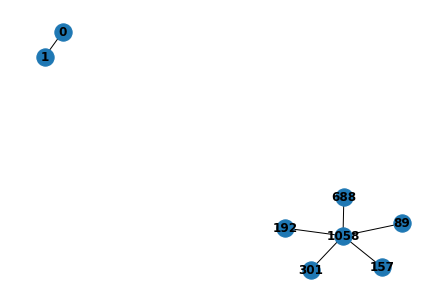

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

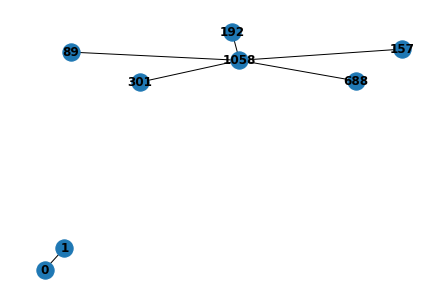

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

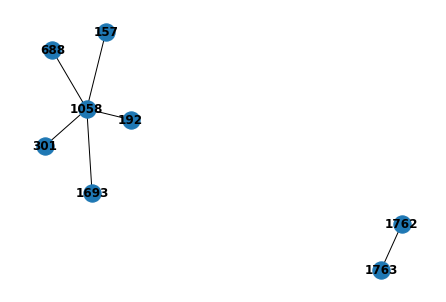

tensor([[1762, 1058, 1058, 1058, 1058, 1058],
        [1763, 1693,  688,  301,  192,  157]])
f1_score, ged 0.16666666666666666 9.0


<Figure size 432x288 with 0 Axes>

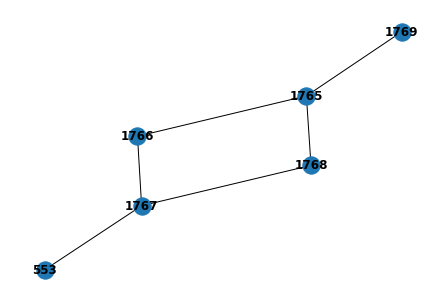

tensor([[1766, 1765, 1765,  553, 1767, 1765],
        [1767, 1769, 1766, 1767, 1768, 1768]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

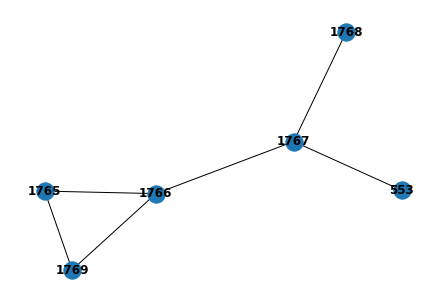

tensor([[1766,  553, 1766, 1765, 1765, 1767],
        [1767, 1767, 1769, 1766, 1769, 1768]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

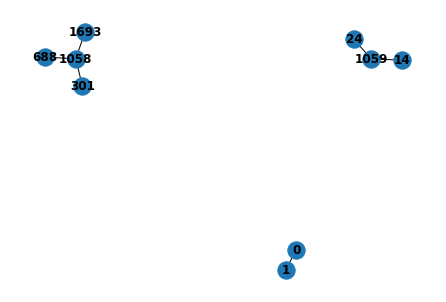

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

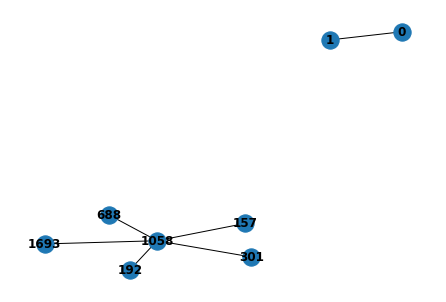

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

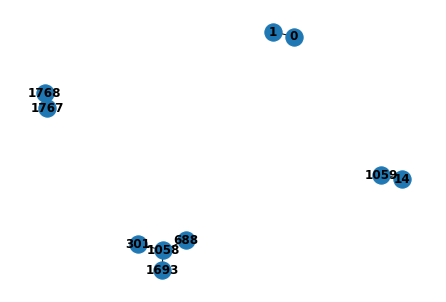

tensor([[1767,    0, 1059, 1058, 1058, 1058],
        [1768,    1,   14, 1693,  688,  301]])
f1_score, ged 0.16666666666666666 11.0


<Figure size 432x288 with 0 Axes>

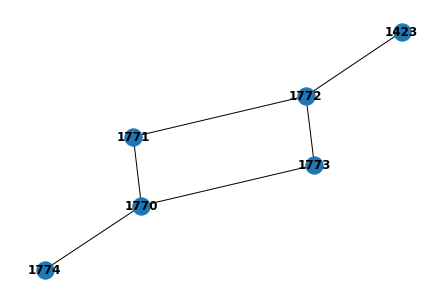

tensor([[1771, 1770, 1770, 1423, 1772, 1770],
        [1772, 1774, 1771, 1772, 1773, 1773]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

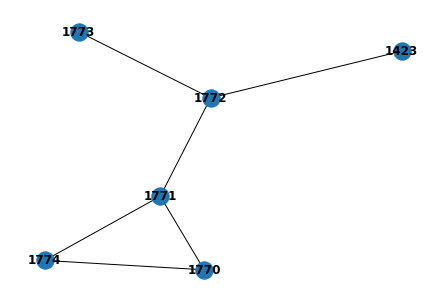

tensor([[1771, 1423, 1771, 1770, 1770, 1772],
        [1772, 1772, 1774, 1771, 1774, 1773]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

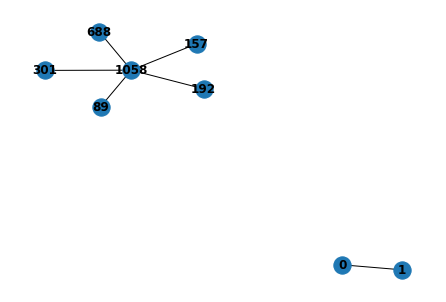

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

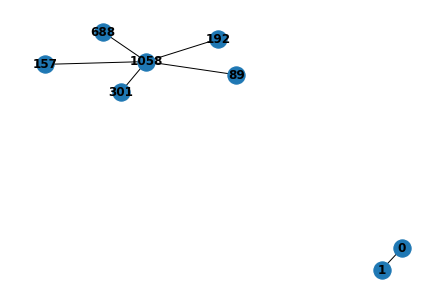

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

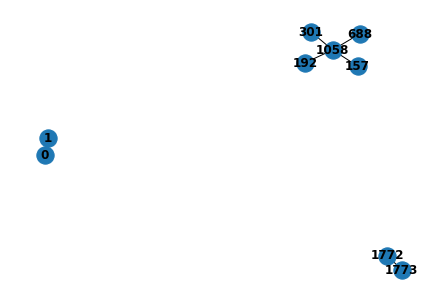

tensor([[1772,    0, 1058, 1058, 1058, 1058],
        [1773,    1,  688,  301,  192,  157]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

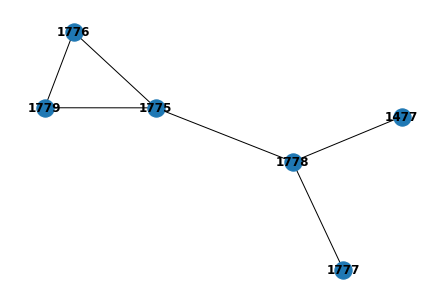

tensor([[1775, 1477, 1775, 1775, 1776, 1777],
        [1778, 1778, 1779, 1776, 1779, 1778]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

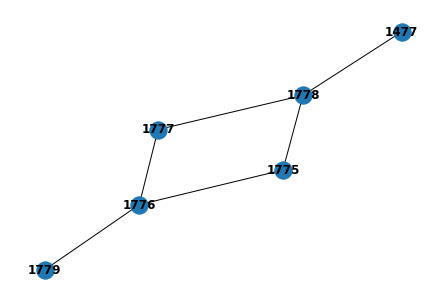

tensor([[1775, 1776, 1775, 1477, 1777, 1776],
        [1778, 1779, 1776, 1778, 1778, 1777]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

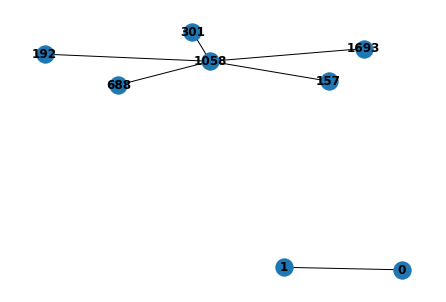

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

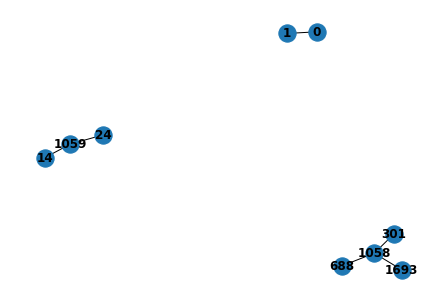

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

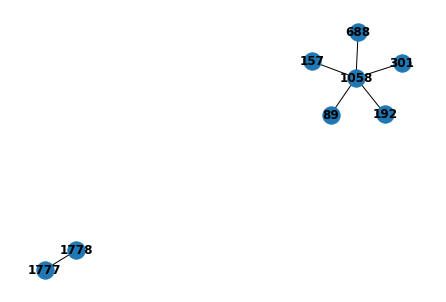

tensor([[1777, 1058, 1058, 1058, 1058, 1058],
        [1778,  688,  301,  192,  157,   89]])
f1_score, ged 0.16666666666666666 9.0


<Figure size 432x288 with 0 Axes>

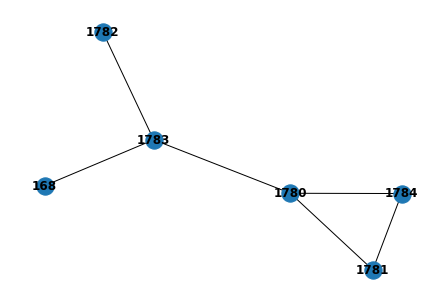

tensor([[1780,  168, 1780, 1780, 1781, 1782],
        [1783, 1783, 1784, 1781, 1784, 1783]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

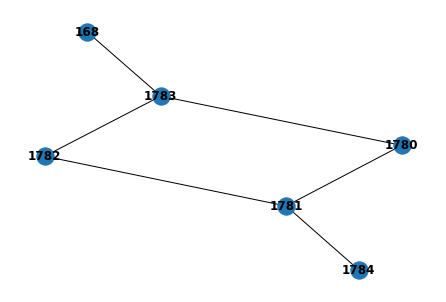

tensor([[1780, 1781, 1780,  168, 1782, 1781],
        [1783, 1784, 1781, 1783, 1783, 1782]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

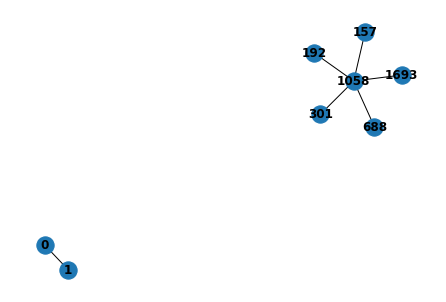

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

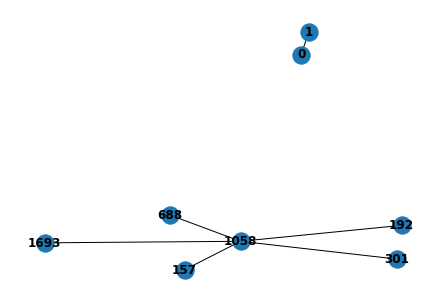

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

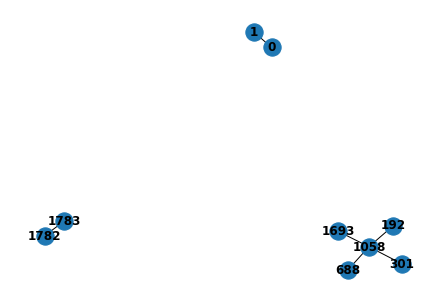

tensor([[1782,    0, 1058, 1058, 1058, 1058],
        [1783,    1, 1693,  688,  301,  192]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

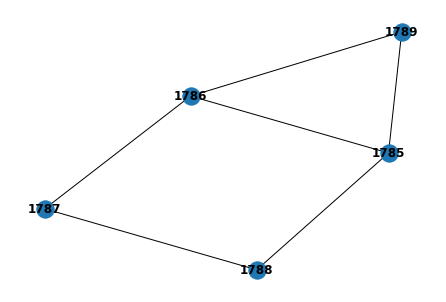

tensor([[1786, 1785, 1786, 1785, 1787, 1785],
        [1789, 1789, 1787, 1786, 1788, 1788]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

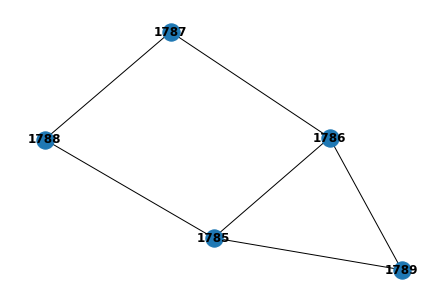

tensor([[1786, 1785, 1786, 1785, 1785, 1787],
        [1789, 1786, 1787, 1789, 1788, 1788]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

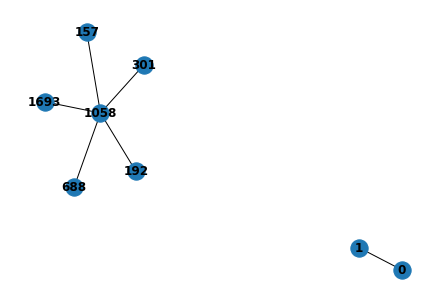

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

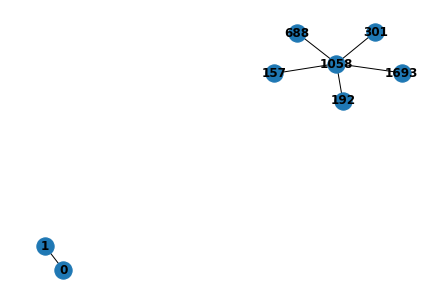

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

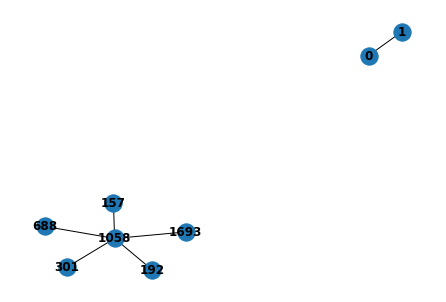

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

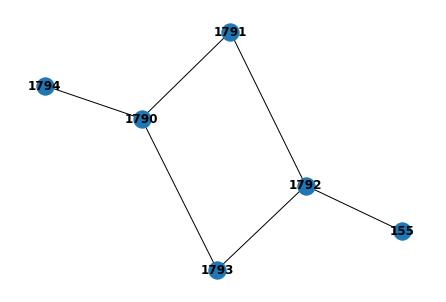

tensor([[1791, 1790, 1790,  155, 1792, 1790],
        [1792, 1794, 1791, 1792, 1793, 1793]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

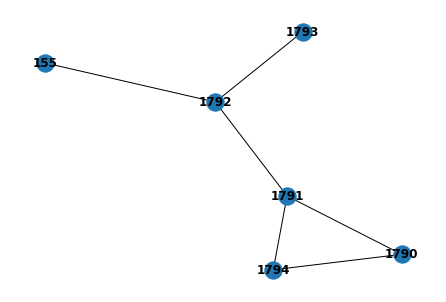

tensor([[1791,  155, 1791, 1790, 1790, 1792],
        [1792, 1792, 1794, 1791, 1794, 1793]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

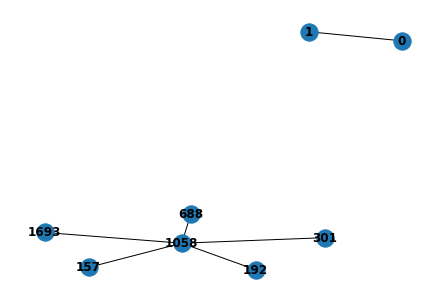

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

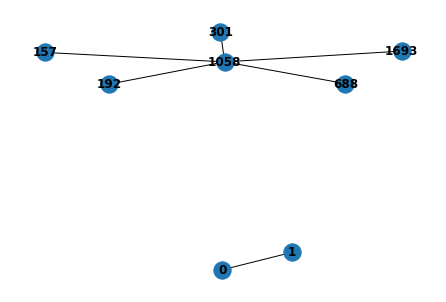

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

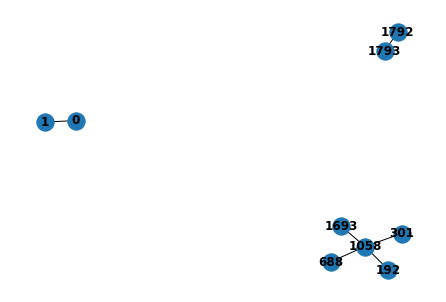

tensor([[1792,    0, 1058, 1058, 1058, 1058],
        [1793,    1, 1693,  688,  301,  192]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

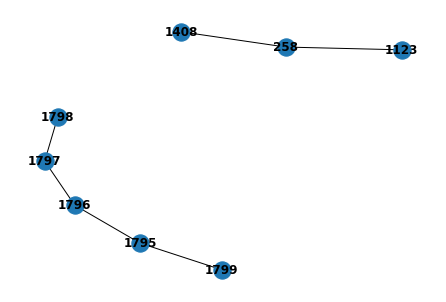

tensor([[1796, 1795, 1795, 1797,  258,  258],
        [1797, 1796, 1799, 1798, 1123, 1408]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

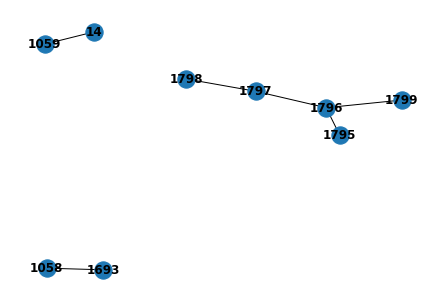

tensor([[1796, 1797, 1795, 1796, 1059, 1058],
        [1797, 1798, 1796, 1799,   14, 1693]])
f1_score, ged 0.6666666666666666 8.0


<Figure size 432x288 with 0 Axes>

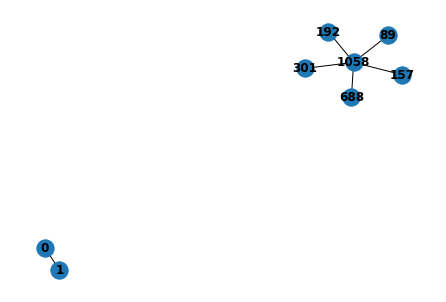

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

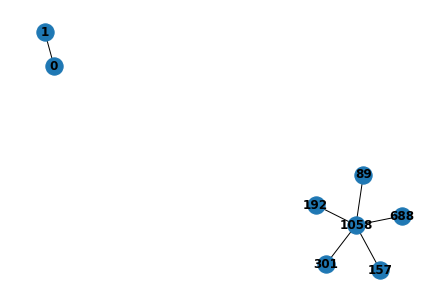

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

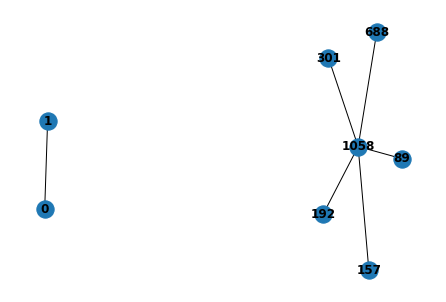

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

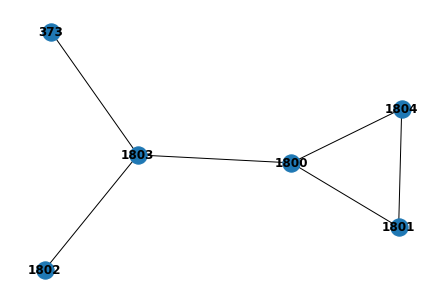

tensor([[1800,  373, 1800, 1800, 1801, 1802],
        [1803, 1803, 1804, 1801, 1804, 1803]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

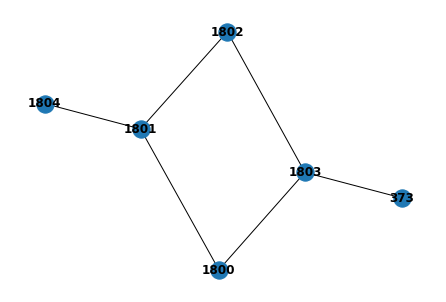

tensor([[1800, 1801, 1800,  373, 1802, 1801],
        [1803, 1804, 1801, 1803, 1803, 1802]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

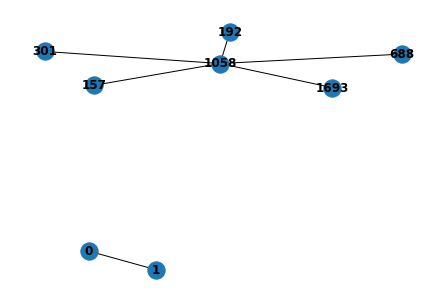

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

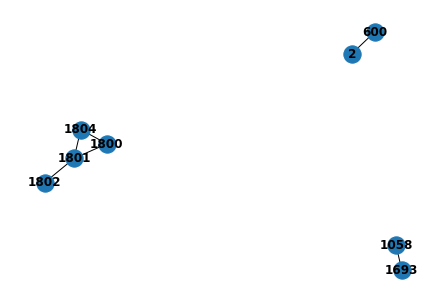

tensor([[1801, 1800, 1801, 1800,  600, 1058],
        [1802, 1801, 1804, 1804,    2, 1693]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

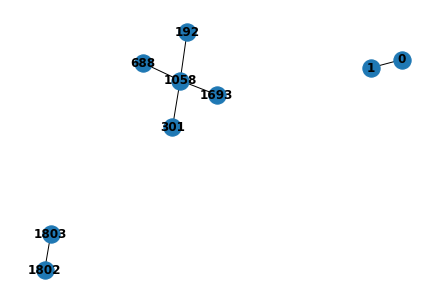

tensor([[1802,    0, 1058, 1058, 1058, 1058],
        [1803,    1, 1693,  688,  301,  192]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

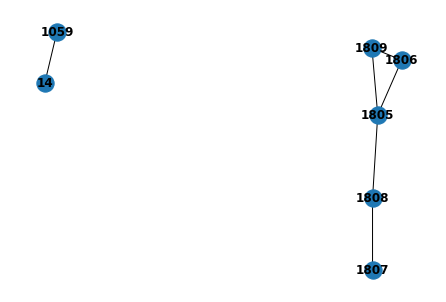

tensor([[1805, 1805, 1807, 1805, 1806, 1059],
        [1808, 1809, 1808, 1806, 1809,   14]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

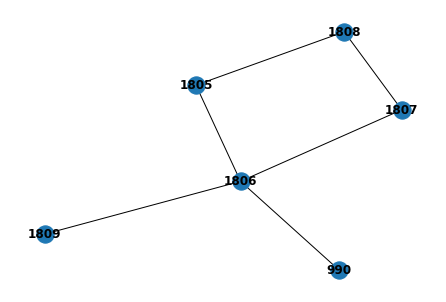

tensor([[1805, 1806, 1805, 1807, 1806,  990],
        [1808, 1809, 1806, 1808, 1807, 1806]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

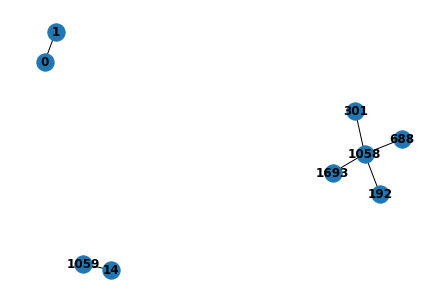

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

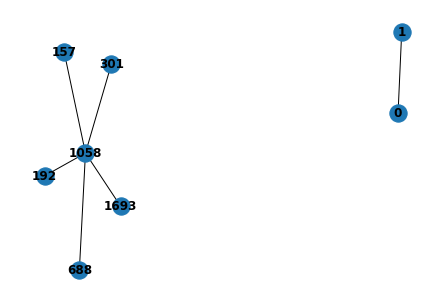

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

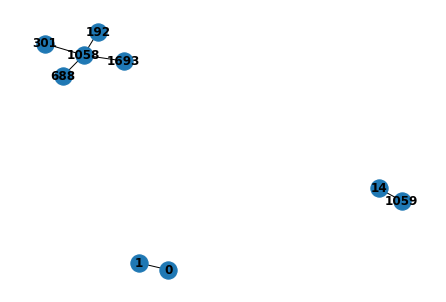

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

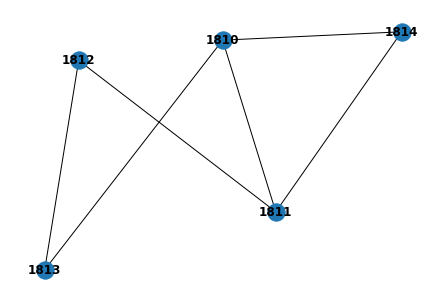

tensor([[1811, 1810, 1810, 1812, 1810, 1811],
        [1812, 1814, 1811, 1813, 1813, 1814]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

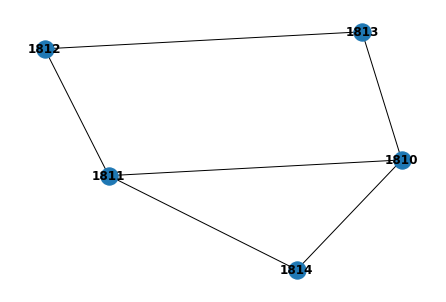

tensor([[1811, 1811, 1810, 1812, 1810, 1810],
        [1812, 1814, 1811, 1813, 1814, 1813]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

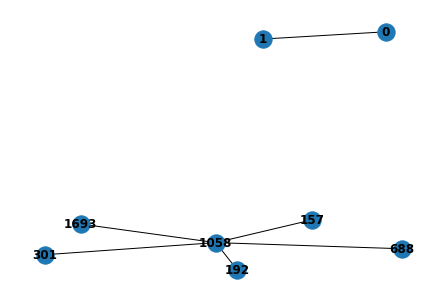

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

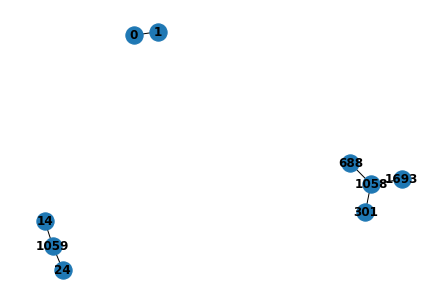

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

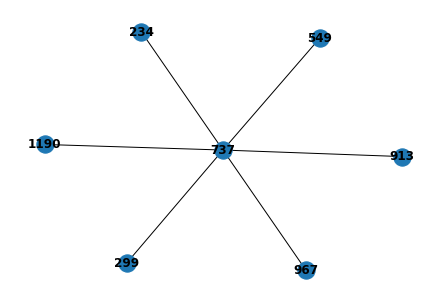

tensor([[ 549,  234,  737,  737,  737,  299],
        [ 737,  737, 1190,  967,  913,  737]])
f1_score, ged 0 8.0


<Figure size 432x288 with 0 Axes>

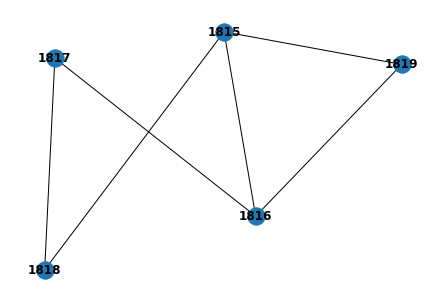

tensor([[1816, 1815, 1815, 1817, 1815, 1816],
        [1817, 1819, 1816, 1818, 1818, 1819]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

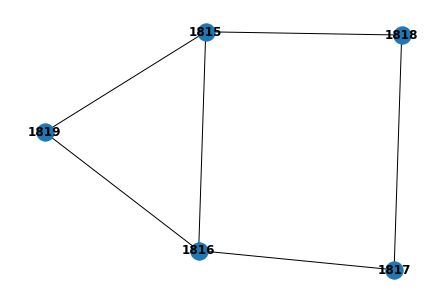

tensor([[1816, 1816, 1815, 1817, 1815, 1815],
        [1817, 1819, 1816, 1818, 1819, 1818]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

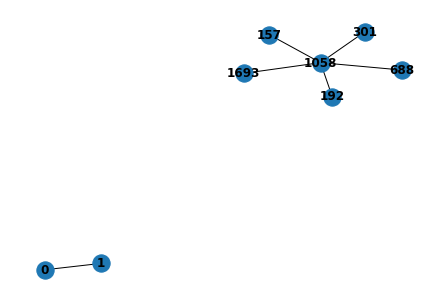

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

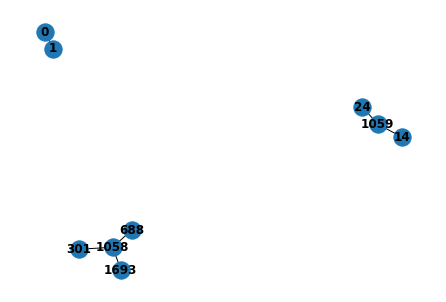

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

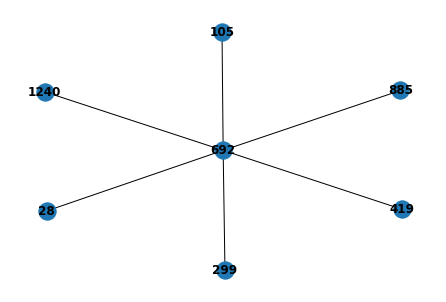

tensor([[ 419,  692,  692,  299,  105,   28],
        [ 692,  885, 1240,  692,  692,  692]])
f1_score, ged 0 8.0


<Figure size 432x288 with 0 Axes>

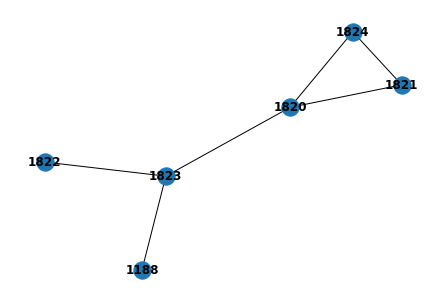

tensor([[1820, 1188, 1820, 1820, 1821, 1822],
        [1823, 1823, 1824, 1821, 1824, 1823]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

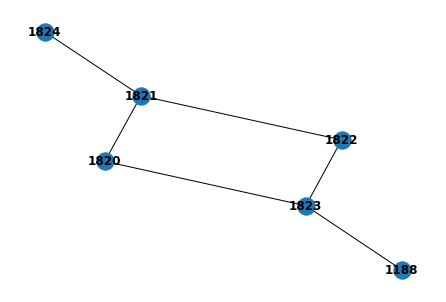

tensor([[1820, 1821, 1820, 1188, 1822, 1821],
        [1823, 1824, 1821, 1823, 1823, 1822]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

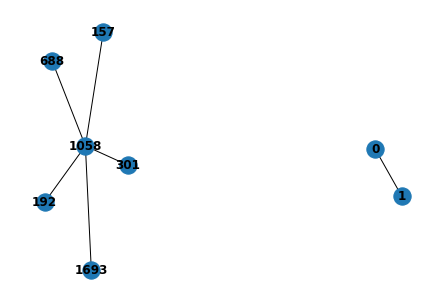

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

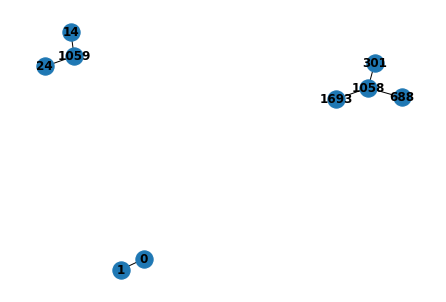

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

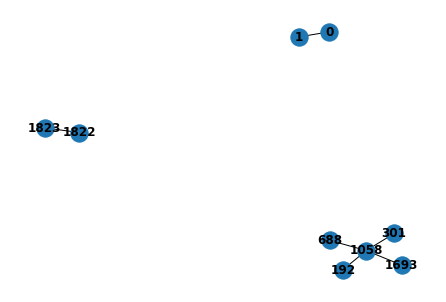

tensor([[1822,    0, 1058, 1058, 1058, 1058],
        [1823,    1, 1693,  688,  301,  192]])
f1_score, ged 0.16666666666666666 10.0


<Figure size 432x288 with 0 Axes>

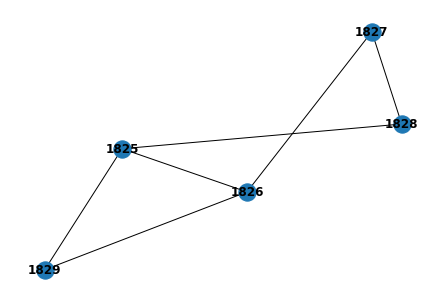

tensor([[1826, 1825, 1825, 1827, 1825, 1826],
        [1827, 1829, 1826, 1828, 1828, 1829]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

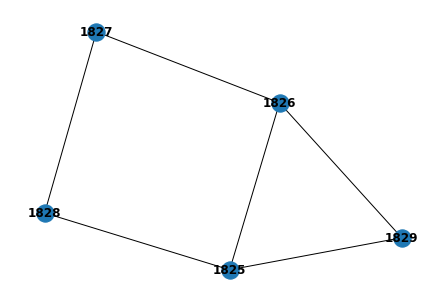

tensor([[1826, 1826, 1825, 1827, 1825, 1825],
        [1827, 1829, 1826, 1828, 1829, 1828]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

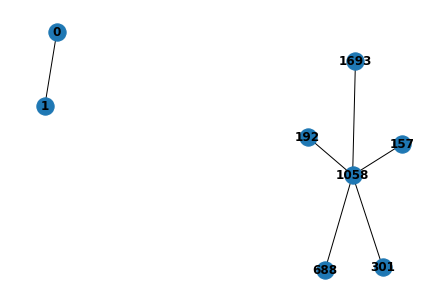

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

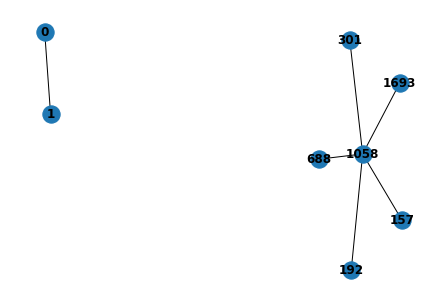

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

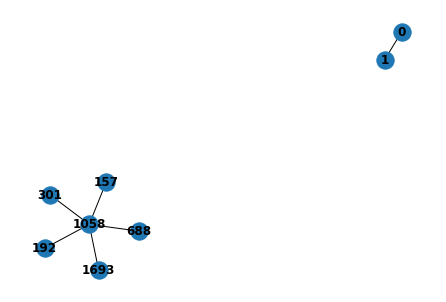

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

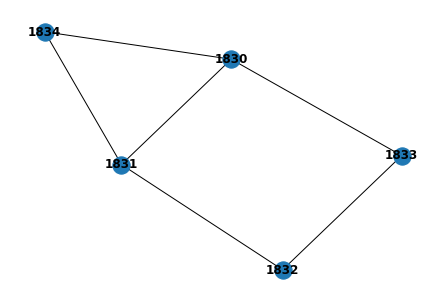

tensor([[1830, 1830, 1830, 1832, 1831, 1831],
        [1833, 1834, 1831, 1833, 1834, 1832]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

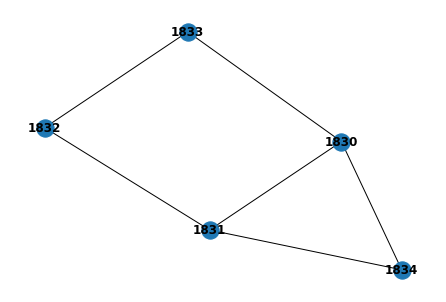

tensor([[1830, 1831, 1830, 1832, 1831, 1830],
        [1833, 1834, 1831, 1833, 1832, 1834]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

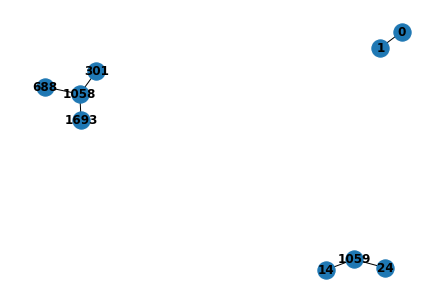

tensor([[   0, 1059, 1059, 1058, 1058, 1058],
        [   1,   24,   14, 1693,  688,  301]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

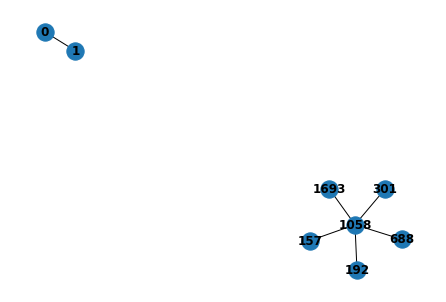

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

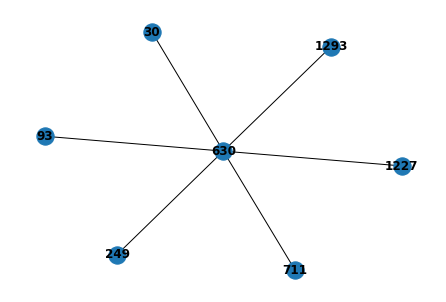

tensor([[  30,  249,   93,  630,  630,  630],
        [ 630,  630,  630,  711, 1227, 1293]])
f1_score, ged 0 8.0


<Figure size 432x288 with 0 Axes>

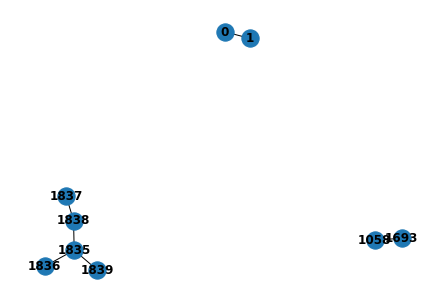

tensor([[1835, 1837, 1835, 1835,    0, 1058],
        [1838, 1838, 1836, 1839,    1, 1693]])
f1_score, ged 0.6666666666666666 8.0


<Figure size 432x288 with 0 Axes>

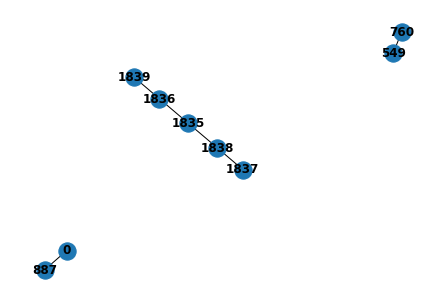

tensor([[1835, 1835, 1836, 1837,    0,  549],
        [1838, 1836, 1839, 1838,  887,  760]])
f1_score, ged 0.6666666666666666 8.0


<Figure size 432x288 with 0 Axes>

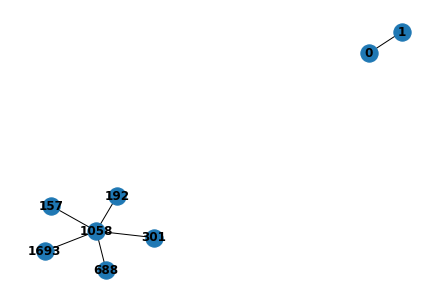

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

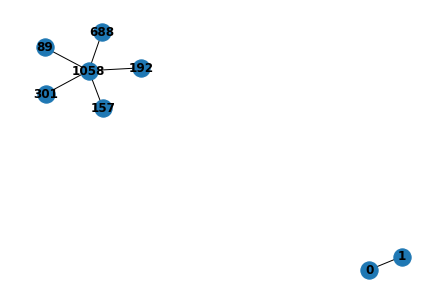

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1,  688,  301,  192,  157,   89]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

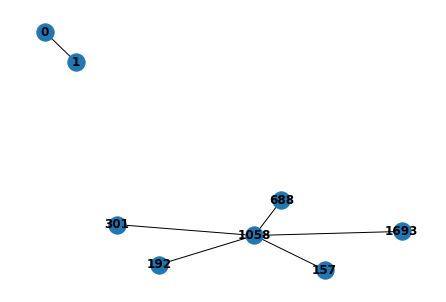

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [692]:
list_node_idx = range(n_basis,n_basis+500)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_sa_node(model, node_idx, data.x, data.edge_index, labels[node_idx])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [693]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.3775811209439528 6.412979351032448 0.3775811209439528 0.3775811209439528


In [694]:
def explain_ig_node(model, node_idx, x, edge_index, target, include_edges=None):
    ig = IntegratedGradients(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    ig_mask = ig.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                           internal_batch_size=input_mask.shape[0])

    node_attr = ig_mask.cpu().detach().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

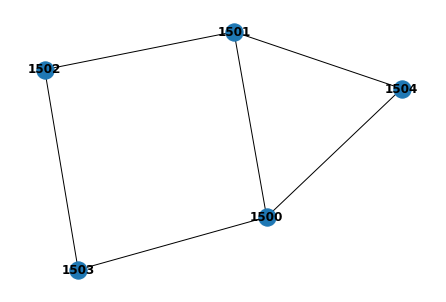

tensor([[1500, 1500, 1501, 1500, 1501, 1502],
        [1504, 1501, 1504, 1503, 1502, 1503]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

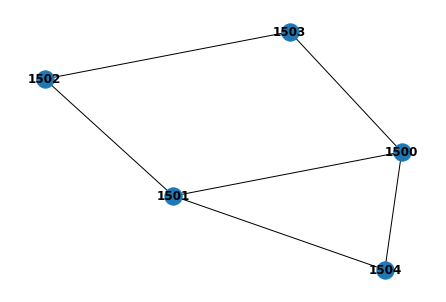

tensor([[1501, 1500, 1501, 1500, 1500, 1502],
        [1504, 1501, 1502, 1504, 1503, 1503]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

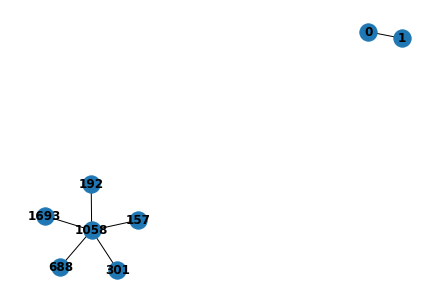

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

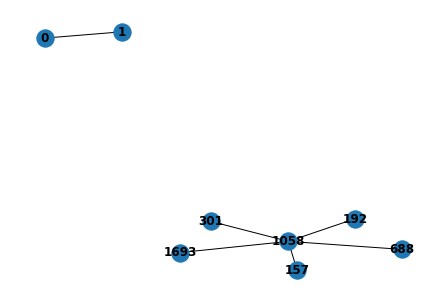

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

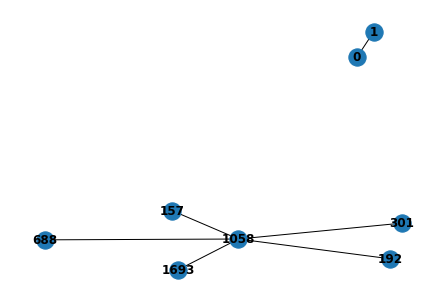

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

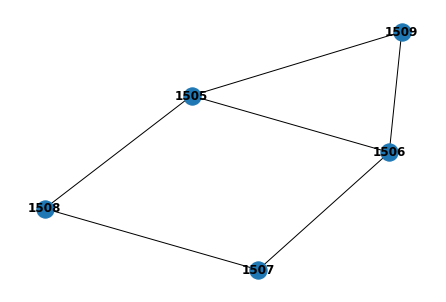

tensor([[1505, 1505, 1505, 1506, 1506, 1507],
        [1506, 1509, 1508, 1509, 1507, 1508]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

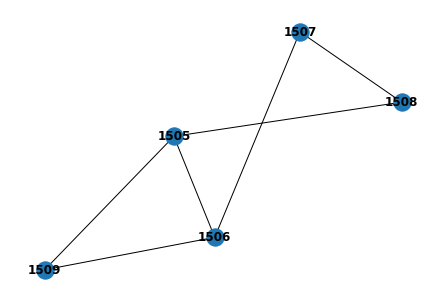

tensor([[1505, 1506, 1506, 1505, 1505, 1507],
        [1506, 1509, 1507, 1509, 1508, 1508]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

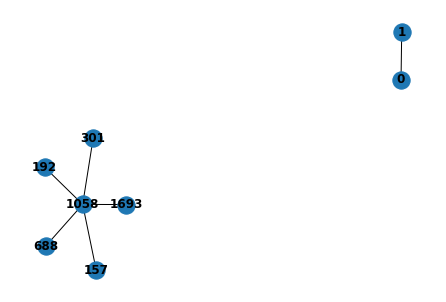

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

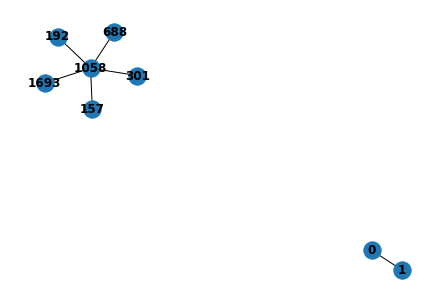

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

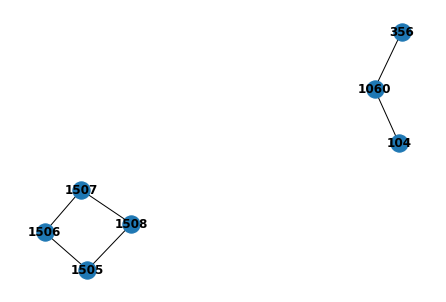

tensor([[1505, 1505, 1506, 1507, 1060, 1060],
        [1506, 1508, 1507, 1508,  356,  104]])
f1_score, ged 0.6666666666666666 6.0


<Figure size 432x288 with 0 Axes>

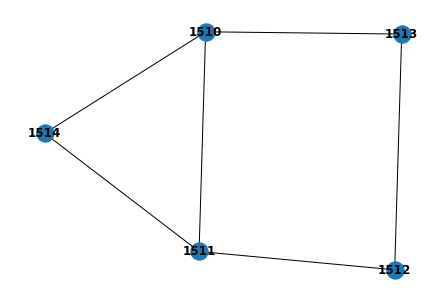

tensor([[1510, 1510, 1511, 1510, 1511, 1512],
        [1514, 1511, 1514, 1513, 1512, 1513]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

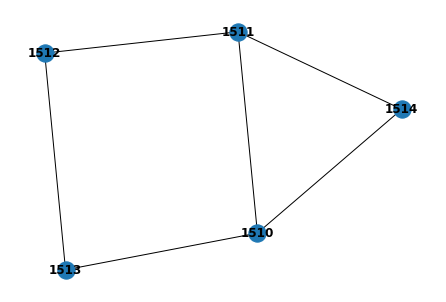

tensor([[1511, 1510, 1511, 1510, 1510, 1512],
        [1514, 1511, 1512, 1514, 1513, 1513]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

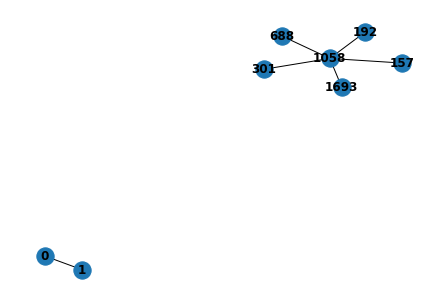

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

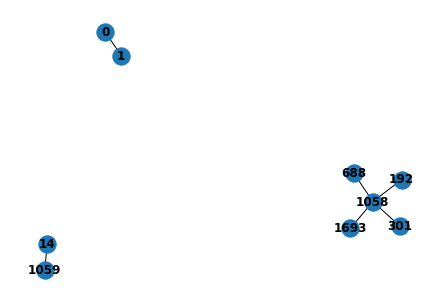

tensor([[   0, 1059, 1058, 1058, 1058, 1058],
        [   1,   14, 1693,  688,  301,  192]])
f1_score, ged 0 10.0


<Figure size 432x288 with 0 Axes>

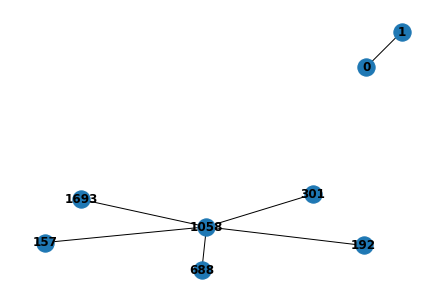

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

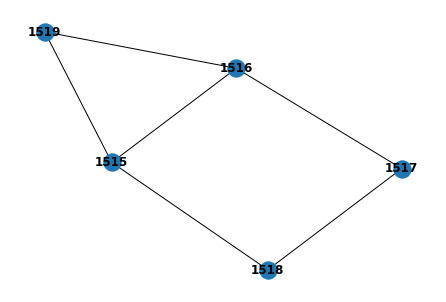

tensor([[1515, 1515, 1516, 1515, 1516, 1517],
        [1519, 1516, 1519, 1518, 1517, 1518]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

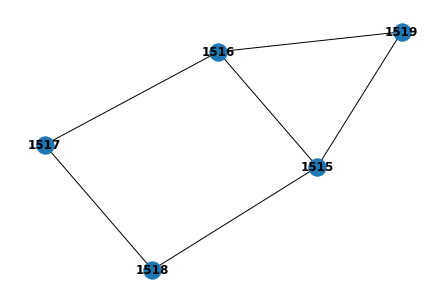

tensor([[1516, 1515, 1516, 1515, 1515, 1517],
        [1519, 1516, 1517, 1519, 1518, 1518]])
f1_score, ged 1.0 0.0


<Figure size 432x288 with 0 Axes>

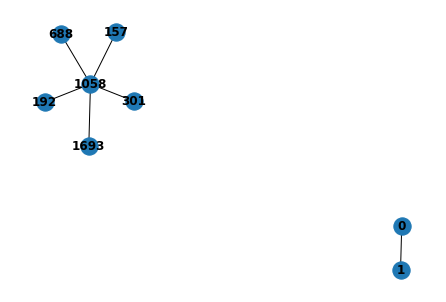

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

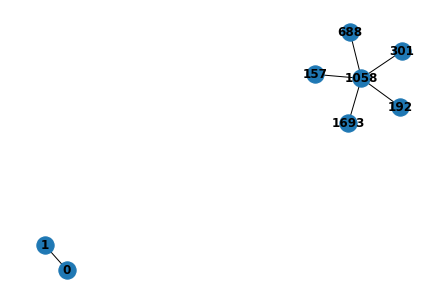

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

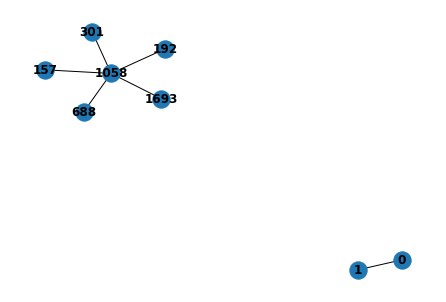

tensor([[   0, 1058, 1058, 1058, 1058, 1058],
        [   1, 1693,  688,  301,  192,  157]])
f1_score, ged 0 9.0


<Figure size 432x288 with 0 Axes>

In [697]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_ig_node(model, node_idx, data.x, data.edge_index, labels[node_idx])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [698]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.4333333333333333 5.3 0.4333333333333333 0.4333333333333333


In [705]:
def explain_occlusion(model, node_idx, x, edge_index, target, include_edges=None):
    depth_limit = 2 + 1
    data = Data(x=x, edge_index=edge_index)
    pred_prob = model(data.x, data.edge_index)[node_idx][target].item()
    g = to_networkx(data)
    subgraph_nodes = []
    for k, v in nx.shortest_path_length(g, target=node_idx).items():
        if v < depth_limit:
            subgraph_nodes.append(k)
    subgraph = g.subgraph(subgraph_nodes)
    edge_occlusion_mask = np.ones(data.num_edges, dtype=bool)
    edge_mask = np.zeros(data.num_edges)
    edge_index_numpy = data.edge_index.cpu().numpy()
    for i in range(data.num_edges):
        if include_edges is not None and not include_edges[i].item():
            continue
        u, v = list(edge_index_numpy[:, i])
        if (u, v) in subgraph.edges():
            edge_occlusion_mask[i] = False
            prob = model(data.x, data.edge_index[:, edge_occlusion_mask])[node_idx][target].item()
            edge_mask[i] = pred_prob - prob
            edge_occlusion_mask[i] = True
    return edge_mask


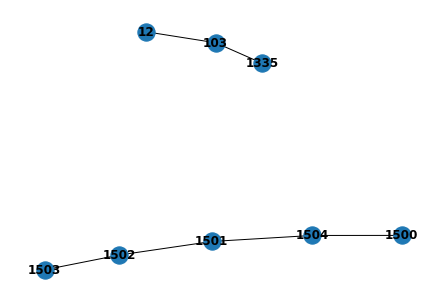

tensor([[1501, 1500, 1501, 1502,   12,  103],
        [1504, 1504, 1502, 1503,  103, 1335]])
f1_score, ged 0.6666666666666666 7.0


<Figure size 432x288 with 0 Axes>

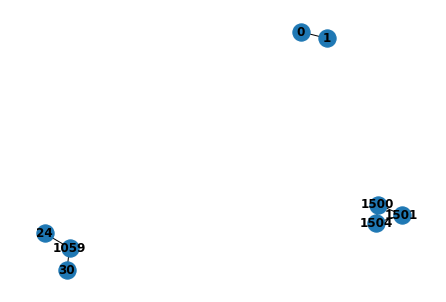

tensor([[1500, 1501, 1500,    0, 1059, 1059],
        [1501, 1504, 1504,    1,   30,   24]])
f1_score, ged 0.5 7.0


<Figure size 432x288 with 0 Axes>

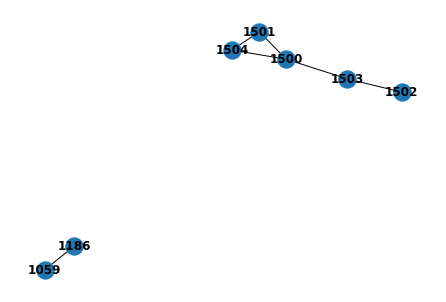

tensor([[1501, 1500, 1500, 1500, 1502, 1059],
        [1504, 1504, 1503, 1501, 1503, 1186]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

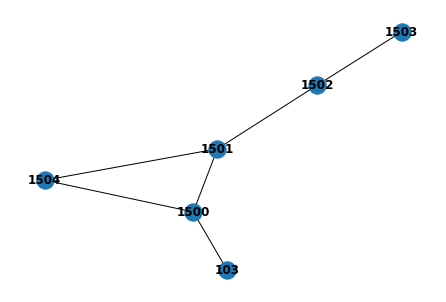

tensor([[1501, 1500,  103, 1501, 1500, 1502],
        [1504, 1504, 1500, 1502, 1501, 1503]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

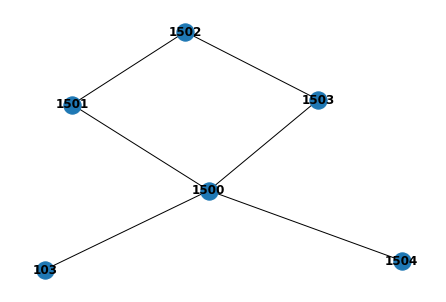

tensor([[ 103, 1500, 1501, 1500, 1500, 1502],
        [1500, 1501, 1502, 1504, 1503, 1503]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

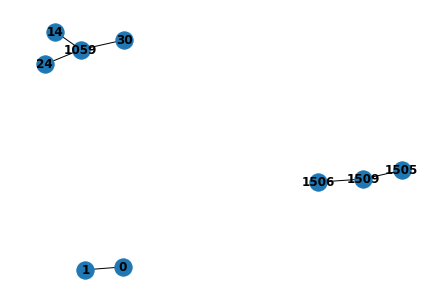

tensor([[1505, 1506,    0, 1059, 1059, 1059],
        [1509, 1509,    1,   30,   24,   14]])
f1_score, ged 0.3333333333333333 10.0


<Figure size 432x288 with 0 Axes>

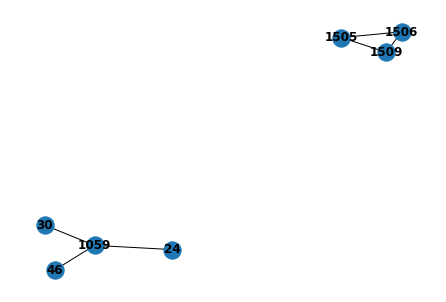

tensor([[1505, 1506, 1505, 1059, 1059, 1059],
        [1506, 1509, 1509,   46,   30,   24]])
f1_score, ged 0.5 6.0


<Figure size 432x288 with 0 Axes>

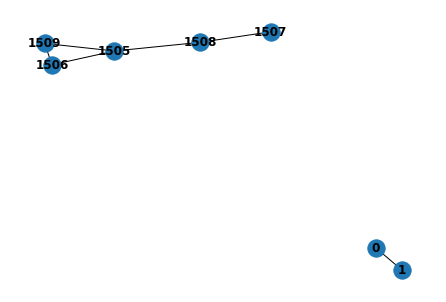

tensor([[1505, 1507, 1505, 1506, 1505,    0],
        [1508, 1508, 1509, 1509, 1506,    1]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

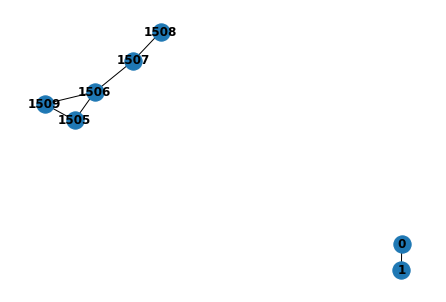

tensor([[1507, 1506, 1505, 1505, 1506,    0],
        [1508, 1507, 1506, 1509, 1509,    1]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

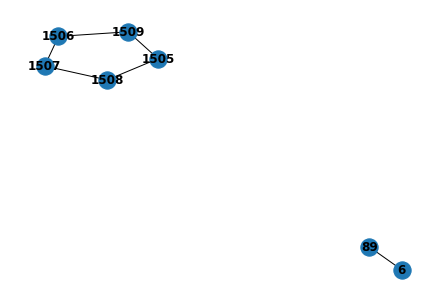

tensor([[1506, 1505, 1507, 1505, 1506,    6],
        [1509, 1509, 1508, 1508, 1507,   89]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

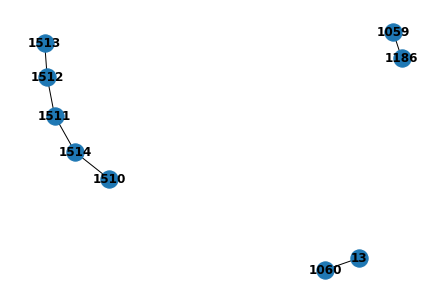

tensor([[1510, 1511, 1511, 1512, 1060, 1059],
        [1514, 1514, 1512, 1513,   13, 1186]])
f1_score, ged 0.6666666666666666 8.0


<Figure size 432x288 with 0 Axes>

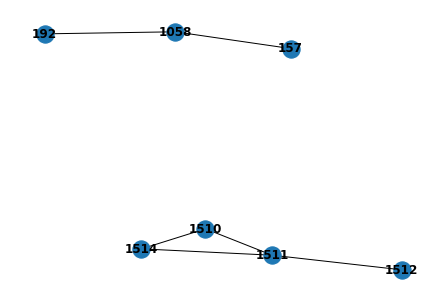

tensor([[1510, 1511, 1510, 1511, 1058, 1058],
        [1514, 1514, 1511, 1512,  157,  192]])
f1_score, ged 0.6666666666666666 6.0


<Figure size 432x288 with 0 Axes>

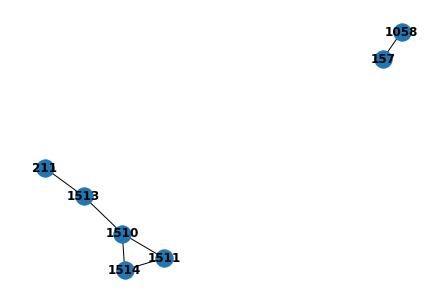

tensor([[1510, 1511,  211, 1510, 1510, 1058],
        [1514, 1514, 1513, 1513, 1511,  157]])
f1_score, ged 0.6666666666666666 4.0


<Figure size 432x288 with 0 Axes>

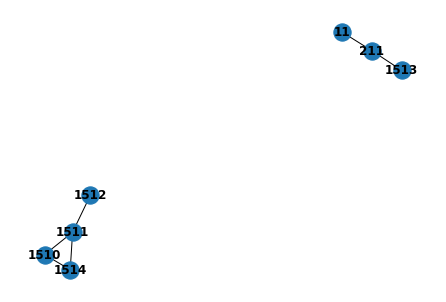

tensor([[1511, 1510,  211, 1511, 1510,   11],
        [1514, 1514, 1513, 1512, 1511,  211]])
f1_score, ged 0.6666666666666666 6.0


<Figure size 432x288 with 0 Axes>

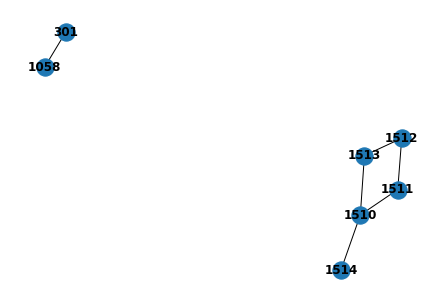

tensor([[1510, 1511, 1510, 1512, 1510, 1058],
        [1514, 1512, 1511, 1513, 1513,  301]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

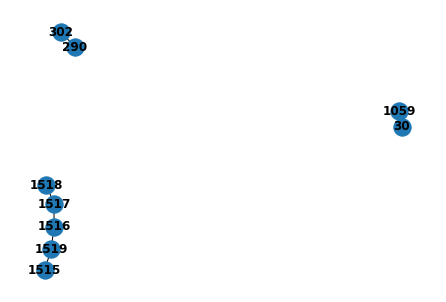

tensor([[1516, 1515, 1517, 1516,  290, 1059],
        [1519, 1519, 1518, 1517,  302,   30]])
f1_score, ged 0.6666666666666666 8.0


<Figure size 432x288 with 0 Axes>

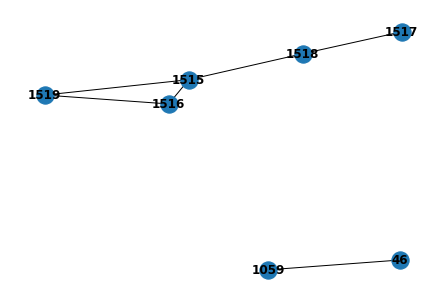

tensor([[1516, 1515, 1515, 1517, 1515, 1059],
        [1519, 1519, 1516, 1518, 1518,   46]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

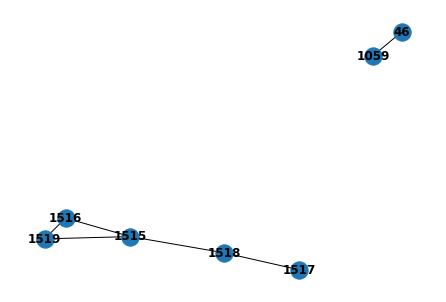

tensor([[1516, 1515, 1515, 1515, 1517, 1059],
        [1519, 1519, 1518, 1516, 1518,   46]])
f1_score, ged 0.8333333333333334 4.0


<Figure size 432x288 with 0 Axes>

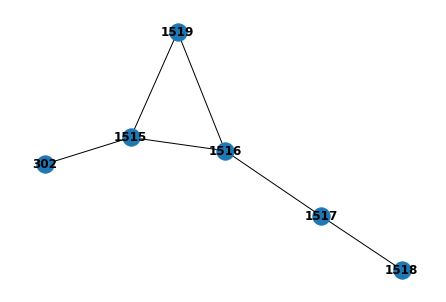

tensor([[1517, 1516, 1515, 1515, 1516,  302],
        [1518, 1519, 1519, 1516, 1517, 1515]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

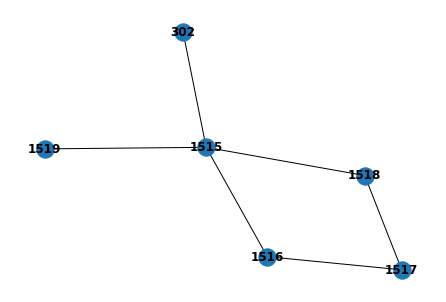

tensor([[ 302, 1515, 1517, 1515, 1516, 1515],
        [1515, 1516, 1518, 1518, 1517, 1519]])
f1_score, ged 0.8333333333333334 3.0


<Figure size 432x288 with 0 Axes>

In [706]:
list_node_idx = range(n_basis,n_basis+20)#*n_shapes)
F1_scores = []
GED = []
Recall = []
Precision = []

for node_idx in list_node_idx:
    edge_mask = explain_occlusion(model, node_idx, data.x, data.edge_index, labels[node_idx])
    edge_mask = mask_to_directed(edge_mask, data.edge_index)
    recall, precision, f1_score, ged = evaluate(node_idx, data, edge_mask, num_top_edges = 6)
    indices = (-edge_mask).argsort()[:6]
    print(data.edge_index[:,indices])
    Recall.append(recall)
    Precision.append(precision)
    F1_scores.append(f1_score)
    GED.append(ged)
    print("f1_score, ged", f1_score, ged)

In [707]:
print(np.mean(F1_scores), np.mean(GED), np.mean(Recall), np.mean(Precision))

0.7250000000000002 5.1 0.7250000000000002 0.7250000000000002


In [711]:
import numpy as np
import pandas as pd
import torch
from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax
from torch_geometric.utils import k_hop_subgraph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Node_Explainer:
    def __init__(
            self,
            model,
            edge_index,
            X,
            num_layers,
            mode=0,
            print_result=1
    ):
        self.model = model
        self.model.eval()
        self.edge_index = edge_index
        self.X = X
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result

    def perturb_features_on_node(self, feature_matrix, node_idx, random=0, mode=0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature

        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size=X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],
                                            np.random.uniform(low=0.0, high=2.0, size=X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb

    def explain(self, node_idx, target, num_samples=100, top_node=None, p_threshold=0.05, pred_threshold=0.1):
        neighbors, _, _, _ = k_hop_subgraph(node_idx, self.num_layers, self.edge_index)
        neighbors = neighbors.cpu().detach().numpy()

        if (node_idx not in neighbors):
            neighbors = np.append(neighbors, node_idx)

        pred_torch = self.model(self.X, self.edge_index).cpu()
        soft_pred = np.asarray([softmax(np.asarray(pred_torch[node_].data)) for node_ in range(self.X.shape[0])])

        pred_node = np.asarray(pred_torch[node_idx].data)
        label_node = np.argmax(pred_node)
        soft_pred_node = softmax(pred_node)

        Samples = []
        Pred_Samples = []

        for iteration in range(num_samples):

            X_perturb = self.X.cpu().detach().numpy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(2)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node(X_perturb, node, random=seed)
                else:
                    latent = 0
                sample.append(latent)

            X_perturb_torch = torch.tensor(X_perturb, dtype=torch.float).to(device)
            pred_perturb_torch = self.model(X_perturb_torch, self.edge_index).cpu()
            soft_pred_perturb = np.asarray(
                [softmax(np.asarray(pred_perturb_torch[node_].data)) for node_ in range(self.X.shape[0])])

            sample_bool = []
            for node in neighbors:
                if (soft_pred_perturb[node, target] + pred_threshold) < soft_pred[node, target]:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)

            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples - Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray(
                [Samples[s, i] * 10 + Pred_Samples[s, i] + 1 for i in range(Samples.shape[1])])

        data = pd.DataFrame(Combine_Samples)
        data = data.rename(columns={0: "A", 1: "B"})  # Trick to use chi_square test on first two data columns
        ind_ori_to_sub = dict(zip(neighbors, list(data.columns)))

        p_values = []
        for node in neighbors:
            chi2, p = chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data)
            p_values.append(p)

        pgm_stats = dict(zip(neighbors, p_values))

        return pgm_stats

ImportError: cannot import name '_centered' from 'scipy.signal.signaltools' (/Users/kenzaamara/PycharmProjects/Explain/explain/lib/python3.8/site-packages/scipy/signal/signaltools.py)

In [709]:
def explain_pgmexplainer(model, node_idx, x, edge_index, target, include_edges=None):
    explainer = Node_Explainer(model, edge_index, x, len(model.convs), print_result=0)
    explanation = explainer.explain(node_idx,target)
    node_attr = np.zeros(x.shape[0])
    for node, p_value in explanation.items():
        node_attr[node] = 1 - p_value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask